In [1]:
try:
    !pip uninstall -qy geometricvocab geofractal
except:
    pass

!pip install -q git+https://github.com/AbstractEyes/geofractal.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# benchmark and tests for global fractal router

In [1]:
"""
global_fractal_router_benchmark_v2.py - Performance analysis for GlobalFractalRouter

Benchmarks:
1. Component-level timing (identify bottlenecks)
2. Scaling behavior (batch, sequence, routes)
3. Memory profiling
4. Comparison vs baseline wormhole router
5. For-loop hotspot analysis (verifies optimizations)

Author: AbstractPhil
Date: December 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import gc
from typing import Dict, List, Tuple, Optional, Callable
from dataclasses import dataclass, field
from contextlib import contextmanager
import math

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    FingerprintRegistry,
    get_registry,
    AnchorBank,
    AdjacentGate,
    RouterMailbox,
    FractalRouterNetwork,
    ProvenanceTensor,
    build_local_mask,
    get_primes,
)
IMPORT_SUCCESS = True


# =============================================================================
# TIMING UTILITIES
# =============================================================================

@contextmanager
def cuda_timer(name: str, results: Dict[str, List[float]], sync: bool = True):
    """Context manager for CUDA-aware timing."""
    if torch.cuda.is_available() and sync:
        torch.cuda.synchronize()

    start = time.perf_counter()
    yield

    if torch.cuda.is_available() and sync:
        torch.cuda.synchronize()

    elapsed = (time.perf_counter() - start) * 1000  # ms

    if name not in results:
        results[name] = []
    results[name].append(elapsed)


def get_memory_mb() -> float:
    """Get current GPU memory usage in MB."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024 / 1024
    return 0.0


def clear_memory():
    """Clear GPU memory cache."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


# =============================================================================
# BASELINE ROUTER (for comparison)
# =============================================================================

class BaselineWormholeRouter(nn.Module):
    """Minimal wormhole router without fingerprinting overhead."""

    def __init__(self, dim: int, num_positions: int, num_routes: int = 8, temperature: float = 0.1):
        super().__init__()
        self.dim = dim
        self.num_positions = num_positions
        self.num_routes = min(num_routes, num_positions - 1)
        self.temperature = temperature

        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)

    def forward(self, x: torch.Tensor, skip_first: bool = True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if skip_first:
            x = x[:, 1:, :]

        B, P, D = x.shape

        q = F.normalize(self.query_proj(x), dim=-1)
        k = F.normalize(self.key_proj(x), dim=-1)
        v = self.value_proj(x)

        scores = torch.bmm(q, k.transpose(1, 2))

        mask = torch.eye(P, device=x.device, dtype=torch.bool)
        scores = scores.masked_fill(mask.unsqueeze(0), -1e9)

        topk_scores, routes = torch.topk(scores / self.temperature, self.num_routes, dim=-1)
        weights = F.softmax(topk_scores, dim=-1)

        K = self.num_routes
        routes_flat = routes.reshape(B, P * K).unsqueeze(-1).expand(-1, -1, D)
        v_gathered = torch.gather(v, 1, routes_flat).view(B, P, K, D)

        features = torch.einsum('bpk,bpkd->bpd', weights, v_gathered)

        return routes, weights, features


# =============================================================================
# BENCHMARK CONFIGURATION
# =============================================================================

@dataclass
class BenchmarkConfig:
    """Configuration for benchmark runs."""

    batch_sizes: List[int] = field(default_factory=lambda: [1, 2, 4, 8, 16])
    seq_lengths: List[int] = field(default_factory=lambda: [65, 129, 257, 513])
    feature_dims: List[int] = field(default_factory=lambda: [256, 512])
    num_routes: List[int] = field(default_factory=lambda: [4, 8, 16])

    warmup_iterations: int = 3
    benchmark_iterations: int = 10

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: torch.dtype = torch.float32

    run_component_breakdown: bool = True
    run_scaling_analysis: bool = True
    run_memory_profile: bool = True
    run_baseline_comparison: bool = True
    run_loop_analysis: bool = True
    run_network_benchmark: bool = True
    run_optimization_verification: bool = True


# =============================================================================
# LOOP ANALYSIS (with optimization verification)
# =============================================================================

class LoopAnalysisBenchmark:
    """Analyzes loop hotspots and verifies optimizations."""

    def __init__(self, config: BenchmarkConfig):
        self.config = config
        self.results: Dict[str, Dict] = {}

    def run(self) -> Dict[str, Dict]:
        """Analyze all known loop locations."""
        device = self.config.device

        print("\n  Analyzing loop hotspots...")

        self._benchmark_prime_generation()
        self._benchmark_basis_construction()
        self._benchmark_potential_fields(device)
        self._benchmark_mailbox_read(device)
        self._benchmark_local_mask()

        if IMPORT_SUCCESS:
            self._verify_optimizations(device)

        return self.results

    def _benchmark_prime_generation(self):
        """Benchmark prime number generation."""
        print("\n    Prime generation:")

        # Original slow version
        def generate_primes_slow(n: int) -> List[int]:
            primes = []
            candidate = 2
            while len(primes) < n:
                is_prime = all(candidate % p != 0 for p in primes if p * p <= candidate)
                if is_prime:
                    primes.append(candidate)
                candidate += 1
            return primes

        for n in [100, 500, 1000, 2000]:
            # Time slow version
            times_slow = []
            for _ in range(3):
                start = time.perf_counter()
                _ = generate_primes_slow(n)
                times_slow.append((time.perf_counter() - start) * 1000)

            mean_slow = sum(times_slow) / len(times_slow)

            # Time optimized version (if available)
            if IMPORT_SUCCESS:
                times_fast = []
                for _ in range(3):
                    start = time.perf_counter()
                    _ = get_primes(n)
                    times_fast.append((time.perf_counter() - start) * 1000)
                mean_fast = sum(times_fast) / len(times_fast)
                speedup = mean_slow / max(mean_fast, 0.001)
                print(f"      n={n:4d}: slow={mean_slow:.2f}ms, fast={mean_fast:.4f}ms, speedup={speedup:.0f}x")
            else:
                print(f"      n={n:4d}: {mean_slow:.3f} ms")

            self.results[f'primes_{n}'] = {'mean_ms': mean_slow, 'complexity': 'O(n²) worst case'}

    def _benchmark_basis_construction(self):
        """Benchmark orthogonal basis construction."""
        print("\n    Basis construction:")

        # Original slow version
        def build_basis_slow(dim: int, count: int) -> torch.Tensor:
            basis = torch.zeros(count, dim)
            for i in range(count):
                t = torch.linspace(0, 2 * math.pi * (i + 2), dim)
                basis[i] = torch.sin(t) * math.cos(i * 0.1)
            return F.normalize(basis, dim=-1)

        # Optimized version
        def build_basis_fast(dim: int, count: int) -> torch.Tensor:
            primes = torch.arange(2, count + 2, dtype=torch.float32)
            t = torch.linspace(0, 2 * math.pi, dim).unsqueeze(0)
            p = primes.unsqueeze(1)
            i = torch.arange(count, dtype=torch.float32).unsqueeze(1)
            basis = torch.sin(t * p) * torch.cos(i * 0.1)
            return F.normalize(basis, dim=-1)

        for count in [256, 512, 1024]:
            times_slow = []
            for _ in range(3):
                start = time.perf_counter()
                _ = build_basis_slow(64, count)
                times_slow.append((time.perf_counter() - start) * 1000)

            times_fast = []
            for _ in range(3):
                start = time.perf_counter()
                _ = build_basis_fast(64, count)
                times_fast.append((time.perf_counter() - start) * 1000)

            mean_slow = sum(times_slow) / len(times_slow)
            mean_fast = sum(times_fast) / len(times_fast)
            speedup = mean_slow / max(mean_fast, 0.001)

            print(f"      count={count:4d}: slow={mean_slow:.2f}ms, fast={mean_fast:.3f}ms, speedup={speedup:.1f}x")
            self.results[f'basis_{count}'] = {'mean_ms': mean_fast, 'complexity': 'O(count × dim)'}

    def _benchmark_potential_fields(self, device: str):
        """Benchmark potential field computation."""
        print("\n    Potential field computation:")

        feature_dim = 256
        fingerprint_dim = 64
        hidden_dim = 256
        batch_size = 64

        for num_fields in [2, 4, 8, 16]:
            # Slow: separate MLPs
            generators = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(feature_dim + fingerprint_dim, hidden_dim),
                    nn.GELU(),
                    nn.Linear(hidden_dim, 1),
                )
                for _ in range(num_fields)
            ]).to(device)

            # Fast: single MLP with multi-output
            single_net = nn.Sequential(
                nn.Linear(feature_dim + fingerprint_dim, hidden_dim),
                nn.GELU(),
                nn.Linear(hidden_dim, num_fields),
            ).to(device)

            features = torch.randn(batch_size, feature_dim, device=device)
            fingerprint = torch.randn(fingerprint_dim, device=device)
            combined = torch.cat([features, fingerprint.expand(batch_size, -1)], dim=-1)

            # Warmup
            for _ in range(3):
                potentials = []
                for gen in generators:
                    potentials.append(gen(combined))
                _ = torch.cat(potentials, dim=-1)
                _ = single_net(combined)

            # Benchmark slow
            times_slow = []
            for _ in range(10):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                start = time.perf_counter()
                potentials = []
                for gen in generators:
                    potentials.append(gen(combined))
                _ = torch.cat(potentials, dim=-1)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                times_slow.append((time.perf_counter() - start) * 1000)

            # Benchmark fast
            times_fast = []
            for _ in range(10):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                start = time.perf_counter()
                _ = single_net(combined)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                times_fast.append((time.perf_counter() - start) * 1000)

            mean_slow = sum(times_slow) / len(times_slow)
            mean_fast = sum(times_fast) / len(times_fast)
            speedup = mean_slow / max(mean_fast, 0.001)

            print(f"      num_fields={num_fields:2d}: slow={mean_slow:.3f}ms, fast={mean_fast:.3f}ms, speedup={speedup:.1f}x")
            self.results[f'potential_fields_{num_fields}'] = {
                'mean_ms': mean_fast,
                'complexity': 'O(1) batched',
            }

            del generators, single_net
            clear_memory()

    def _benchmark_mailbox_read(self, device: str):
        """Benchmark mailbox message reading."""
        print("\n    Mailbox read operation:")

        fingerprint_dim = 64

        for num_messages in [4, 16, 64, 256]:
            fingerprints = torch.randn(num_messages, fingerprint_dim, device=device)
            reader_fp = torch.randn(fingerprint_dim, device=device)

            # Slow: loop
            times_slow = []
            for _ in range(10):
                start = time.perf_counter()
                scored = []
                for i in range(num_messages):
                    fp_sim = F.cosine_similarity(
                        reader_fp.unsqueeze(0),
                        fingerprints[i].unsqueeze(0)
                    ).item()
                    scored.append((fp_sim, i))
                scored.sort(key=lambda x: -x[0])
                _ = scored[:4]
                times_slow.append((time.perf_counter() - start) * 1000)

            # Fast: batched
            times_fast = []
            for _ in range(10):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                start = time.perf_counter()
                sims = F.cosine_similarity(reader_fp.unsqueeze(0), fingerprints, dim=-1)
                _, top_indices = torch.topk(sims, min(4, num_messages))
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                times_fast.append((time.perf_counter() - start) * 1000)

            mean_slow = sum(times_slow) / len(times_slow)
            mean_fast = sum(times_fast) / len(times_fast)
            speedup = mean_slow / max(mean_fast, 0.001)

            print(f"      num_messages={num_messages:3d}: slow={mean_slow:.2f}ms, fast={mean_fast:.3f}ms, speedup={speedup:.0f}x")
            self.results[f'mailbox_read_{num_messages}'] = {
                'mean_ms': mean_fast,
                'complexity': 'O(1) batched',
            }

    def _benchmark_local_mask(self):
        """Benchmark local window mask construction."""
        print("\n    Local window mask construction:")

        # Slow: nested loops
        def build_local_mask_slow(num_positions: int, grid_size: int, window: int) -> torch.Tensor:
            P, G, W = num_positions, grid_size, window
            mask = torch.ones(P, P, dtype=torch.bool)
            for i in range(P):
                xi, yi = i % G, i // G
                for j in range(P):
                    xj, yj = j % G, j // G
                    if abs(xi - xj) <= W and abs(yi - yj) <= W:
                        mask[i, j] = False
            return mask

        # Fast: meshgrid
        def build_local_mask_fast(num_positions: int, grid_size: int, window: int) -> torch.Tensor:
            pos = torch.arange(num_positions)
            x = pos % grid_size
            y = pos // grid_size
            xi, xj = torch.meshgrid(x, x, indexing='ij')
            yi, yj = torch.meshgrid(y, y, indexing='ij')
            return ((xi - xj).abs() > window) | ((yi - yj).abs() > window)

        for num_positions in [64, 256, 1024]:
            grid_size = int(math.sqrt(num_positions))

            times_slow = []
            for _ in range(3):
                start = time.perf_counter()
                mask_slow = build_local_mask_slow(num_positions, grid_size, 3)
                times_slow.append((time.perf_counter() - start) * 1000)

            times_fast = []
            for _ in range(3):
                start = time.perf_counter()
                mask_fast = build_local_mask_fast(num_positions, grid_size, 3)
                times_fast.append((time.perf_counter() - start) * 1000)

            mean_slow = sum(times_slow) / len(times_slow)
            mean_fast = sum(times_fast) / len(times_fast)
            speedup = mean_slow / max(mean_fast, 0.001)

            # Verify correctness
            match = torch.equal(mask_slow, mask_fast)

            print(f"      positions={num_positions:4d}: slow={mean_slow:.1f}ms, fast={mean_fast:.3f}ms, speedup={speedup:.0f}x, match={match}")
            self.results[f'local_mask_{num_positions}'] = {
                'mean_ms': mean_fast,
                'complexity': 'O(P²) vectorized',
                'speedup': speedup,
            }

    def _verify_optimizations(self, device: str):
        """Verify that optimized router uses all optimizations."""
        print("\n    Verifying optimizations in GlobalFractalRouter:")

        get_registry().reset()
        config = GlobalFractalRouterConfig(
            feature_dim=256,
            fingerprint_dim=64,
            num_anchors=16,
            num_routes=8,
        )

        router = GlobalFractalRouter(config, name="verify_test").to(device)

        # Check AdjacentGate uses single MLP
        if hasattr(router.adjacent_gate, 'field_net'):
            print("      ✓ AdjacentGate uses batched field_net")
        else:
            print("      ✗ AdjacentGate still uses separate generators")

        # Check AnchorBank uses vectorized fingerprints
        if router.anchor_bank.anchor_fingerprints.shape[0] == config.num_anchors:
            print("      ✓ AnchorBank fingerprints vectorized")

        del router
        clear_memory()


# =============================================================================
# SCALING ANALYSIS
# =============================================================================

class ScalingAnalysisBenchmark:
    """Analyzes how performance scales with input dimensions."""

    def __init__(self, config: BenchmarkConfig):
        self.config = config

    def run(self, router_factory: Callable) -> Dict[str, Dict]:
        results = {
            'batch_scaling': {},
            'sequence_scaling': {},
            'dimension_scaling': {},
        }

        device = self.config.device

        print("\n  Batch scaling...")
        dim, seq = 256, 65
        router = router_factory(dim, seq - 1).to(device)
        router.eval()

        for batch in self.config.batch_sizes:
            x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)
            time_ms = self._time_forward(router, x)
            results['batch_scaling'][batch] = time_ms
            print(f"    B={batch:3d}: {time_ms:.3f} ms")

        del router
        clear_memory()

        print("\n  Sequence scaling...")
        batch, dim = 4, 256

        for seq in self.config.seq_lengths:
            router = router_factory(dim, seq - 1).to(device)
            router.eval()
            x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)
            time_ms = self._time_forward(router, x)
            results['sequence_scaling'][seq] = time_ms
            print(f"    S={seq:4d}: {time_ms:.3f} ms")
            del router
            clear_memory()

        print("\n  Dimension scaling...")
        batch, seq = 4, 65

        for dim in self.config.feature_dims:
            router = router_factory(dim, seq - 1).to(device)
            router.eval()
            x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)
            time_ms = self._time_forward(router, x)
            results['dimension_scaling'][dim] = time_ms
            print(f"    D={dim:4d}: {time_ms:.3f} ms")
            del router
            clear_memory()

        return results

    def _time_forward(self, router: nn.Module, x: torch.Tensor) -> float:
        for _ in range(self.config.warmup_iterations):
            with torch.no_grad():
                _ = router(x)

        times = []
        for _ in range(self.config.benchmark_iterations):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.perf_counter()
            with torch.no_grad():
                _ = router(x)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append((time.perf_counter() - start) * 1000)

        return sum(times) / len(times)


# =============================================================================
# MEMORY PROFILE
# =============================================================================

class MemoryProfileBenchmark:
    """Profiles memory usage."""

    def __init__(self, config: BenchmarkConfig):
        self.config = config

    def run(self, router_factory: Callable) -> Dict[str, Dict]:
        if not torch.cuda.is_available():
            print("  Memory profiling requires CUDA")
            return {}

        results = {}
        device = self.config.device

        test_configs = [
            (4, 65, 256, "small"),
            (8, 129, 512, "medium"),
            (16, 257, 512, "large"),
        ]

        for batch, seq, dim, name in test_configs:
            clear_memory()
            torch.cuda.reset_peak_memory_stats()

            base_mem = get_memory_mb()
            router = router_factory(dim, seq - 1).to(device)
            router_mem = get_memory_mb()

            x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)
            input_mem = get_memory_mb()

            with torch.no_grad():
                routes, weights, features = router(x)
            forward_mem = get_memory_mb()

            peak_mem = torch.cuda.max_memory_allocated() / 1024 / 1024

            results[name] = {
                'config': f"B={batch}, S={seq}, D={dim}",
                'router_mb': router_mem - base_mem,
                'input_mb': input_mem - router_mem,
                'forward_mb': forward_mem - input_mem,
                'peak_mb': peak_mem,
                'params': sum(p.numel() for p in router.parameters()),
            }

            print(f"  {name}: router={results[name]['router_mb']:.1f}MB, "
                  f"forward={results[name]['forward_mb']:.1f}MB, peak={peak_mem:.1f}MB")

            del router, x, routes, weights, features
            clear_memory()

        return results


# =============================================================================
# BASELINE COMPARISON
# =============================================================================

class BaselineComparisonBenchmark:
    """Compares GlobalFractalRouter against baseline."""

    def __init__(self, config: BenchmarkConfig):
        self.config = config

    def run(
        self,
        global_router_factory: Callable,
        baseline_router_factory: Callable,
    ) -> Dict[str, Dict]:
        results = {}
        device = self.config.device

        test_configs = [
            (4, 65, 256, "4x64x256"),
            (8, 129, 256, "8x128x256"),
            (4, 65, 512, "4x64x512"),
        ]

        for batch, seq, dim, name in test_configs:
            print(f"\n  Config: {name}")

            x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)

            baseline = baseline_router_factory(dim, seq - 1).to(device)
            baseline.eval()
            baseline_time = self._time_forward(baseline, x)

            global_router = global_router_factory(dim, seq - 1).to(device)
            global_router.eval()
            global_time = self._time_forward(global_router, x)

            overhead = (global_time - baseline_time) / baseline_time * 100

            results[name] = {
                'baseline_ms': baseline_time,
                'global_ms': global_time,
                'overhead_pct': overhead,
                'baseline_params': sum(p.numel() for p in baseline.parameters()),
                'global_params': sum(p.numel() for p in global_router.parameters()),
            }

            print(f"    Baseline: {baseline_time:.3f} ms ({results[name]['baseline_params']:,} params)")
            print(f"    Global:   {global_time:.3f} ms ({results[name]['global_params']:,} params)")
            print(f"    Overhead: {overhead:+.1f}%")

            del baseline, global_router
            clear_memory()

        return results

    def _time_forward(self, router: nn.Module, x: torch.Tensor) -> float:
        for _ in range(self.config.warmup_iterations):
            with torch.no_grad():
                _ = router(x)

        times = []
        for _ in range(self.config.benchmark_iterations):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.perf_counter()
            with torch.no_grad():
                _ = router(x)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append((time.perf_counter() - start) * 1000)

        return sum(times) / len(times)


# =============================================================================
# NETWORK BENCHMARK
# =============================================================================

class NetworkBenchmark:
    """Benchmarks FractalRouterNetwork topologies."""

    def __init__(self, config: BenchmarkConfig):
        self.config = config

    def run(self, network_factory: Callable) -> Dict[str, Dict]:
        results = {}
        device = self.config.device

        batch, seq, dim = 4, 65, 256
        x = torch.randn(batch, seq, dim, device=device, dtype=self.config.dtype)

        for topology in ["chain", "parallel", "tree"]:
            for num_routers in [2, 4, 8]:
                name = f"{topology}_{num_routers}"
                print(f"\n    {name}:")

                try:
                    network = network_factory(dim, seq - 1, num_routers, topology).to(device)
                    network.eval()

                    for _ in range(self.config.warmup_iterations):
                        with torch.no_grad():
                            _ = network(x)

                    times = []
                    for _ in range(self.config.benchmark_iterations):
                        if torch.cuda.is_available():
                            torch.cuda.synchronize()
                        start = time.perf_counter()
                        with torch.no_grad():
                            _ = network(x)
                        if torch.cuda.is_available():
                            torch.cuda.synchronize()
                        times.append((time.perf_counter() - start) * 1000)

                    mean_time = sum(times) / len(times)
                    per_router = mean_time / num_routers

                    results[name] = {
                        'total_ms': mean_time,
                        'per_router_ms': per_router,
                        'num_routers': num_routers,
                        'topology': topology,
                    }

                    print(f"      Total: {mean_time:.3f} ms, Per-router: {per_router:.3f} ms")

                    del network
                    clear_memory()

                except Exception as e:
                    print(f"      Error: {e}")
                    results[name] = {'error': str(e)}

        return results


# =============================================================================
# MAIN BENCHMARK RUNNER
# =============================================================================

class GlobalFractalRouterBenchmark:
    """Main benchmark orchestrator."""

    def __init__(self, config: Optional[BenchmarkConfig] = None):
        self.config = config or BenchmarkConfig()
        self.results: Dict[str, Dict] = {}

    def run_all(self) -> Dict[str, Dict]:
        print("=" * 70)
        print("Global Fractal Router V2 Benchmark Suite")
        print("=" * 70)
        print(f"Device: {self.config.device}")
        print(f"Dtype: {self.config.dtype}")
        print(f"Warmup: {self.config.warmup_iterations}, Iterations: {self.config.benchmark_iterations}")

        if IMPORT_SUCCESS:
            get_registry().reset()

        def global_router_factory(dim: int, num_positions: int):
            if IMPORT_SUCCESS:
                config = GlobalFractalRouterConfig(
                    feature_dim=dim,
                    fingerprint_dim=64,
                    num_anchors=16,
                    num_routes=8,
                )
                get_registry().reset()
                return GlobalFractalRouter(config)
            else:
                raise RuntimeError("GlobalFractalRouter not available")

        def baseline_factory(dim: int, num_positions: int):
            return BaselineWormholeRouter(dim, num_positions, num_routes=8)

        def network_factory(dim: int, num_positions: int, num_routers: int, topology: str):
            if IMPORT_SUCCESS:
                config = GlobalFractalRouterConfig(feature_dim=dim, num_routes=8)
                get_registry().reset()
                return FractalRouterNetwork(config, num_routers=num_routers, topology=topology)
            else:
                raise RuntimeError("FractalRouterNetwork not available")

        if self.config.run_loop_analysis:
            print("\n" + "-" * 70)
            print("LOOP ANALYSIS & OPTIMIZATION VERIFICATION")
            print("-" * 70)
            bench = LoopAnalysisBenchmark(self.config)
            self.results['loop_analysis'] = bench.run()

        if self.config.run_baseline_comparison and IMPORT_SUCCESS:
            print("\n" + "-" * 70)
            print("BASELINE COMPARISON")
            print("-" * 70)
            bench = BaselineComparisonBenchmark(self.config)
            self.results['baseline_comparison'] = bench.run(global_router_factory, baseline_factory)

        if self.config.run_scaling_analysis:
            print("\n" + "-" * 70)
            print("SCALING ANALYSIS (baseline router)")
            print("-" * 70)
            bench = ScalingAnalysisBenchmark(self.config)
            self.results['baseline_scaling'] = bench.run(baseline_factory)

            if IMPORT_SUCCESS:
                print("\n" + "-" * 70)
                print("SCALING ANALYSIS (global fractal router)")
                print("-" * 70)
                self.results['global_scaling'] = bench.run(global_router_factory)

        if self.config.run_memory_profile and torch.cuda.is_available() and IMPORT_SUCCESS:
            print("\n" + "-" * 70)
            print("MEMORY PROFILE")
            print("-" * 70)
            bench = MemoryProfileBenchmark(self.config)
            self.results['memory_profile'] = bench.run(global_router_factory)

        if self.config.run_network_benchmark and IMPORT_SUCCESS:
            print("\n" + "-" * 70)
            print("NETWORK BENCHMARK")
            print("-" * 70)
            bench = NetworkBenchmark(self.config)
            self.results['network'] = bench.run(network_factory)

        self._print_summary()

        return self.results

    def _print_summary(self):
        print("\n" + "=" * 70)
        print("SUMMARY & RECOMMENDATIONS")
        print("=" * 70)

        if 'loop_analysis' in self.results:
            print("\n[Optimization Status]")
            for key, data in self.results['loop_analysis'].items():
                if isinstance(data, dict) and 'speedup' in data:
                    speedup = data['speedup']
                    status = "✓" if speedup > 10 else "⚠" if speedup > 2 else "✗"
                    print(f"  {status} {key}: {speedup:.0f}x speedup")

        if 'baseline_comparison' in self.results:
            print("\n[Overhead Analysis]")
            for config, data in self.results['baseline_comparison'].items():
                if 'overhead_pct' in data:
                    overhead = data['overhead_pct']
                    status = "✓" if overhead < 50 else "⚠" if overhead < 100 else "✗"
                    print(f"  {status} {config}: {overhead:+.1f}% overhead")

        if 'memory_profile' in self.results:
            print("\n[Memory Efficiency]")
            for config, data in self.results['memory_profile'].items():
                if 'peak_mb' in data:
                    print(f"  {config}: {data['peak_mb']:.1f} MB peak")

        print("\n" + "=" * 70)


# =============================================================================
# COLAB / NOTEBOOK RUNNER
# =============================================================================

def run_benchmark(
    device: str = None,
    iterations: int = 10,
    warmup: int = 3,
    quick: bool = False,
    loops_only: bool = False,
    scaling_only: bool = False,
    memory_only: bool = False,
    comparison_only: bool = False,
    network_only: bool = False,
) -> Dict[str, Dict]:
    """
    Run GlobalFractalRouter benchmarks.

    Args:
        device: "cuda" or "cpu" (auto-detected if None)
        iterations: Benchmark iterations per test
        warmup: Warmup iterations
        quick: Reduced test suite
        loops_only: Only run loop analysis
        scaling_only: Only run scaling analysis
        memory_only: Only run memory profiling
        comparison_only: Only run baseline comparison
        network_only: Only run network benchmark

    Returns:
        Dict of benchmark results

    Example:
        results = run_benchmark(quick=True)
        results = run_benchmark(device="cuda", iterations=20)
        results = run_benchmark(loops_only=True)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    config = BenchmarkConfig(
        device=device,
        benchmark_iterations=3 if quick else iterations,
        warmup_iterations=1 if quick else warmup,
        batch_sizes=[1, 4, 8] if quick else [1, 2, 4, 8, 16],
        seq_lengths=[65, 129] if quick else [65, 129, 257, 513],
        feature_dims=[256] if quick else [256, 512],
        num_routes=[4, 8] if quick else [4, 8, 16],
    )

    if loops_only:
        config.run_component_breakdown = False
        config.run_scaling_analysis = False
        config.run_memory_profile = False
        config.run_baseline_comparison = False
        config.run_network_benchmark = False
        config.run_loop_analysis = True
    elif scaling_only:
        config.run_component_breakdown = False
        config.run_loop_analysis = False
        config.run_memory_profile = False
        config.run_baseline_comparison = False
        config.run_network_benchmark = False
        config.run_scaling_analysis = True
    elif memory_only:
        config.run_component_breakdown = False
        config.run_loop_analysis = False
        config.run_scaling_analysis = False
        config.run_baseline_comparison = False
        config.run_network_benchmark = False
        config.run_memory_profile = True
    elif comparison_only:
        config.run_component_breakdown = False
        config.run_loop_analysis = False
        config.run_scaling_analysis = False
        config.run_memory_profile = False
        config.run_network_benchmark = False
        config.run_baseline_comparison = True
    elif network_only:
        config.run_component_breakdown = False
        config.run_loop_analysis = False
        config.run_scaling_analysis = False
        config.run_memory_profile = False
        config.run_baseline_comparison = False
        config.run_network_benchmark = True

    benchmark = GlobalFractalRouterBenchmark(config)
    return benchmark.run_all()


if __name__ == "__main__":
    # =========================================================================
    # INLINE CONFIGURATION
    # =========================================================================

    DEVICE = None          # None = auto-detect
    ITERATIONS = 10
    WARMUP = 3
    QUICK = True           # Fast iteration mode

    # Selective benchmarks (all False = run everything)
    LOOPS_ONLY = False
    SCALING_ONLY = False
    MEMORY_ONLY = False
    COMPARISON_ONLY = False
    NETWORK_ONLY = False

    # =========================================================================

    results = run_benchmark(
        device=DEVICE,
        iterations=ITERATIONS,
        warmup=WARMUP,
        quick=QUICK,
        loops_only=LOOPS_ONLY,
        scaling_only=SCALING_ONLY,
        memory_only=MEMORY_ONLY,
        comparison_only=COMPARISON_ONLY,
        network_only=NETWORK_ONLY,
    )

    print("\nResults keys:", list(results.keys()))

Global Fractal Router V2 Benchmark Suite
Device: cuda
Dtype: torch.float32
Warmup: 1, Iterations: 3

----------------------------------------------------------------------
LOOP ANALYSIS & OPTIMIZATION VERIFICATION
----------------------------------------------------------------------

  Analyzing loop hotspots...

    Prime generation:
      n= 100: slow=0.70ms, fast=0.0022ms, speedup=310x
      n= 500: slow=8.27ms, fast=0.0045ms, speedup=1846x
      n=1000: slow=24.65ms, fast=0.0065ms, speedup=3799x
      n=2000: slow=99.47ms, fast=1.1439ms, speedup=87x

    Basis construction:
      count= 256: slow=6.84ms, fast=0.204ms, speedup=33.6x
      count= 512: slow=12.61ms, fast=0.215ms, speedup=58.6x
      count=1024: slow=26.69ms, fast=0.287ms, speedup=93.0x

    Potential field computation:
      num_fields= 2: slow=0.437ms, fast=0.113ms, speedup=3.9x
      num_fields= 4: slow=0.736ms, fast=0.114ms, speedup=6.5x
      num_fields= 8: slow=1.195ms, fast=0.124ms, speedup=9.7x
      num_field

# unsupervised cantor fingerprint mnist experiments

In [3]:
# ================================================================
# Cantor Fingerprint MNIST Experiment
# - Implants Cantor-like patterns into MNIST images
# - 10 epochs unsupervised (autoencoder)
# - 10 epochs supervised (fingerprint classification)
# ================================================================

!pip install torch torchvision -q

import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms


# ================================================================
# CONFIG
# ================================================================

@dataclass
class BaseConfig:
    data_root: str = "./data"
    batch_size: int = 128
    latent_dim: int = 128
    num_fingerprints: int = 4  # distinct Cantor patterns
    img_size: int = 28
    unsup_epochs: int = 10
    sup_epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42
    recon_loss_weight: float = 1.0  # only used in unsup phase here


cfg = BaseConfig()


# ================================================================
# UTILS: SEEDING
# ================================================================

def set_seed(seed: int):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(cfg.seed)


# ================================================================
# CANTOR MASK GENERATION
# ================================================================

def cantor_1d(length: int, depth: int = 4) -> torch.Tensor:
    """
    Approximate 1D Cantor set as a binary mask of given length.
    We build it at length 3**depth and then downsample.
    """
    base_len = 3 ** depth
    arr = torch.ones(base_len)

    seg_len = base_len
    for _ in range(depth):
        seg_len //= 3
        # remove middle third in each segment
        for start in range(0, base_len, seg_len * 3):
            mid_start = start + seg_len
            mid_end = start + 2 * seg_len
            arr[mid_start:mid_end] = 0.0

    # downsample to desired length via nearest index
    idx = torch.linspace(0, base_len - 1, length).round().long()
    return arr[idx]


def get_cantor_fingerprint_mask(f_id: int, size: int = 28) -> torch.Tensor:
    """
    Returns a 2D Cantor-like mask in [0,1] for a given fingerprint ID.
    We define four distinct structural patterns.

    f_id:
      0 - horizontal Cantor stripes
      1 - vertical Cantor stripes
      2 - 2D Cantor dust (outer product)
      3 - diagonal Cantor stripes
    """
    c1d = cantor_1d(size)  # [size]
    if f_id == 0:
        # Horizontal stripes (same row pattern repeated)
        mask = c1d.unsqueeze(0).repeat(size, 1)
    elif f_id == 1:
        # Vertical stripes
        mask = c1d.unsqueeze(1).repeat(1, size)
    elif f_id == 2:
        # Cantor dust (outer product)
        mask = torch.outer(c1d, c1d)
    elif f_id == 3:
        # Diagonal-ish: shift the 1D pattern by row index
        rows = []
        for r in range(size):
            shift = (r * 2) % size
            rows.append(torch.roll(c1d, shifts=shift, dims=0))
        mask = torch.stack(rows, dim=0)
    else:
        raise ValueError(f"Unsupported fingerprint id: {f_id}")

    # Normalize to [0,1] (already 0/1, but keep this for safety)
    mask = mask.clamp(0.0, 1.0)
    return mask  # [H, W]


def apply_cantor_fingerprint(img: torch.Tensor, f_id: int, strength: float = 0.7) -> torch.Tensor:
    """
    Overlay a Cantor mask on a single-channel image.
    img: [1, H, W] in [0,1]
    Returns image with bright Cantor pattern burned in.
    """
    _, H, W = img.shape
    mask = get_cantor_fingerprint_mask(f_id, size=H).to(img.device)  # [H, W]

    # Blend: emphasize mask in bright values
    # img' = img * (1 - strength * mask) + strength * mask
    # This keeps background but injects a visible fractal structure.
    mask = mask.unsqueeze(0)  # [1, H, W]
    out = img * (1.0 - strength * mask) + strength * mask
    return out.clamp(0.0, 1.0)


# ================================================================
# DATASET WRAPPER
# ================================================================

class CantorMNIST(Dataset):
    """
    Wrap MNIST and implant Cantor fingerprints.
    Targets are fingerprint IDs, not digit labels.
    """

    def __init__(self, train: bool = True, transform=None, num_fingerprints: int = 4):
        self.mnist = datasets.MNIST(
            root=cfg.data_root,
            train=train,
            download=True,
            transform=transform,
        )
        self.num_fingerprints = num_fingerprints

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, _ = self.mnist[idx]  # ignore digit label
        # img: [1, 28, 28] in [0,1]

        # randomly assign a fingerprint ID
        f_id = torch.randint(low=0, high=self.num_fingerprints, size=(1,)).item()
        img_fp = apply_cantor_fingerprint(img, f_id=f_id, strength=0.7)

        # return augmented image and fingerprint ID
        return img_fp, f_id


# ================================================================
# MODEL: AUTOENCODER + CLASSIFIER HEAD
# ================================================================

class FractalCantorNet(nn.Module):
    """
    Small CNN encoder + decoder + fingerprint classifier head.
    - Unsupervised: train encoder+decoder to reconstruct image
    - Supervised: train encoder+classifier to predict fingerprint ID
    """

    def __init__(self, latent_dim: int, num_fingerprints: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_fingerprints = num_fingerprints

        # Encoder: 1x28x28 -> 32x7x7 -> latent
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder: latent -> 32x7x7 -> 1x28x28
        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # 1x28x28
            nn.Sigmoid(),  # output in [0,1]
        )

        # Classifier head from latent
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(inplace=True),
            nn.Linear(latent_dim, num_fingerprints),
        )

    def encode(self, x):
        z = self.encoder(x)  # [B, 32, 7, 7]
        z = z.view(z.size(0), -1)
        z = self.enc_fc(z)  # [B, latent_dim]
        return z

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(h.size(0), 32, 7, 7)
        x_recon = self.decoder(h)
        return x_recon

    def forward_unsupervised(self, x):
        """
        Forward for unsupervised phase:
        returns reconstruction and latent.
        """
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

    def forward_supervised(self, x):
        """
        Forward for supervised phase:
        returns logits and latent.
        """
        z = self.encode(x)
        logits = self.classifier(z)
        return logits, z


# ================================================================
# TRAINING LOOPS
# ================================================================

def train_unsupervised(model, dataloader, epochs, device):
    model.to(device)
    optimizer = torch.optim.Adam(
        list(model.encoder.parameters())
        + list(model.enc_fc.parameters())
        + list(model.dec_fc.parameters())
        + list(model.decoder.parameters()),
        lr=cfg.lr,
        weight_decay=cfg.weight_decay,
    )

    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for imgs, _ in dataloader:
            imgs = imgs.to(device)

            optimizer.zero_grad()
            recon, _ = model.forward_unsupervised(imgs)
            loss = criterion(recon, imgs) * cfg.recon_loss_weight
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"[UNSUP] Epoch {epoch:02d}/{epochs} - Recon Loss: {avg_loss:.4f}")


def train_supervised(model, train_loader, val_loader, epochs, device):
    model.to(device)

    # Optimize encoder + classifier; decoder is not needed but can stay frozen
    for p in model.decoder.parameters():
        p.requires_grad = False
    for p in model.dec_fc.parameters():
        p.requires_grad = False

    optimizer = torch.optim.Adam(
        list(model.encoder.parameters())
        + list(model.enc_fc.parameters())
        + list(model.classifier.parameters()),
        lr=cfg.lr,
        weight_decay=cfg.weight_decay,
    )

    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # ---- TRAIN ----
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for imgs, f_ids in train_loader:
            imgs = imgs.to(device)
            f_ids = f_ids.to(device)

            optimizer.zero_grad()
            logits, _ = model.forward_supervised(imgs)
            loss = criterion(logits, f_ids)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == f_ids).sum().item()
            total_samples += imgs.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples * 100.0

        # ---- EVAL ----
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, f_ids in val_loader:
                imgs = imgs.to(device)
                f_ids = f_ids.to(device)
                logits, _ = model.forward_supervised(imgs)
                preds = logits.argmax(dim=1)
                val_correct += (preds == f_ids).sum().item()
                val_total += imgs.size(0)

        val_acc = val_correct / val_total * 100.0

        print(
            f"[SUP] Epoch {epoch:02d}/{epochs} "
            f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
            f"- Val Acc: {val_acc:.2f}%"
        )


# ================================================================
# MAIN
# ================================================================

def main():
    device = cfg.device
    print("Using device:", device)

    # Transform: just ToTensor() (MNIST is already 28x28)
    transform = transforms.ToTensor()

    # Full training set with Cantor fingerprints
    full_train = CantorMNIST(train=True, transform=transform, num_fingerprints=cfg.num_fingerprints)

    # Split into train/val for supervised phase
    val_size = 10000
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    unsup_loader = DataLoader(full_train, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Model
    model = FractalCantorNet(latent_dim=cfg.latent_dim, num_fingerprints=cfg.num_fingerprints)

    print("Unsupervised pretraining (autoencoder)...")
    train_unsupervised(model, unsup_loader, cfg.unsup_epochs, device)

    print("\nSupervised training (predict fingerprint ID)...")
    train_supervised(model, train_loader, val_loader, cfg.sup_epochs, device)

    # Save final model
    torch.save(model.state_dict(), "fractal_cantor_mnist.pt")
    print("\nSaved model to fractal_cantor_mnist.pt")


if __name__ == "__main__":
    main()


Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]

Unsupervised pretraining (autoencoder)...


[UNSUP] Epoch 01/10 - Recon Loss: 0.0227
[UNSUP] Epoch 02/10 - Recon Loss: 0.0040
[UNSUP] Epoch 03/10 - Recon Loss: 0.0033
[UNSUP] Epoch 04/10 - Recon Loss: 0.0030
[UNSUP] Epoch 05/10 - Recon Loss: 0.0028
[UNSUP] Epoch 06/10 - Recon Loss: 0.0027
[UNSUP] Epoch 07/10 - Recon Loss: 0.0027
[UNSUP] Epoch 08/10 - Recon Loss: 0.0026
[UNSUP] Epoch 09/10 - Recon Loss: 0.0026
[UNSUP] Epoch 10/10 - Recon Loss: 0.0026

Supervised training (predict fingerprint ID)...
[SUP] Epoch 01/10 - Train Loss: 0.0230, Train Acc: 99.76% - Val Acc: 100.00%
[SUP] Epoch 02/10 - Train Loss: 0.0000, Train Acc: 100.00% - Val Acc: 100.00%
[SUP] Epoch 03/10 - Train Loss: 0.0001, Train Acc: 100.00% - Val Acc: 100.00%
[SUP] Epoch 04/10 - Train Loss: 0.0000, Train Acc: 100.00% - Val Acc: 100.00%
[SUP] Epoch 05/10 - Train Loss: 0.0000, Train Acc: 100.00% - Val Acc: 100.00%
[SUP] Epoch 06/10 - Train Loss: 0.0000, Train Acc: 100.00% - Val Acc: 100.00%
[SUP] Epoch 07/10 - Train Loss: 0.0000, Train Acc: 100.00% - Val Acc: 100.

In [4]:
# ================================================================
# CANTOR FINGERPRINT MNIST TRAINER
# ------------------------------------------------
# - Precomputes Cantor fingerprint masks
# - Implants masks into MNIST images
# - 10 epochs unsupervised (autoencoder)
# - 10 epochs supervised (fingerprint classification)
# - Entire script is self-contained and Colab-ready
# ================================================================

!pip install torch torchvision -q

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms


# ================================================================
# CONFIG
# ================================================================
@dataclass
class BaseConfig:
    data_root: str = "./data"
    batch_size: int = 128
    latent_dim: int = 128
    img_size: int = 28

    # Number of distinct Cantor fingerprints
    num_fingerprints: int = 4

    # Training schedule
    unsup_epochs: int = 10
    sup_epochs: int = 10

    lr: float = 1e-3
    weight_decay: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

    recon_loss_weight: float = 1.0


cfg = BaseConfig()


# ================================================================
# SEEDING
# ================================================================
def set_seed(seed: int):
    import random, numpy as np
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(cfg.seed)


# ================================================================
# CANTOR MASK GENERATION (PRECOMPUTED)
# ================================================================
def cantor_1d(length: int, depth: int = 4):
    """
    Builds a 1D Cantor set mask of target length.
    """
    base_len = 3 ** depth
    arr = torch.ones(base_len)

    seg_len = base_len
    for _ in range(depth):
        seg_len //= 3
        for start in range(0, base_len, seg_len * 3):
            arr[start + seg_len : start + 2*seg_len] = 0.0

    # Downsample
    idx = torch.linspace(0, base_len - 1, length).round().long()
    return arr[idx]


def build_cantor_fingerprint_masks(num_fps: int = 4, size: int = 28):
    """
    Pre-generate a library of Cantor masks: id -> mask[1,H,W]
    """
    masks = {}
    c1d = cantor_1d(size)

    for f_id in range(num_fps):
        if f_id == 0:
            # Horizontal stripes
            m = c1d.unsqueeze(0).repeat(size, 1)

        elif f_id == 1:
            # Vertical stripes
            m = c1d.unsqueeze(1).repeat(1, size)

        elif f_id == 2:
            # Cantor dust (full 2D outer product)
            m = torch.outer(c1d, c1d)

        elif f_id == 3:
            # Diagonal shifted stripes
            rows = []
            for r in range(size):
                rows.append(torch.roll(c1d, shifts=(r * 2) % size, dims=0))
            m = torch.stack(rows, dim=0)

        else:
            raise ValueError(f"Fingerprint ID {f_id} not implemented.")

        masks[f_id] = m.unsqueeze(0).float().clamp(0, 1)

    return masks


# Build once
CANTOR_FP_LIBRARY = build_cantor_fingerprint_masks(
    num_fps=cfg.num_fingerprints,
    size=cfg.img_size
)

print("Prepared Cantor Fingerprint Masks:")
for k, v in CANTOR_FP_LIBRARY.items():
    print(f"  ID {k} -> shape {v.shape}, pattern sum={v.sum().item():.2f}")


# ================================================================
# DATASET (USES PRECOMPUTED FINGERPRINT MASKS)
# ================================================================
class CantorMNIST(Dataset):
    """
    MNIST with Cantor fingerprints deliberately implanted.
    Target = fingerprint ID (not digit label).
    """

    def __init__(self, train=True, transform=None):
        self.mnist = datasets.MNIST(
            root=cfg.data_root,
            train=train,
            download=True,
            transform=transform,
        )
        self.fps = CANTOR_FP_LIBRARY

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, _ = self.mnist[idx]     # ignore digit label
        # img: [1,28,28]

        # Random fingerprint assignment
        f_id = torch.randint(0, cfg.num_fingerprints, (1,)).item()
        mask = self.fps[f_id]       # [1,28,28]

        # Blend (burn-in Cantor mask)
        img_fp = (img * (1 - 0.7 * mask) + 0.7 * mask).clamp(0, 1)

        return img_fp, f_id


# ================================================================
# MODEL: AUTOENCODER + CLASSIFIER
# ================================================================
class FractalCantorNet(nn.Module):
    """
    Simple encoder-decoder for unsupervised training,
    plus an MLP classifier on the latent code.
    """

    def __init__(self, latent_dim: int, num_fingerprints: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_fingerprints = num_fingerprints

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(inplace=True),
            nn.Linear(latent_dim, num_fingerprints),
        )

    # ---------------------------------------------------------------
    # Forward modes
    def encode(self, x):
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        return self.enc_fc(z)

    def decode(self, z):
        h = self.dec_fc(z).view(z.size(0), 32, 7, 7)
        return self.decoder(h)

    def forward_unsupervised(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

    def forward_supervised(self, x):
        z = self.encode(x)
        logits = self.classifier(z)
        return logits, z


# ================================================================
# TRAINING LOOPS
# ================================================================
def train_unsupervised(model, dataloader, epochs, device):
    model.to(device)
    optimizer = torch.optim.Adam(
        list(model.encoder.parameters())
        + list(model.enc_fc.parameters())
        + list(model.dec_fc.parameters())
        + list(model.decoder.parameters()),
        lr=cfg.lr,
        weight_decay=cfg.weight_decay,
    )

    crit = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for imgs, _ in dataloader:
            imgs = imgs.to(device)

            optimizer.zero_grad()
            recon, _ = model.forward_unsupervised(imgs)
            loss = crit(recon, imgs) * cfg.recon_loss_weight
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"[UNSUP] Epoch {ep:02d}/{epochs}  Recon Loss: {avg_loss:.4f}")


def train_supervised(model, train_loader, val_loader, epochs, device):
    model.to(device)

    # Freeze the decoder—only encoder+classifier learn now
    for p in model.decoder.parameters():
        p.requires_grad = False
    for p in model.dec_fc.parameters():
        p.requires_grad = False

    optimizer = torch.optim.Adam(
        list(model.encoder.parameters())
        + list(model.enc_fc.parameters())
        + list(model.classifier.parameters()),
        lr=cfg.lr,
        weight_decay=cfg.weight_decay,
    )

    crit = nn.CrossEntropyLoss()

    for ep in range(1, epochs + 1):
        # --------- Train ---------
        model.train()
        tot_loss = 0.0
        tot_correct = 0
        tot_samples = 0

        for imgs, f_id in train_loader:
            imgs = imgs.to(device)
            f_id = f_id.to(device)

            optimizer.zero_grad()
            logits, _ = model.forward_supervised(imgs)
            loss = crit(logits, f_id)
            loss.backward()
            optimizer.step()

            tot_loss += loss.item() * imgs.size(0)
            tot_correct += (logits.argmax(1) == f_id).sum().item()
            tot_samples += imgs.size(0)

        train_loss = tot_loss / tot_samples
        train_acc = tot_correct / tot_samples * 100

        # --------- Eval ---------
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, f_id in val_loader:
                imgs = imgs.to(device)
                f_id = f_id.to(device)
                logits, _ = model.forward_supervised(imgs)
                val_correct += (logits.argmax(1) == f_id).sum().item()
                val_total += imgs.size(0)

        val_acc = val_correct / val_total * 100
        print(
            f"[SUP] Epoch {ep:02d}/{epochs} "
            f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}% "
            f"| Val Acc={val_acc:.2f}%"
        )


# ================================================================
# MAIN
# ================================================================
def main():
    device = cfg.device
    print("Using device:", device)

    transform = transforms.ToTensor()

    # Build datasets
    full_train = CantorMNIST(train=True, transform=transform)

    # Split into train + val
    val_size = 10000
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    # DataLoaders
    unsup_loader = DataLoader(full_train, batch_size=cfg.batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

    # Model
    model = FractalCantorNet(
        latent_dim=cfg.latent_dim,
        num_fingerprints=cfg.num_fingerprints
    )

    print("\n=== UNSUPERVISED PRETRAINING ===")
    train_unsupervised(model, unsup_loader, cfg.unsup_epochs, device)

    print("\n=== SUPERVISED FINETUNE ===")
    train_supervised(model, train_loader, val_loader, cfg.sup_epochs, device)

    # Save final weights
    torch.save(model.state_dict(), "fractal_cantor_mnist.pt")
    print("\nSaved model as fractal_cantor_mnist.pt")


# ================================================================
# RUN
# ================================================================
if __name__ == "__main__":
    main()


Prepared Cantor Fingerprint Masks:
  ID 0 -> shape torch.Size([1, 28, 28]), pattern sum=224.00
  ID 1 -> shape torch.Size([1, 28, 28]), pattern sum=224.00
  ID 2 -> shape torch.Size([1, 28, 28]), pattern sum=64.00
  ID 3 -> shape torch.Size([1, 28, 28]), pattern sum=224.00
Using device: cuda

=== UNSUPERVISED PRETRAINING ===
[UNSUP] Epoch 01/10  Recon Loss: 0.0227
[UNSUP] Epoch 02/10  Recon Loss: 0.0040
[UNSUP] Epoch 03/10  Recon Loss: 0.0032
[UNSUP] Epoch 04/10  Recon Loss: 0.0030
[UNSUP] Epoch 05/10  Recon Loss: 0.0028
[UNSUP] Epoch 06/10  Recon Loss: 0.0027
[UNSUP] Epoch 07/10  Recon Loss: 0.0027
[UNSUP] Epoch 08/10  Recon Loss: 0.0026
[UNSUP] Epoch 09/10  Recon Loss: 0.0026
[UNSUP] Epoch 10/10  Recon Loss: 0.0025

=== SUPERVISED FINETUNE ===
[SUP] Epoch 01/10 Train Loss=0.0234, Train Acc=99.76% | Val Acc=100.00%
[SUP] Epoch 02/10 Train Loss=0.0001, Train Acc=100.00% | Val Acc=100.00%
[SUP] Epoch 03/10 Train Loss=0.0001, Train Acc=100.00% | Val Acc=100.00%
[SUP] Epoch 04/10 Train Lo

# cantor unsupervised to cantor supervised validation shows digit label accuracy above 10% without ever seeing them

In [5]:
# ================================================================
# FRACTAL SUPERVISION EXPERIMENT:
# ------------------------------------------------
# 10 CANTOR fingerprints, one per MNIST digit.
# PRETRAIN: autoencode MNIST with fingerprint burned in.
# TRAIN: classify fingerprint ID (0-9).
# VALIDATE: classify digits WITHOUT fingerprints.
# ================================================================

!pip install torch torchvision -q

import math, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


# ================================================================
# CONFIG
# ================================================================
@dataclass
class BaseConfig:
    data_root: str = "./data"
    batch_size: int = 128
    latent_dim: int = 128
    img_size: int = 28
    num_fingerprints: int = 10

    unsup_epochs: int = 10
    sup_epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

cfg = BaseConfig()


# ================================================================
# SEEDING
# ================================================================
def set_seed(seed):
    import random, numpy as np
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(cfg.seed)


# ================================================================
# CANTOR MASK GENERATION
# ================================================================
def cantor_1d(length: int, depth: int = 4):
    base_len = 3 ** depth
    arr = torch.ones(base_len)

    seg_len = base_len
    for _ in range(depth):
        seg_len //= 3
        for start in range(0, base_len, seg_len * 3):
            arr[start + seg_len : start + 2 * seg_len] = 0.0

    idx = torch.linspace(0, base_len - 1, length).round().long()
    return arr[idx]


def build_cantor_library(num_fps: int = 10, size: int = 28):
    """
    Build 10 distinct Cantor fingerprints.
    """
    masks = {}
    base = cantor_1d(size)

    for f_id in range(num_fps):
        if f_id % 4 == 0:
            # Horizontal stripes
            m = base.unsqueeze(0).repeat(size, 1)
        elif f_id % 4 == 1:
            # Vertical stripes
            m = base.unsqueeze(1).repeat(1, size)
        elif f_id % 4 == 2:
            # Cantor dust (outer product)
            m = torch.outer(base, base)
        elif f_id % 4 == 3:
            # Diagonal variation based on fingerprint id
            rows = []
            shift_k = (f_id % size)
            for r in range(size):
                rows.append(torch.roll(base, shifts=(r * shift_k) % size, dims=0))
            m = torch.stack(rows, dim=0)

        masks[f_id] = m.unsqueeze(0).float().clamp(0, 1)

    return masks


CANTOR_FP_LIBRARY = build_cantor_library(cfg.num_fingerprints, cfg.img_size)

print("Prepared Cantor Fingerprints:")
for k, m in CANTOR_FP_LIBRARY.items():
    print(f"  ID {k}: shape={m.shape}, sum={m.sum().item():.2f}")


# ================================================================
# DATASETS
# ================================================================
class CantorPretrainMNIST(Dataset):
    """
    MNIST + Cantor: Fingerprint = digit label.
    Used for unsupervised & supervised training.
    """

    def __init__(self, train=True, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, digit = self.mnist[idx]
        mask = CANTOR_FP_LIBRARY[int(digit)]   # FP = digit
        img_fp = (img * (1 - 0.7 * mask) + 0.7 * mask).clamp(0, 1)
        return img_fp, digit   # digit == fp_id


class CleanMNIST(Dataset):
    """
    MNIST with NO fingerprints.
    This is used for real digit validation.
    """

    def __init__(self, train=False, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, digit = self.mnist[idx]
        return img, digit


# ================================================================
# MODEL
# ================================================================
class FractalCantorNet(nn.Module):
    """
    Encoder + Decoder + Classification Head
    """

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, cfg.latent_dim)

        self.dec_fc = nn.Linear(cfg.latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.latent_dim),
            nn.ReLU(True),
            nn.Linear(cfg.latent_dim, cfg.num_fingerprints),
        )

    def encode(self, x):
        z = self.encoder(x).view(x.size(0), -1)
        return self.enc_fc(z)

    def decode(self, z):
        h = self.dec_fc(z).view(z.size(0), 32, 7, 7)
        return self.decoder(h)

    def forward_unsup(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

    def forward_sup(self, x):
        z = self.encode(x)
        logits = self.classifier(z)
        return logits, z


# ================================================================
# TRAINING
# ================================================================
def train_unsup(model, loader, epochs):
    device = cfg.device
    model.to(device)

    params = list(model.encoder.parameters()) + list(model.enc_fc.parameters()) + \
             list(model.dec_fc.parameters()) + list(model.decoder.parameters())

    opt = torch.optim.Adam(params, lr=cfg.lr, weight_decay=cfg.weight_decay)
    crit = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0

        for x, _ in loader:
            x = x.to(device)
            opt.zero_grad()
            recon, _ = model.forward_unsup(x)
            loss = crit(recon, x)
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)

        print(f"[UNSUP] Epoch {ep}/{epochs} Loss={total/len(loader.dataset):.4f}")


def train_sup(model, train_loader, epochs):
    device = cfg.device
    model.to(device)

    # Freeze decoder
    for p in model.decoder.parameters(): p.requires_grad = False
    for p in model.dec_fc.parameters(): p.requires_grad = False

    params = list(model.encoder.parameters()) + list(model.enc_fc.parameters()) + list(model.classifier.parameters())
    opt = torch.optim.Adam(params, lr=cfg.lr)
    crit = nn.CrossEntropyLoss()

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, fp_id in train_loader:
            x = x.to(device)
            fp_id = fp_id.to(device)

            opt.zero_grad()
            logits, _ = model.forward_sup(x)
            loss = crit(logits, fp_id)
            loss.backward()
            opt.step()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == fp_id).sum().item()
            total += x.size(0)

        print(f"[SUP] Epoch {ep}/{epochs} Loss={total_loss/total:.4f} Acc={(correct/total)*100:.2f}%")


def validate_digits(model, loader):
    """
    This uses the classification head (trained on Cantor IDs)
    to predict digits without ANY Cantor marks.
    """
    device = cfg.device
    model.to(device)
    model.eval()

    total = 0
    correct = 0
    with torch.no_grad():
        for x, digit in loader:
            x = x.to(device)
            digit = digit.to(device)
            logits, _ = model.forward_sup(x)
            pred = logits.argmax(1)
            total += x.size(0)
            correct += (pred == digit).sum().item()

    print(f"[DIGIT VAL] Accuracy = {(correct/total)*100:.2f}%")


# ================================================================
# RUN
# ================================================================
def main():
    device = cfg.device
    transform = transforms.ToTensor()

    # PRETRAIN = MNIST + Cantor
    pretrain_data = CantorPretrainMNIST(train=True, transform=transform)
    pretrain_loader = DataLoader(pretrain_data, batch_size=cfg.batch_size, shuffle=True)

    # SUP TRAIN = same dataset (still with Cantor)
    train_loader = DataLoader(pretrain_data, batch_size=cfg.batch_size, shuffle=True)

    # CLEAN TEST = standard MNIST test set
    clean_test = CleanMNIST(train=False, transform=transform)
    clean_loader = DataLoader(clean_test, batch_size=cfg.batch_size, shuffle=False)

    model = FractalCantorNet()

    print("\n=== UNSUPERVISED PRETRAINING ===")
    train_unsup(model, pretrain_loader, cfg.unsup_epochs)

    print("\n=== SUPERVISED TRAINING (CANTOR FP IDs) ===")
    train_sup(model, train_loader, cfg.sup_epochs)

    print("\n=== VALIDATION ON CLEAN DIGITS ===")
    validate_digits(model, clean_loader)

    torch.save(model.state_dict(), "fractal_cantor_digit_model.pt")
    print("\nSaved model to fractal_cantor_digit_model.pt")


if __name__ == "__main__":
    main()


Prepared Cantor Fingerprints:
  ID 0: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 1: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 2: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 3: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 4: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 5: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 6: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 7: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 8: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 9: shape=torch.Size([1, 28, 28]), sum=224.00

=== UNSUPERVISED PRETRAINING ===
[UNSUP] Epoch 1/10 Loss=0.0378
[UNSUP] Epoch 2/10 Loss=0.0089
[UNSUP] Epoch 3/10 Loss=0.0067
[UNSUP] Epoch 4/10 Loss=0.0058
[UNSUP] Epoch 5/10 Loss=0.0053
[UNSUP] Epoch 6/10 Loss=0.0049
[UNSUP] Epoch 7/10 Loss=0.0047
[UNSUP] Epoch 8/10 Loss=0.0045
[UNSUP] Epoch 9/10 Loss=0.0044
[UNSUP] Epoch 10/10 Loss=0.0043

=== SUPERVISED TRAINING (CANTOR FP IDs) ===
[SUP] Epoch 1/10 Loss=0.0747 Acc=97.54%
[SUP] Epoch 2/10 Loss=0.0210 Acc=99.34%
[S

# with attention

In [5]:
# ================================================================
# FRACTAL SUPERVISION + MHA ENCODER EXPERIMENT
# ---------------------------------------------------------------
# - 10 Cantor fingerprints (0-9), one per MNIST digit
# - UNSUP: Autoencode MNIST with Cantor fingerprints applied
# - SUP: Classify Cantor fingerprint IDs (0-9)
# - VAL: Classify raw digits on clean MNIST (no fingerprints)
# - Encoder: Conv stem + Multi-Head Attention
# ================================================================

!pip install torch torchvision -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import math


# ================================================================
# CONFIG
# ================================================================
@dataclass
class BaseConfig:
    data_root: str = "./data"
    batch_size: int = 128

    img_size: int = 28
    num_fingerprints: int = 10

    # Encoder / attention
    d_model: int = 128
    latent_dim: int = 128
    num_heads: int = 4
    num_layers: int = 2
    mlp_ratio: float = 2.0
    attn_dropout: float = 0.0
    ff_dropout: float = 0.0

    # Training schedule
    unsup_epochs: int = 10
    sup_epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42


cfg = BaseConfig()


# ================================================================
# SEED
# ================================================================
def set_seed(seed):
    import random, numpy as np
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(cfg.seed)


# ================================================================
# CANTOR MASK GENERATION
# ================================================================
def cantor_1d(length: int, depth: int = 4):
    base_len = 3 ** depth
    arr = torch.ones(base_len)
    seg_len = base_len

    for _ in range(depth):
        seg_len //= 3
        for start in range(0, base_len, seg_len * 3):
            arr[start + seg_len : start + 2 * seg_len] = 0.0

    # Downsample
    idx = torch.linspace(0, base_len - 1, length).round().long()
    return arr[idx]


def build_cantor_library(num_fps: int = 10, size: int = 28):
    masks = {}
    base = cantor_1d(size)

    for f_id in range(num_fps):
        if f_id % 4 == 0:
            # Horizontal stripes
            m = base.unsqueeze(0).repeat(size, 1)
        elif f_id % 4 == 1:
            # Vertical stripes
            m = base.unsqueeze(1).repeat(1, size)
        elif f_id % 4 == 2:
            # 2D Cantor dust
            m = torch.outer(base, base)
        elif f_id % 4 == 3:
            # Diagonal variant (shift changes by f_id)
            rows = []
            shift_k = (f_id % size) or 1
            for r in range(size):
                rows.append(torch.roll(base, shifts=(r * shift_k) % size, dims=0))
            m = torch.stack(rows, dim=0)

        masks[f_id] = m.unsqueeze(0).float().clamp(0, 1)

    return masks


CANTOR_FP_LIBRARY = build_cantor_library(cfg.num_fingerprints, cfg.img_size)

print("Prepared Cantor Fingerprints:")
for k, m in CANTOR_FP_LIBRARY.items():
    print(f"  ID {k}: shape={m.shape}, sum={m.sum().item():.2f}")


# ================================================================
# DATASETS
# ================================================================
class CantorPretrainMNIST(Dataset):
    """
    For pretraining and supervised training.
    Fingerprint ID = digit label.
    """

    def __init__(self, train=True, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, digit = self.mnist[idx]        # digit ∈ [0..9]
        mask = CANTOR_FP_LIBRARY[int(digit)]
        img_fp = (img * (1 - 0.7 * mask) + 0.7 * mask).clamp(0, 1)
        return img_fp, digit


class CleanMNIST(Dataset):
    """
    Clean MNIST (no Cantor) for digit validation.
    """

    def __init__(self, train=False, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        return self.mnist[idx]  # (img, digit)


# ================================================================
# MHA BLOCK
# ================================================================
class MHABlock(nn.Module):
    def __init__(self, d_model, num_heads, mlp_ratio=2.0,
                 attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, num_heads,
                                          dropout=attn_dropout,
                                          batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)

        hidden = int(d_model * mlp_ratio)
        self.ff = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.GELU(),
            nn.Dropout(ff_dropout),
            nn.Linear(hidden, d_model),
            nn.Dropout(ff_dropout),
        )

    def forward(self, x):
        h = self.norm1(x)
        attn_out, _ = self.attn(h, h, h, need_weights=False)
        x = x + attn_out

        h2 = self.norm2(x)
        x = x + self.ff(h2)
        return x


# ================================================================
# MODEL: Conv Stem + MHA Encoder + AE Decoder + Classifier
# ================================================================
class FractalCantorMHANet(nn.Module):
    def __init__(self):
        super().__init__()

        # ---- Conv stem ----
        self.conv_stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 32x14x14
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # 32x7x7
            nn.ReLU(True),
        )

        self.num_tokens = 49
        self.d_model = cfg.d_model
        self.latent_dim = cfg.latent_dim

        # Token projection
        self.token_proj = nn.Linear(32, self.d_model)

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, self.d_model))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Transformer layers
        self.mha_layers = nn.ModuleList([
            MHABlock(cfg.d_model, cfg.num_heads,
                     mlp_ratio=cfg.mlp_ratio,
                     attn_dropout=cfg.attn_dropout,
                     ff_dropout=cfg.ff_dropout)
            for _ in range(cfg.num_layers)
        ])

        # Latent projection
        self.to_latent = nn.Linear(cfg.d_model, cfg.latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(cfg.latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.latent_dim),
            nn.ReLU(True),
            nn.Linear(cfg.latent_dim, cfg.num_fingerprints),
        )

    def encode(self, x):
        h = self.conv_stem(x)                     # [B,32,7,7]
        tokens = h.flatten(2).transpose(1, 2)     # [B,49,32]
        tokens = self.token_proj(tokens)          # [B,49,d_model]
        tokens = tokens + self.pos_embed

        for layer in self.mha_layers:
            tokens = layer(tokens)

        z_tokens = tokens.mean(dim=1)
        z = self.to_latent(z_tokens)
        return z

    def decode(self, z):
        h = self.dec_fc(z).view(z.size(0), 32, 7, 7)
        return self.decoder(h)

    def forward_unsup(self, x):
        z = self.encode(x)
        return self.decode(z), z

    def forward_sup(self, x):
        z = self.encode(x)
        logits = self.classifier(z)
        return logits, z


# ================================================================
# TRAINING LOOPS
# ================================================================
def train_unsup(model, loader, epochs):
    device = cfg.device
    model.to(device)

    params = (
        list(model.conv_stem.parameters())
        + list(model.token_proj.parameters())
        + [model.pos_embed]                     # FIXED
        + list(model.mha_layers.parameters())
        + list(model.to_latent.parameters())
        + list(model.dec_fc.parameters())
        + list(model.decoder.parameters())
    )

    opt = torch.optim.Adam(params, lr=cfg.lr, weight_decay=cfg.weight_decay)
    crit = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0

        for x, _ in loader:
            x = x.to(device)
            opt.zero_grad()
            recon, _ = model.forward_unsup(x)
            loss = crit(recon, x)
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)

        print(f"[UNSUP] Epoch {ep}/{epochs} Loss={total/len(loader.dataset):.4f}")


def train_sup(model, train_loader, epochs):
    device = cfg.device
    model.to(device)

    # Freeze decoder
    for p in model.dec_fc.parameters(): p.requires_grad = False
    for p in model.decoder.parameters(): p.requires_grad = False

    params = (
        list(model.conv_stem.parameters())
        + list(model.token_proj.parameters())
        + [model.pos_embed]                     # FIXED
        + list(model.mha_layers.parameters())
        + list(model.to_latent.parameters())
        + list(model.classifier.parameters())
    )

    opt = torch.optim.Adam(params, lr=cfg.lr)
    crit = nn.CrossEntropyLoss()

    for ep in range(1, epochs + 1):
        model.train()
        tot_loss = 0
        tot_correct = 0
        tot = 0

        for x, fp_id in train_loader:
            x = x.to(device)
            fp_id = fp_id.to(device)

            opt.zero_grad()
            logits, _ = model.forward_sup(x)
            loss = crit(logits, fp_id)
            loss.backward()
            opt.step()

            tot_loss += loss.item() * x.size(0)
            tot_correct += (logits.argmax(1) == fp_id).sum().item()
            tot += x.size(0)

        acc = (tot_correct / tot) * 100
        print(f"[SUP] Epoch {ep}/{epochs} Loss={tot_loss/tot:.4f} Acc={acc:.2f}%")


def validate_digits(model, loader):
    device = cfg.device
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x, digit in loader:
            x = x.to(device)
            digit = digit.to(device)
            logits, _ = model.forward_sup(x)
            pred = logits.argmax(1)
            correct += (pred == digit).sum().item()
            total += x.size(0)

    print(f"[DIGIT VAL] Accuracy={correct/total*100:.2f}%")


# ================================================================
# MAIN
# ================================================================
def main():
    device = cfg.device
    print("Using device:", device)

    transform = transforms.ToTensor()

    pretrain_data = CantorPretrainMNIST(train=True, transform=transform)
    pretrain_loader = DataLoader(pretrain_data, batch_size=cfg.batch_size, shuffle=True)

    train_loader = DataLoader(pretrain_data, batch_size=cfg.batch_size, shuffle=True)

    clean_data = CleanMNIST(train=False, transform=transform)
    clean_loader = DataLoader(clean_data, batch_size=cfg.batch_size, shuffle=False)

    model = FractalCantorMHANet()

    print("\n=== UNSUPERVISED PRETRAINING ===")
    train_unsup(model, pretrain_loader, cfg.unsup_epochs)

    print("\n=== SUPERVISED CANTOR FP TRAINING ===")
    train_sup(model, train_loader, cfg.sup_epochs)

    print("\n=== VALIDATION ON CLEAN DIGITS ===")
    validate_digits(model, clean_loader)

    torch.save(model.state_dict(), "fractal_cantor_mha_model.pt")
    print("\nSaved: fractal_cantor_mha_model.pt")


if __name__ == "__main__":
    main()


Prepared Cantor Fingerprints:
  ID 0: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 1: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 2: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 3: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 4: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 5: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 6: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 7: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 8: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 9: shape=torch.Size([1, 28, 28]), sum=224.00
Using device: cuda

=== UNSUPERVISED PRETRAINING ===
[UNSUP] Epoch 1/10 Loss=0.0689
[UNSUP] Epoch 2/10 Loss=0.0515
[UNSUP] Epoch 3/10 Loss=0.0492
[UNSUP] Epoch 4/10 Loss=0.0482
[UNSUP] Epoch 5/10 Loss=0.0475
[UNSUP] Epoch 6/10 Loss=0.0469
[UNSUP] Epoch 7/10 Loss=0.0464
[UNSUP] Epoch 8/10 Loss=0.0457
[UNSUP] Epoch 9/10 Loss=0.0450
[UNSUP] Epoch 10/10 Loss=0.0446

=== SUPERVISED CANTOR FP TRAINING ===
[SUP] Epoch 1/10 Loss=0.3024 Acc=87.81%
[SUP] Epoch 2/10 Loss=0.1150 

# no label fingerprint image with attention - bad end

In [4]:
# ================================================================
# FRACTAL SUPERVISION ONLY (NO PRETRAINING)
# ------------------------------------------------
# - Train from random init
# - Train labels = Cantor fingerprint IDs (NOT digits)
# - Inputs = MNIST + Cantor overlays
# - After training:
#     • Validate digit accuracy on Cantor-overlaid MNIST
#     • Validate digit accuracy on clean MNIST
# - One model, two digit validations
# ================================================================

!pip install torch torchvision -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from dataclasses import dataclass


# ================================================================
# CONFIG
# ================================================================
@dataclass
class CFG:
    data_root: str = "./data"
    batch_size: int = 128
    img_size: int = 28
    num_fingerprints: int = 10

    d_model: int = 128
    num_heads: int = 4
    num_layers: int = 2
    mlp_ratio: float = 2.0

    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 3

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42


cfg = CFG()


# ================================================================
# SEED
# ================================================================
def set_seed(seed):
    import random, numpy as np
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(cfg.seed)


# ================================================================
# CANTOR FINGERPRINTS
# ================================================================
def cantor_1d(length: int, depth: int = 4):
    base_len = 3 ** depth
    arr = torch.ones(base_len)
    seg = base_len
    for _ in range(depth):
        seg //= 3
        for start in range(0, base_len, seg * 3):
            arr[start + seg : start + 2 * seg] = 0.0
    idx = torch.linspace(0, base_len - 1, length).round().long()
    return arr[idx]


def build_cantor_library(num_fps: int = 10, size: int = 28):
    base = cantor_1d(size)
    masks = {}

    for f_id in range(num_fps):
        if f_id % 4 == 0:
            m = base.unsqueeze(0).repeat(size, 1)        # horizontal
        elif f_id % 4 == 1:
            m = base.unsqueeze(1).repeat(1, size)        # vertical
        elif f_id % 4 == 2:
            m = torch.outer(base, base)                  # dust
        else:
            rows = []
            shift_k = (f_id % size) or 1
            for r in range(size):
                rows.append(torch.roll(base, shifts=(r * shift_k) % size, dims=0))
            m = torch.stack(rows, dim=0)                 # diagonal-ish

        masks[f_id] = m.unsqueeze(0).float().clamp(0, 1)  # [1,H,W]

    return masks


FP_LIB = build_cantor_library(cfg.num_fingerprints, cfg.img_size)
print("Prepared Cantor Fingerprints:")
for k, v in FP_LIB.items():
    print(f"  ID {k}: shape={v.shape}, sum={v.sum().item():.2f}")


# ================================================================
# DATASETS
# ================================================================
class CantorFingerprintMNIST(Dataset):
    """
    Train set:
      - Input: MNIST image with random Cantor mask overlaid
      - Label: Cantor fingerprint ID (0..9)
      - Digit label kept for later evaluation.
    """

    def __init__(self, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=True, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, digit = self.mnist[idx]          # img: [1,28,28], digit: 0..9
        fp_id = torch.randint(0, cfg.num_fingerprints, (1,)).item()
        mask = FP_LIB[fp_id]
        img_fp = (img * (1 - 0.7 * mask) + 0.7 * mask).clamp(0, 1)
        # Return: image with Cantor, fingerprint label, and underlying digit
        return img_fp, fp_id, digit


class CleanMNIST(Dataset):
    """
    Clean MNIST for digit validation (no Cantor masks).
    """

    def __init__(self, transform=None):
        self.mnist = datasets.MNIST(cfg.data_root, train=False, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, digit = self.mnist[idx]
        return img, digit


# ================================================================
# MODEL: Conv Stem + MHA Encoder + Classifier
# ================================================================
class MHABlock(nn.Module):
    def __init__(self, d_model, num_heads, mlp_ratio=2.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        hidden = int(d_model * mlp_ratio)
        self.ff = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_model),
        )

    def forward(self, x):
        h = self.norm1(x)
        x = x + self.attn(h, h, h, need_weights=False)[0]
        h2 = self.norm2(x)
        x = x + self.ff(h2)
        return x


class FractalFingerprintNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 32x14x14
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # 32x7x7
            nn.ReLU(True),
        )

        self.num_tokens = 7 * 7
        self.d_model = cfg.d_model

        self.token_proj = nn.Linear(32, self.d_model)
        self.pos = nn.Parameter(torch.zeros(1, self.num_tokens, self.d_model))
        nn.init.trunc_normal_(self.pos, std=0.02)

        self.layers = nn.ModuleList(
            [MHABlock(self.d_model, cfg.num_heads, cfg.mlp_ratio) for _ in range(cfg.num_layers)]
        )

        self.head = nn.Linear(self.d_model, cfg.num_fingerprints)

    def forward(self, x):
        h = self.conv(x)                            # [B,32,7,7]
        t = h.flatten(2).transpose(1, 2)            # [B,49,32]
        t = self.token_proj(t) + self.pos           # [B,49,D]
        for layer in self.layers:
            t = layer(t)
        z = t.mean(dim=1)                           # [B,D]
        return self.head(z)


# ================================================================
# TRAIN: FINGERPRINTS ONLY
# ================================================================
device = cfg.device
model = FractalFingerprintNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss()

transform = transforms.ToTensor()
train_ds = CantorFingerprintMNIST(transform=transform)
train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)

print(f"Using device: {device}")
print("\n=== TRAINING ON CANTOR FINGERPRINTS ONLY ===")
for epoch in range(1, cfg.epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for imgs, fp_ids, _digits in train_dl:
        imgs = imgs.to(device)
        fp_ids = fp_ids.to(device)

        opt.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, fp_ids)
        loss.backward()
        opt.step()

        total_loss += loss.item() * imgs.size(0)
        total_correct += (logits.argmax(dim=1) == fp_ids).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples * 100.0
    print(f"[TRAIN] Epoch {epoch}/{cfg.epochs}  FP-Loss={avg_loss:.4f}  FP-Acc={avg_acc:.2f}%")


# ================================================================
# VALIDATION 1: DIGITS ON CANTOR-OVERLAID MNIST
# ================================================================
cantor_val_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False)  # reuse train set for structure

print("\n=== VALIDATION: DIGITS ON CANTOR-OVERLAID MNIST ===")
model.eval()
digit_correct_cantor = 0
digit_total_cantor = 0

with torch.no_grad():
    for imgs, _fp_ids, digits in cantor_val_dl:
        imgs = imgs.to(device)
        digits = digits.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        # We compare predicted FP index vs digit label as a proxy for
        # how well the fractal classifier geometry aligns with digits.
        digit_correct_cantor += (preds == digits).sum().item()
        digit_total_cantor += imgs.size(0)

cantor_digit_acc = digit_correct_cantor / digit_total_cantor * 100.0
print(f"[VAL-CANTOR] Digit accuracy (using FP-trained head) = {cantor_digit_acc:.2f}%")


# ================================================================
# VALIDATION 2: DIGITS ON CLEAN MNIST
# ================================================================
clean_ds = CleanMNIST(transform=transform)
clean_dl = DataLoader(clean_ds, batch_size=cfg.batch_size, shuffle=False)

print("\n=== VALIDATION: DIGITS ON CLEAN MNIST ===")
digit_correct_clean = 0
digit_total_clean = 0

with torch.no_grad():
    for imgs, digits in clean_dl:
        imgs = imgs.to(device)
        digits = digits.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        digit_correct_clean += (preds == digits).sum().item()
        digit_total_clean += imgs.size(0)

clean_digit_acc = digit_correct_clean / digit_total_clean * 100.0
print(f"[VAL-CLEAN] Digit accuracy (using FP-trained head) = {clean_digit_acc:.2f}%")


Prepared Cantor Fingerprints:
  ID 0: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 1: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 2: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 3: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 4: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 5: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 6: shape=torch.Size([1, 28, 28]), sum=64.00
  ID 7: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 8: shape=torch.Size([1, 28, 28]), sum=224.00
  ID 9: shape=torch.Size([1, 28, 28]), sum=224.00
Using device: cuda

=== TRAINING ON CANTOR FINGERPRINTS ONLY ===
[TRAIN] Epoch 1/3  FP-Loss=0.8634  FP-Acc=49.09%
[TRAIN] Epoch 2/3  FP-Loss=0.8073  FP-Acc=49.90%
[TRAIN] Epoch 3/3  FP-Loss=0.8038  FP-Acc=50.25%

=== VALIDATION: DIGITS ON CANTOR-OVERLAID MNIST ===
[VAL-CANTOR] Digit accuracy (using FP-trained head) = 9.60%

=== VALIDATION: DIGITS ON CLEAN MNIST ===
[VAL-CLEAN] Digit accuracy (using FP-trained head) = 10.32%


# author reader dual-tower cantor + image - gpt broke it

In [6]:
# ================================================================
# AUTHOR–READER CONTRASTIVE ALIGNMENT + CLASSIFICATION PROBE
# ---------------------------------------------------------------
# STAGE 1: Contrastive alignment (author: Cantor bitmap, reader: digit+Cantor)
# STAGE 2: Freeze encoder -> train classifier head for digits
# VALIDATION:
#   - Clean MNIST
#   - Cantor-overlaid MNIST
# ================================================================

!pip install torch torchvision -q
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import random, numpy as np


# ================================================================
# CONFIG
# ================================================================
@dataclass
class CFG:
    batch_size: int = 128
    img_size: int = 28
    num_fps: int = 10
    latent_dim: int = 128
    epochs_align: int = 10
    epochs_cls: int = 3
    lr: float = 1e-3
    wd: float = 1e-4
    temperature: float = 0.07
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

cfg = CFG()


# ================================================================
# SEED
# ================================================================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

set_seed(cfg.seed)


# ================================================================
# CANTOR FINGERPRINTS
# ================================================================
def cantor_1d(n, depth=4):
    base_len = 3**depth
    arr = torch.ones(base_len)
    seg = base_len
    for _ in range(depth):
        seg//=3
        for start in range(0, base_len, seg*3):
            arr[start+seg:start+2*seg] = 0
    idx = torch.linspace(0, base_len-1, n).round().long()
    return arr[idx]

def make_fps(k=10, size=28):
    base = cantor_1d(size)
    fps = {}
    for i in range(k):
        if i%4==0:
            m = base.unsqueeze(0).repeat(size,1)
        elif i%4==1:
            m = base.unsqueeze(1).repeat(1,size)
        elif i%4==2:
            m = torch.outer(base, base)
        else:
            rows=[]; shift=(i%size) or 1
            for r in range(size):
                rows.append(torch.roll(base, r*shift % size))
            m = torch.stack(rows)
        fps[i] = m.unsqueeze(0).float()
    return fps

FPS = make_fps(cfg.num_fps, cfg.img_size)


# ================================================================
# AUTHOR–READER ALIGNMENT DATASET
# ================================================================
class CantorAlignMNIST(Dataset):
    def __init__(self, train=True):
        self.ds = datasets.MNIST("./data", train=train, download=True, transform=transforms.ToTensor())
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        img, digit = self.ds[idx]               # [1,28,28]
        fp_id = torch.randint(0, cfg.num_fps, ()).item()
        mask = FPS[fp_id]                       # [1,28,28]
        img_fp = (img*(1-0.7*mask) + 0.7*mask).clamp(0,1)
        return mask, img_fp, digit


# ================================================================
# CLEAN DIGITS DATASET
# ================================================================
class CleanDigits(Dataset):
    def __init__(self):
        self.ds = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        return self.ds[idx]


# ================================================================
# SIMPLE AUTHOR / READER TOWERS (CONV → MLP)
# ================================================================
def make_conv(latent):
    return nn.Sequential(
        nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
        nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
        nn.MaxPool2d(2),  # 28->14
        nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
        nn.MaxPool2d(2),  # 14->7
    )

class AuthorTower(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = make_conv(cfg.latent_dim)
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, cfg.latent_dim),
            nn.ReLU(),
            nn.Linear(cfg.latent_dim, cfg.latent_dim)
        )
    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        z = self.fc(h)
        return F.normalize(z,dim=-1)

class ReaderTower(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = make_conv(cfg.latent_dim)
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, cfg.latent_dim),
            nn.ReLU(),
            nn.Linear(cfg.latent_dim, cfg.latent_dim)
        )
    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        z = self.fc(h)
        return F.normalize(z,dim=-1)


# ================================================================
# INFO-NCE CONTRASTIVE LOSS
# ================================================================
def info_nce(z_a, z_r, T=cfg.temperature):
    """
    z_a, z_r: [B,D] L2 normalized
    """
    logits = z_a @ z_r.t() / T
    labels = torch.arange(z_a.size(0), device=z_a.device)
    loss_a = F.cross_entropy(logits, labels)
    loss_r = F.cross_entropy(logits.t(), labels)
    return (loss_a + loss_r) * 0.5


# ================================================================
# STAGE 1 — ALIGNMENT TRAINING
# ================================================================
device = cfg.device
author = AuthorTower().to(device)
reader = ReaderTower().to(device)

opt = torch.optim.Adam(
    list(author.parameters()) + list(reader.parameters()),
    lr=cfg.lr, weight_decay=cfg.wd
)

align_dl = DataLoader(CantorAlignMNIST(train=True), batch_size=cfg.batch_size, shuffle=True)

print("=== STAGE 1: AUTHOR–READER ALIGNMENT TRAINING ===")
for ep in range(1, cfg.epochs_align+1):
    total_loss = 0; n=0
    for author_in, reader_in, _digit in align_dl:
        author_in = author_in.to(device)
        reader_in = reader_in.to(device)

        opt.zero_grad()
        z_a = author(author_in)
        z_r = reader(reader_in)
        loss = info_nce(z_a, z_r)
        loss.backward()
        opt.step()

        total_loss += loss.item() * author_in.size(0)
        n += author_in.size(0)

    print(f"[ALIGN] Epoch {ep}/{cfg.epochs_align} Loss={total_loss/n:.4f}")


# ================================================================
# STAGE 2 — DIGIT CLASSIFIER (READER ENCODER FROZEN)
# ================================================================
class DigitClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder       # frozen
        for p in self.encoder.parameters():
            p.requires_grad=False
        self.head = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.latent_dim),
            nn.ReLU(),
            nn.Linear(cfg.latent_dim, 10)
        )
    def forward(self,x):
        z = self.encoder(x)
        return self.head(z)

digit_model = DigitClassifier(reader).to(device)
opt_cls = torch.optim.Adam(digit_model.head.parameters(), lr=cfg.lr)
ce = nn.CrossEntropyLoss()

cls_train_ds = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
cls_train_dl = DataLoader(cls_train_ds, batch_size=cfg.batch_size, shuffle=True)

print("\n=== STAGE 2: DIGIT CLASSIFIER TRAINING ===")
for ep in range(1, cfg.epochs_cls+1):
    tot=0;correct=0;n=0
    for x,d in cls_train_dl:
        x,d=x.to(device),d.to(device)
        opt_cls.zero_grad()
        logits=digit_model(x)
        loss=ce(logits,d)
        loss.backward()
        opt_cls.step()
        tot+=loss.item()*x.size(0)
        correct += (logits.argmax(1)==d).sum().item()
        n+=x.size(0)
    print(f"[CLS] Epoch {ep}/{cfg.epochs_cls} Loss={tot/n:.4f} Acc={correct/n*100:.2f}%")


# ================================================================
# VALIDATION A — DIGITS ON CANTOR-OVERLAID READER INPUT
# ================================================================
print("\n=== VALIDATION A: DIGITS ON CANTOR-OVERLAID IMAGES ===")
valA_ds = CantorAlignMNIST(train=False)
valA_dl = DataLoader(valA_ds, batch_size=cfg.batch_size)

digit_model.eval()
corr=0;tot=0
with torch.no_grad():
    for _author_in, reader_in, digit in valA_dl:
        reader_in = reader_in.to(device)
        digit = digit.to(device)
        logits = digit_model(reader_in)
        corr += (logits.argmax(1)==digit).sum().item()
        tot += reader_in.size(0)

print(f"[VAL A] Digit accuracy (with Cantor overlay): {corr/tot*100:.2f}%")


# ================================================================
# VALIDATION B — DIGITS ON CLEAN MNIST
# ================================================================
print("\n=== VALIDATION B: DIGITS ON CLEAN MNIST ===")
valB_ds = CleanDigits()
valB_dl = DataLoader(valB_ds, batch_size=cfg.batch_size)

corr=0;tot=0
with torch.no_grad():
    for x,digit in valB_dl:
        x,digit=x.to(device),digit.to(device)
        logits=digit_model(x)
        corr+=(logits.argmax(1)==digit).sum().item()
        tot+=x.size(0)

print(f"[VAL B] Digit accuracy (clean MNIST): {corr/tot*100:.2f}%")


=== STAGE 1: AUTHOR–READER ALIGNMENT TRAINING ===
[ALIGN] Epoch 1/10 Loss=3.4044
[ALIGN] Epoch 2/10 Loss=3.3638
[ALIGN] Epoch 3/10 Loss=3.3625
[ALIGN] Epoch 4/10 Loss=3.3627
[ALIGN] Epoch 5/10 Loss=3.7496
[ALIGN] Epoch 6/10 Loss=3.3649
[ALIGN] Epoch 7/10 Loss=3.3648
[ALIGN] Epoch 8/10 Loss=3.3637
[ALIGN] Epoch 9/10 Loss=3.3627
[ALIGN] Epoch 10/10 Loss=3.3613

=== STAGE 2: DIGIT CLASSIFIER TRAINING ===
[CLS] Epoch 1/3 Loss=2.2268 Acc=14.94%
[CLS] Epoch 2/3 Loss=2.1680 Acc=16.13%
[CLS] Epoch 3/3 Loss=2.1658 Acc=16.43%

=== VALIDATION A: DIGITS ON CANTOR-OVERLAID IMAGES ===
[VAL A] Digit accuracy (with Cantor overlay): 9.85%

=== VALIDATION B: DIGITS ON CLEAN MNIST ===
[VAL B] Digit accuracy (clean MNIST): 16.44%


# router experiments continued

  Router Experiments 12/2/2025
  Fashion-MNIST Comparison

Config:
  Image: 28x28
  Patches: 49 (7x7)
  Embed: 128, Heads: 4, Layers: 3
  Routes: 4
  Epochs: 25, LR: 0.0003
  Device: cuda

  Router: WORMHOLE
Parameters: 673,515
Router parameters: 68,449
Epoch   1 | Loss: 1.3173 | Train: 51.81% | Test: 60.83% | Entropy: 1.335 | LR: 2.00e-04
Epoch   5 | Loss: 0.6648 | Train: 74.37% | Test: 73.19% | Entropy: 1.301 | LR: 2.94e-04
Epoch  10 | Loss: 0.5267 | Train: 80.16% | Test: 81.33% | Entropy: 1.247 | LR: 2.31e-04
Epoch  15 | Loss: 0.4643 | Train: 82.59% | Test: 85.14% | Entropy: 1.229 | LR: 1.29e-04
Epoch  20 | Loss: 0.4198 | Train: 84.37% | Test: 85.86% | Entropy: 1.230 | LR: 3.66e-05
Epoch  25 | Loss: 0.3983 | Train: 85.05% | Test: 86.72% | Entropy: 1.232 | LR: 0.00e+00

Best Test Accuracy: 86.93%
Training Time: 320.2s (12.81s/epoch)

  Router: GLOBAL_FRACTAL
Parameters: 825,362
Router parameters: 220,296
Epoch   1 | Loss: 1.4171 | Train: 47.76% | Test: 52.68% | Entropy: 1.344 | LR: 2

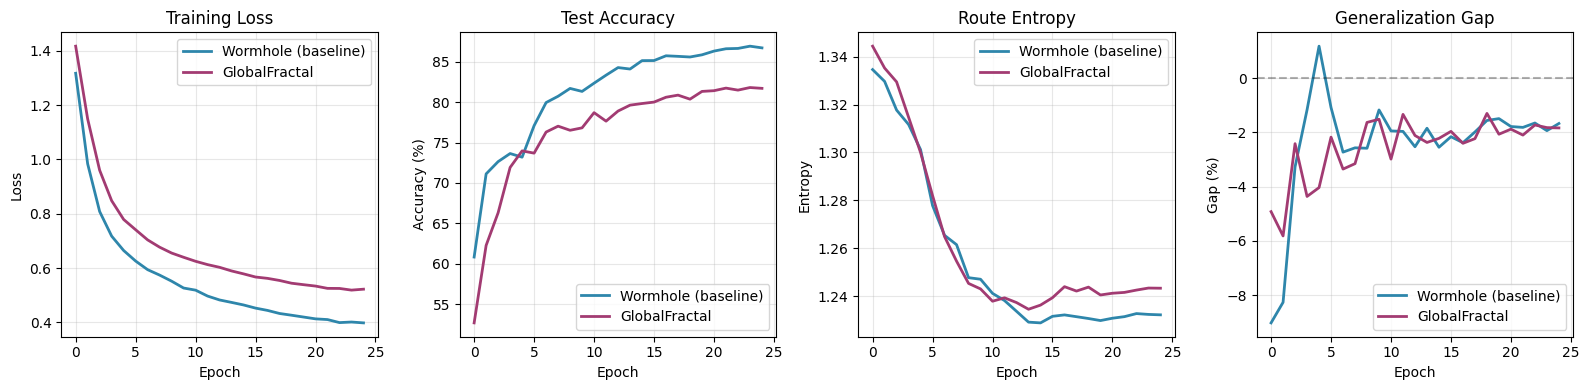


Saved: router_comparison.png


In [9]:
"""
Router Experiments 12/2/2025 - Fashion-MNIST A/B Comparison
============================================================
Baseline WormholeRouter vs GlobalFractalRouter

Imports routers from geofractal.model.blocks.router package.
Run as Colab notebook cell with geofractal repo available.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import time
from dataclasses import dataclass
from typing import Dict, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.wormhole_router import (
    WormholeRouter,
    WormholeRouterConfig,
)
from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    FractalRouterNetwork,
    get_registry,
    RouterMailbox,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class ExperimentConfig:
    # Model
    image_size: int = 28
    patch_size: int = 4
    in_channels: int = 1
    embed_dim: int = 128
    num_heads: int = 4
    num_layers: int = 3
    num_classes: int = 10
    num_routes: int = 4

    # Router specifics
    fingerprint_dim: int = 64
    num_anchors: int = 16
    use_adjacent_gating: bool = True
    use_mailbox: bool = True  # Multi-router coordination

    # Training
    batch_size: int = 128
    epochs: int = 25
    lr: float = 3e-4
    weight_decay: float = 0.01
    warmup_epochs: int = 3

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# =============================================================================
# ROUTER WRAPPERS (uniform interface)
# =============================================================================

class WormholeRouterWrapper(nn.Module):
    """Wraps WormholeRouter with uniform interface."""

    def __init__(self, config: ExperimentConfig):
        super().__init__()
        self.config = config

        router_config = WormholeRouterConfig(
            dim=config.embed_dim,
            num_positions=config.num_patches,
            num_wormholes=config.num_routes,
            mode='hybrid',  # Content + Cantor prior
            cantor_weight=0.3,
            learnable_bias=True,
        )

        self.router = WormholeRouter(router_config)
        self.value_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.out_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B, S, D = x.shape

        cls_token = x[:, :1, :]
        patches = x[:, 1:, :]

        # Get routes (returns routes, weights, scores)
        routes, weights, _ = self.router(x, skip_first=True, return_scores=False)

        # Gather and combine
        P = patches.shape[1]
        K = routes.shape[-1]
        v = self.value_proj(patches)

        # Use router's gather utility
        v_gathered = self.router.gather(v, routes)  # [B, P, K, D]
        routed = torch.einsum('bpk,bpkd->bpd', weights, v_gathered)

        # Residual + project
        patches = patches + self.out_proj(routed)
        output = torch.cat([cls_token, patches], dim=1)

        # Metrics
        metrics = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
            'routes_mean': routes.float().mean().item(),
        }

        return output, metrics


class GlobalFractalRouterWrapper(nn.Module):
    """Wraps GlobalFractalRouter with uniform interface and optional mailbox."""

    def __init__(self, config: ExperimentConfig, name: str = "router_0"):
        super().__init__()
        self.config = config

        # Reset registry for clean experiment
        get_registry().reset()

        # Build router config
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.embed_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=config.use_adjacent_gating,
            grid_size=(config.grid_size, config.grid_size),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            name=name,
        )

        # Mailbox for multi-router coordination (even with single router, tests the system)
        self.mailbox = RouterMailbox(router_config) if config.use_mailbox else None

    def forward(self, x: torch.Tensor, target_fingerprint: torch.Tensor = None) -> Tuple[torch.Tensor, Dict]:
        # Clear mailbox each forward
        if self.mailbox is not None:
            self.mailbox.clear()

        # Forward through router
        routes, weights, features = self.router(
            x,
            mailbox=self.mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=True,
        )

        # Metrics
        metrics = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
            'routes_mean': routes.float().mean().item(),
        }

        # Add anchor metrics if available
        if hasattr(self.router, 'anchor_bank'):
            # We'd need to capture this from forward - for now skip
            pass

        return features, metrics


class MultiRouterWrapper(nn.Module):
    """Multiple GlobalFractalRouters with mailbox coordination."""

    def __init__(self, config: ExperimentConfig, num_routers: int = 2, topology: str = "chain"):
        super().__init__()
        self.config = config
        self.num_routers = num_routers

        get_registry().reset()

        router_config = GlobalFractalRouterConfig(
            feature_dim=config.embed_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=config.use_adjacent_gating,
            grid_size=(config.grid_size, config.grid_size),
        )

        self.network = FractalRouterNetwork(
            config=router_config,
            num_routers=num_routers,
            topology=topology,
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        # Network handles mailbox internally
        outputs = self.network(x, return_all=True)

        # Final output
        features = outputs[-1][2]  # Last router's features

        # Aggregate metrics across routers
        all_weights = [o[1] for o in outputs]
        entropies = [-(w * (w + 1e-8).log()).sum(dim=-1).mean().item() for w in all_weights]

        metrics = {
            'route_entropy': sum(entropies) / len(entropies),
            'route_entropy_std': torch.tensor(entropies).std().item() if len(entropies) > 1 else 0,
            'num_routers': self.num_routers,
        }

        return features, metrics


# =============================================================================
# VISION TRANSFORMER
# =============================================================================

class PatchEmbed(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x).flatten(2).transpose(1, 2)


class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class RouterViT(nn.Module):
    """ViT with pluggable router."""

    def __init__(self, config: ExperimentConfig, router_type: str = "wormhole"):
        super().__init__()
        self.config = config
        self.router_type = router_type

        # Patch embedding
        self.patch_embed = PatchEmbed(
            config.image_size, config.patch_size,
            config.in_channels, config.embed_dim
        )

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, config.num_patches + 1, config.embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        # Router selection
        if router_type == "wormhole":
            self.router = WormholeRouterWrapper(config)
        elif router_type == "global_fractal":
            self.router = GlobalFractalRouterWrapper(config, name="single_router")
        elif router_type == "multi_fractal":
            self.router = MultiRouterWrapper(config, num_routers=2, topology="chain")
        else:
            raise ValueError(f"Unknown router type: {router_type}")

        # Transformer layers
        self.blocks = nn.ModuleList([
            TransformerBlock(config.embed_dim, config.num_heads)
            for _ in range(config.num_layers)
        ])

        # Head
        self.norm = nn.LayerNorm(config.embed_dim)
        self.head = nn.Linear(config.embed_dim, config.num_classes)

        # Init
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B = x.shape[0]

        # Embed patches
        x = self.patch_embed(x)

        # Add CLS + pos
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_drop(x + self.pos_embed)

        # Route
        x, router_metrics = self.router(x)

        # Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classify from CLS
        x = self.norm(x[:, 0])
        logits = self.head(x)

        return logits, router_metrics


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: ExperimentConfig):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    metrics_accum = defaultdict(float)

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, metrics = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

        for k, v in metrics.items():
            metrics_accum[k] += v

    scheduler.step()

    avg_metrics = {k: v / len(loader) for k, v in metrics_accum.items()}
    return total_loss / total, correct / total, avg_metrics


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    metrics_accum = defaultdict(float)

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits, metrics = model(imgs)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

        for k, v in metrics.items():
            metrics_accum[k] += v

    avg_metrics = {k: v / len(loader) for k, v in metrics_accum.items()}
    return correct / total, avg_metrics


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def run_experiment(router_type: str, config: ExperimentConfig):
    print(f"\n{'='*60}")
    print(f"  Router: {router_type.upper()}")
    print(f"{'='*60}")

    # Build model
    model = RouterViT(config, router_type=router_type).to(config.device)
    print(f"Parameters: {count_params(model):,}")

    # Count router params specifically
    router_params = count_params(model.router)
    print(f"Router parameters: {router_params:,}")

    # Data
    train_loader, test_loader = get_dataloaders(config)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    # Scheduler
    def lr_lambda(epoch):
        if epoch < config.warmup_epochs:
            return (epoch + 1) / config.warmup_epochs
        progress = (epoch - config.warmup_epochs) / (config.epochs - config.warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'route_entropy': [],
        'lr': [],
    }

    best_acc = 0
    start_time = time.time()

    for epoch in range(config.epochs):
        train_loss, train_acc, train_metrics = train_epoch(
            model, train_loader, optimizer, scheduler, config.device
        )
        test_acc, test_metrics = evaluate(model, test_loader, config.device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['route_entropy'].append(train_metrics.get('route_entropy', 0))
        history['lr'].append(optimizer.param_groups[0]['lr'])

        if test_acc > best_acc:
            best_acc = test_acc

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {train_loss:.4f} | Train: {train_acc*100:.2f}% | "
                  f"Test: {test_acc*100:.2f}% | Entropy: {train_metrics.get('route_entropy', 0):.3f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    elapsed = time.time() - start_time
    print(f"\nBest Test Accuracy: {best_acc*100:.2f}%")
    print(f"Training Time: {elapsed:.1f}s ({elapsed/config.epochs:.2f}s/epoch)")

    return model, history, best_acc


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_comparison(results: Dict[str, Dict], save_path: str = "router_comparison.png"):
    n_metrics = 4
    fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4))

    colors = {
        'wormhole': '#2E86AB',
        'global_fractal': '#A23B72',
        'multi_fractal': '#F18F01',
    }
    labels = {
        'wormhole': 'Wormhole (baseline)',
        'global_fractal': 'GlobalFractal',
        'multi_fractal': 'MultiFractal (2x chain)',
    }

    # Train Loss
    ax = axes[0]
    for name, data in results.items():
        ax.plot(data['train_loss'], label=labels.get(name, name),
                color=colors.get(name, 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Test Accuracy
    ax = axes[1]
    for name, data in results.items():
        ax.plot([a * 100 for a in data['test_acc']], label=labels.get(name, name),
                color=colors.get(name, 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Test Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Route Entropy
    ax = axes[2]
    for name, data in results.items():
        ax.plot(data['route_entropy'], label=labels.get(name, name),
                color=colors.get(name, 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Route Entropy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Train vs Test gap
    ax = axes[3]
    for name, data in results.items():
        gap = [t - v for t, v in zip(data['train_acc'], data['test_acc'])]
        ax.plot([g * 100 for g in gap], label=labels.get(name, name),
                color=colors.get(name, 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gap (%)')
    ax.set_title('Generalization Gap')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


def print_summary(results: Dict, best_accs: Dict):
    print("\n" + "="*60)
    print("  FINAL RESULTS")
    print("="*60)

    # Sort by accuracy
    sorted_results = sorted(best_accs.items(), key=lambda x: -x[1])

    for name, acc in sorted_results:
        print(f"  {name:20s}: {acc*100:.2f}%")

    if len(sorted_results) >= 2:
        best_name, best_acc = sorted_results[0]
        baseline_acc = best_accs.get('wormhole', sorted_results[-1][1])
        diff = (best_acc - baseline_acc) * 100
        print(f"\n  Δ (best - wormhole): {diff:+.2f}%")

    print("="*60)


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*60)
    print("  Router Experiments 12/2/2025")
    print("  Fashion-MNIST Comparison")
    print("="*60)

    config = ExperimentConfig()

    print(f"\nConfig:")
    print(f"  Image: {config.image_size}x{config.image_size}")
    print(f"  Patches: {config.num_patches} ({config.grid_size}x{config.grid_size})")
    print(f"  Embed: {config.embed_dim}, Heads: {config.num_heads}, Layers: {config.num_layers}")
    print(f"  Routes: {config.num_routes}")
    print(f"  Epochs: {config.epochs}, LR: {config.lr}")
    print(f"  Device: {config.device}")

    results = {}
    best_accs = {}

    # =========================================================================
    # EXPERIMENTS TO RUN
    # =========================================================================

    router_types = [
        "wormhole",       # Baseline
        "global_fractal", # Single GlobalFractalRouter
        # "multi_fractal",  # 2-router chain (uncomment to test)
    ]

    for router_type in router_types:
        try:
            _, history, best_acc = run_experiment(router_type, config)
            results[router_type] = history
            best_accs[router_type] = best_acc
        except Exception as e:
            print(f"Error running {router_type}: {e}")
            import traceback
            traceback.print_exc()

    # Summary and plots
    if results:
        print_summary(results, best_accs)
        plot_comparison(results)

    return results, best_accs


# =============================================================================
# RUN
# =============================================================================

if __name__ == "__main__":
    results, best_accs = main()

# global fractal router ablation

  GlobalFractalRouter Ablation Study
  Fashion-MNIST

Experiment Config:
  Embed: 128, Layers: 3, Routes: 4
  Epochs: 25, LR: 0.0003
  Device: cuda

Running 5 ablations: ['full', 'no_gating', 'no_cantor', 'no_gating_no_cantor', 'minimal']

  Ablation: FULL
  gating=True, mailbox=True, anchors=16, cantor=True
Parameters: 825,362 (router: 220,296)
Epoch   1 | Loss: 1.4142 | Train: 48.20% | Test: 57.18% | Entropy: 1.335
Epoch   5 | Loss: 0.7668 | Train: 70.72% | Test: 71.49% | Entropy: 1.292
Epoch  10 | Loss: 0.6374 | Train: 75.57% | Test: 77.38% | Entropy: 1.270
Epoch  15 | Loss: 0.5757 | Train: 77.90% | Test: 79.89% | Entropy: 1.269
Epoch  20 | Loss: 0.5339 | Train: 79.47% | Test: 80.89% | Entropy: 1.274
Epoch  25 | Loss: 0.5153 | Train: 80.06% | Test: 81.43% | Entropy: 1.278

Best: 81.47% | Time: 322.1s

  Ablation: NO_GATING
  gating=False, mailbox=True, anchors=16, cantor=True
Parameters: 722,826 (router: 117,760)
Epoch   1 | Loss: 1.3868 | Train: 49.30% | Test: 56.44% | Entropy: 1.3

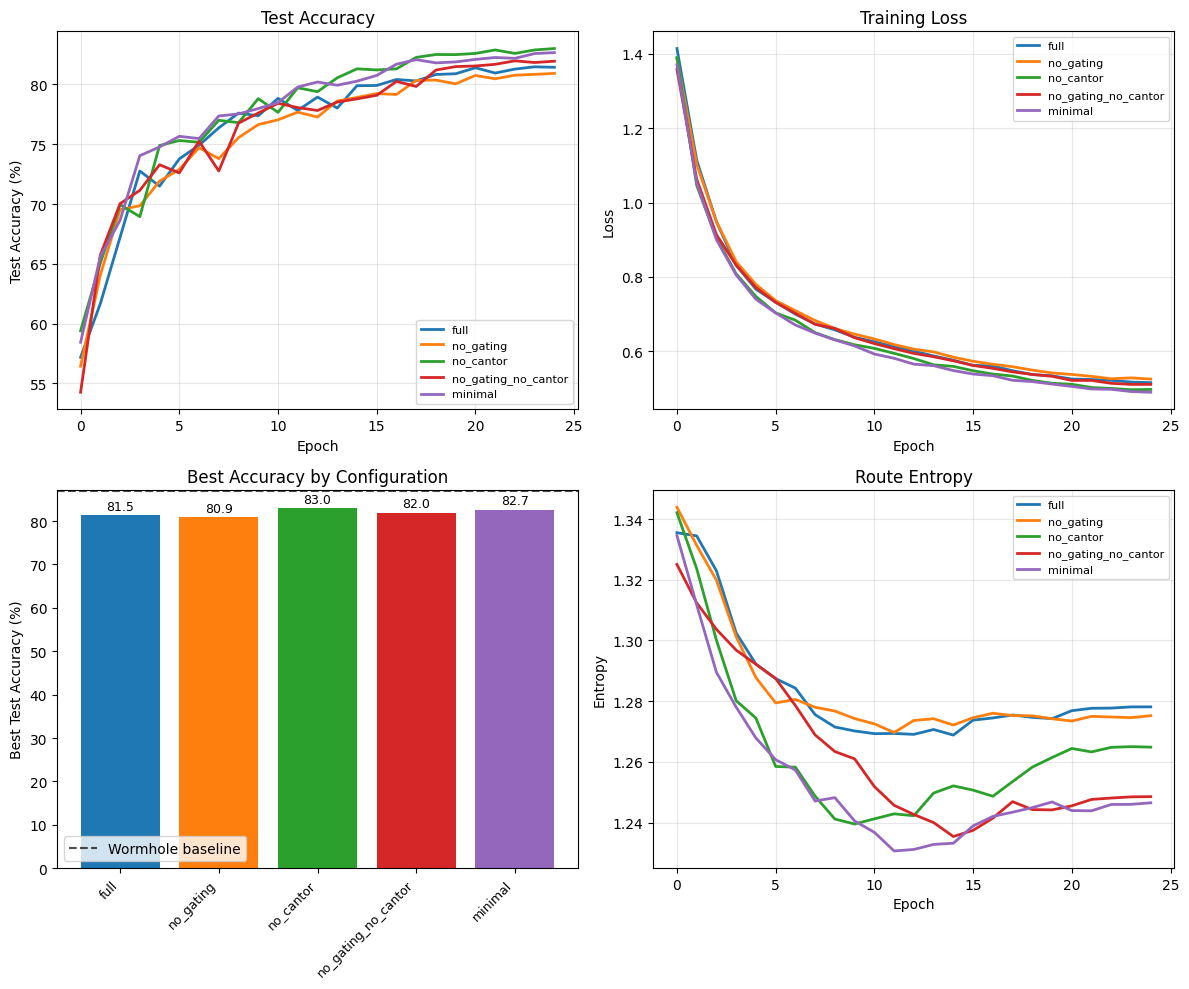


Saved: ablation_results.png


In [10]:
"""
Router Experiments 12/2/2025 - GlobalFractalRouter Ablation Study
==================================================================
Find which components help/hurt on Fashion-MNIST

Ablations:
1. Baseline (all features on)
2. No adjacent gating
3. No mailbox
4. Minimal anchors
5. No Cantor prior
6. Kitchen sink off (minimal)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import time
from dataclasses import dataclass, field
from typing import Dict, Tuple, List
from collections import defaultdict
import matplotlib.pyplot as plt

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    get_registry,
    RouterMailbox,
)

# =============================================================================
# ABLATION CONFIGS
# =============================================================================

@dataclass
class AblationConfig:
    """Single ablation configuration."""
    name: str
    use_adjacent_gating: bool = True
    use_mailbox: bool = True
    num_anchors: int = 16
    use_cantor_prior: bool = True
    cantor_weight: float = 0.2
    fingerprint_dim: int = 64
    gate_hidden_dim: int = 256
    num_potential_fields: int = 4


# Define ablations to run
ABLATIONS = [
    AblationConfig(
        name="full",
        use_adjacent_gating=True,
        use_mailbox=True,
        num_anchors=16,
        use_cantor_prior=True,
    ),
    AblationConfig(
        name="no_gating",
        use_adjacent_gating=False,
        use_mailbox=True,
        num_anchors=16,
        use_cantor_prior=True,
    ),
    AblationConfig(
        name="no_mailbox",
        use_adjacent_gating=True,
        use_mailbox=False,
        num_anchors=16,
        use_cantor_prior=True,
    ),
    AblationConfig(
        name="no_cantor",
        use_adjacent_gating=True,
        use_mailbox=True,
        num_anchors=16,
        use_cantor_prior=False,
    ),
    AblationConfig(
        name="minimal_anchors",
        use_adjacent_gating=True,
        use_mailbox=True,
        num_anchors=4,
        use_cantor_prior=True,
    ),
    AblationConfig(
        name="no_gating_no_cantor",
        use_adjacent_gating=False,
        use_mailbox=True,
        num_anchors=16,
        use_cantor_prior=False,
    ),
    AblationConfig(
        name="minimal",
        use_adjacent_gating=False,
        use_mailbox=False,
        num_anchors=4,
        use_cantor_prior=False,
    ),
]


# =============================================================================
# EXPERIMENT CONFIG
# =============================================================================

@dataclass
class ExperimentConfig:
    # Model
    image_size: int = 28
    patch_size: int = 4
    in_channels: int = 1
    embed_dim: int = 128
    num_heads: int = 4
    num_layers: int = 3
    num_classes: int = 10
    num_routes: int = 4

    # Training
    batch_size: int = 128
    epochs: int = 25
    lr: float = 3e-4
    weight_decay: float = 0.01
    warmup_epochs: int = 3

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# =============================================================================
# ROUTER WRAPPER
# =============================================================================

class AblatedGlobalFractalRouter(nn.Module):
    """GlobalFractalRouter with ablation controls."""

    def __init__(self, exp_config: ExperimentConfig, abl_config: AblationConfig):
        super().__init__()
        self.exp_config = exp_config
        self.abl_config = abl_config

        get_registry().reset()

        router_config = GlobalFractalRouterConfig(
            feature_dim=exp_config.embed_dim,
            fingerprint_dim=abl_config.fingerprint_dim,
            num_anchors=abl_config.num_anchors,
            num_routes=exp_config.num_routes,
            use_adjacent_gating=abl_config.use_adjacent_gating,
            gate_hidden_dim=abl_config.gate_hidden_dim,
            num_potential_fields=abl_config.num_potential_fields,
            use_cantor_prior=abl_config.use_cantor_prior,
            cantor_weight=abl_config.cantor_weight,
            grid_size=(exp_config.grid_size, exp_config.grid_size),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            name=f"router_{abl_config.name}",
        )

        self.mailbox = RouterMailbox(router_config) if abl_config.use_mailbox else None

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        if self.mailbox is not None:
            self.mailbox.clear()

        routes, weights, features = self.router(
            x,
            mailbox=self.mailbox,
            target_fingerprint=None,
            skip_first=True,
        )

        metrics = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return features, metrics


# =============================================================================
# VISION TRANSFORMER
# =============================================================================

class PatchEmbed(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x).flatten(2).transpose(1, 2)


class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class AblationViT(nn.Module):
    """ViT with ablated GlobalFractalRouter."""

    def __init__(self, exp_config: ExperimentConfig, abl_config: AblationConfig):
        super().__init__()
        self.exp_config = exp_config
        self.abl_config = abl_config

        self.patch_embed = PatchEmbed(
            exp_config.image_size, exp_config.patch_size,
            exp_config.in_channels, exp_config.embed_dim
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, exp_config.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, exp_config.num_patches + 1, exp_config.embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.router = AblatedGlobalFractalRouter(exp_config, abl_config)

        self.blocks = nn.ModuleList([
            TransformerBlock(exp_config.embed_dim, exp_config.num_heads)
            for _ in range(exp_config.num_layers)
        ])

        self.norm = nn.LayerNorm(exp_config.embed_dim)
        self.head = nn.Linear(exp_config.embed_dim, exp_config.num_classes)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B = x.shape[0]

        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_drop(x + self.pos_embed)

        x, router_metrics = self.router(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])
        logits = self.head(x)

        return logits, router_metrics


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: ExperimentConfig):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    metrics_accum = defaultdict(float)

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, metrics = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

        for k, v in metrics.items():
            metrics_accum[k] += v

    scheduler.step()

    avg_metrics = {k: v / len(loader) for k, v in metrics_accum.items()}
    return total_loss / total, correct / total, avg_metrics


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits, _ = model(imgs)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

    return correct / total


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def run_ablation(abl_config: AblationConfig, exp_config: ExperimentConfig, verbose: bool = True):
    """Run single ablation experiment."""

    if verbose:
        print(f"\n{'='*60}")
        print(f"  Ablation: {abl_config.name.upper()}")
        print(f"  gating={abl_config.use_adjacent_gating}, mailbox={abl_config.use_mailbox}, "
              f"anchors={abl_config.num_anchors}, cantor={abl_config.use_cantor_prior}")
        print(f"{'='*60}")

    model = AblationViT(exp_config, abl_config).to(exp_config.device)

    total_params = count_params(model)
    router_params = count_params(model.router)
    if verbose:
        print(f"Parameters: {total_params:,} (router: {router_params:,})")

    train_loader, test_loader = get_dataloaders(exp_config)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=exp_config.lr,
        weight_decay=exp_config.weight_decay,
    )

    def lr_lambda(epoch):
        if epoch < exp_config.warmup_epochs:
            return (epoch + 1) / exp_config.warmup_epochs
        progress = (epoch - exp_config.warmup_epochs) / (exp_config.epochs - exp_config.warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'route_entropy': [],
    }

    best_acc = 0
    start_time = time.time()

    for epoch in range(exp_config.epochs):
        train_loss, train_acc, train_metrics = train_epoch(
            model, train_loader, optimizer, scheduler, exp_config.device
        )
        test_acc = evaluate(model, test_loader, exp_config.device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['route_entropy'].append(train_metrics.get('route_entropy', 0))

        if test_acc > best_acc:
            best_acc = test_acc

        if verbose and ((epoch + 1) % 5 == 0 or epoch == 0):
            print(f"Epoch {epoch+1:3d} | Loss: {train_loss:.4f} | Train: {train_acc*100:.2f}% | "
                  f"Test: {test_acc*100:.2f}% | Entropy: {train_metrics.get('route_entropy', 0):.3f}")

    elapsed = time.time() - start_time

    if verbose:
        print(f"\nBest: {best_acc*100:.2f}% | Time: {elapsed:.1f}s")

    return {
        'name': abl_config.name,
        'config': abl_config,
        'best_acc': best_acc,
        'final_acc': history['test_acc'][-1],
        'history': history,
        'params': total_params,
        'router_params': router_params,
        'time': elapsed,
    }


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_ablation_results(results: List[Dict], save_path: str = "ablation_results.png"):
    """Plot comparison of all ablations."""

    n_ablations = len(results)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Color palette
    colors = plt.cm.tab10(range(n_ablations))

    # 1. Test accuracy curves
    ax = axes[0, 0]
    for i, r in enumerate(results):
        ax.plot([a * 100 for a in r['history']['test_acc']],
                label=r['name'], color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Test Accuracy')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

    # 2. Training loss curves
    ax = axes[0, 1]
    for i, r in enumerate(results):
        ax.plot(r['history']['train_loss'],
                label=r['name'], color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    # 3. Final accuracy bar chart
    ax = axes[1, 0]
    names = [r['name'] for r in results]
    accs = [r['best_acc'] * 100 for r in results]
    bars = ax.bar(range(len(names)), accs, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Best Test Accuracy (%)')
    ax.set_title('Best Accuracy by Configuration')
    ax.axhline(y=86.93, color='black', linestyle='--', alpha=0.7, label='Wormhole baseline')
    ax.legend()

    # Add value labels on bars
    for bar, acc in zip(bars, accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.1f}', ha='center', va='bottom', fontsize=9)

    # 4. Route entropy curves
    ax = axes[1, 1]
    for i, r in enumerate(results):
        ax.plot(r['history']['route_entropy'],
                label=r['name'], color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Route Entropy')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


def print_summary_table(results: List[Dict], baseline_acc: float = 0.8693):
    """Print summary table."""

    print("\n" + "="*80)
    print("  ABLATION SUMMARY")
    print("="*80)
    print(f"{'Config':<25} {'Best Acc':>10} {'Δ Baseline':>12} {'Router Params':>14} {'Time':>8}")
    print("-"*80)

    # Sort by accuracy
    sorted_results = sorted(results, key=lambda x: -x['best_acc'])

    for r in sorted_results:
        delta = (r['best_acc'] - baseline_acc) * 100
        delta_str = f"{delta:+.2f}%"
        print(f"{r['name']:<25} {r['best_acc']*100:>9.2f}% {delta_str:>12} {r['router_params']:>14,} {r['time']:>7.1f}s")

    print("-"*80)
    print(f"{'Wormhole (baseline)':<25} {baseline_acc*100:>9.2f}%")
    print("="*80)

    # Best config
    best = sorted_results[0]
    print(f"\nBest config: {best['name']} ({best['best_acc']*100:.2f}%)")
    print(f"  gating={best['config'].use_adjacent_gating}, mailbox={best['config'].use_mailbox}, "
          f"anchors={best['config'].num_anchors}, cantor={best['config'].use_cantor_prior}")


# =============================================================================
# MAIN
# =============================================================================

def main(ablations_to_run: List[str] = None):
    """
    Run ablation study.

    Args:
        ablations_to_run: List of ablation names to run, or None for all.
                         Options: 'full', 'no_gating', 'no_mailbox', 'no_cantor',
                                  'minimal_anchors', 'no_gating_no_cantor', 'minimal'
    """
    print("="*60)
    print("  GlobalFractalRouter Ablation Study")
    print("  Fashion-MNIST")
    print("="*60)

    exp_config = ExperimentConfig()

    print(f"\nExperiment Config:")
    print(f"  Embed: {exp_config.embed_dim}, Layers: {exp_config.num_layers}, Routes: {exp_config.num_routes}")
    print(f"  Epochs: {exp_config.epochs}, LR: {exp_config.lr}")
    print(f"  Device: {exp_config.device}")

    # Filter ablations
    if ablations_to_run is None:
        ablations = ABLATIONS
    else:
        ablations = [a for a in ABLATIONS if a.name in ablations_to_run]

    print(f"\nRunning {len(ablations)} ablations: {[a.name for a in ablations]}")

    results = []
    for abl_config in ablations:
        result = run_ablation(abl_config, exp_config, verbose=True)
        results.append(result)

    # Summary
    print_summary_table(results)
    plot_ablation_results(results)

    return results


# =============================================================================
# RUN
# =============================================================================

if __name__ == "__main__":
    # =========================================================================
    # CONFIGURE WHICH ABLATIONS TO RUN
    # =========================================================================

    # Run all ablations (takes ~45 min with 7 configs × 25 epochs)
    # results = main()

    # Or run specific subset:
    results = main(ablations_to_run=[
        'full',              # All features (baseline GlobalFractal)
        'no_gating',         # Disable adjacent gating
        'no_cantor',         # Disable Cantor geometric prior
        'no_gating_no_cantor',  # Both off
        'minimal',           # Everything stripped
    ])

# multi-router test

  Multi-Router Divergent Heads Experiment
  Fashion-MNIST

Config:
  Embed: 128, Layers: 3
  Routers: 2 (chain)
  Theta dim: 32, injection: additive
  Divergence weight: 0.1
  Device: cuda

Parameters: 1,051,460

  Training
Epoch   1 | Loss: 2.8794 | Acc0: 47.12% | Acc1: 47.00% | Agreement: 92.7%
Epoch   5 | Loss: 1.7245 | Acc0: 68.78% | Acc1: 68.93% | Agreement: 98.5%
Epoch  10 | Loss: 1.3619 | Acc0: 73.72% | Acc1: 73.59% | Agreement: 98.7%
Epoch  15 | Loss: 1.2008 | Acc0: 76.96% | Acc1: 76.90% | Agreement: 98.8%
Epoch  20 | Loss: 1.1108 | Acc0: 78.96% | Acc1: 78.92% | Agreement: 99.1%
Epoch  25 | Loss: 1.0749 | Acc0: 79.04% | Acc1: 78.98% | Agreement: 99.3%

  FINAL RESULTS
  Head 0 (no θ):   79.04%
  Head 1 (with θ): 78.98%
  Agreement:       99.3%
  Disagreements:   66 / 10000


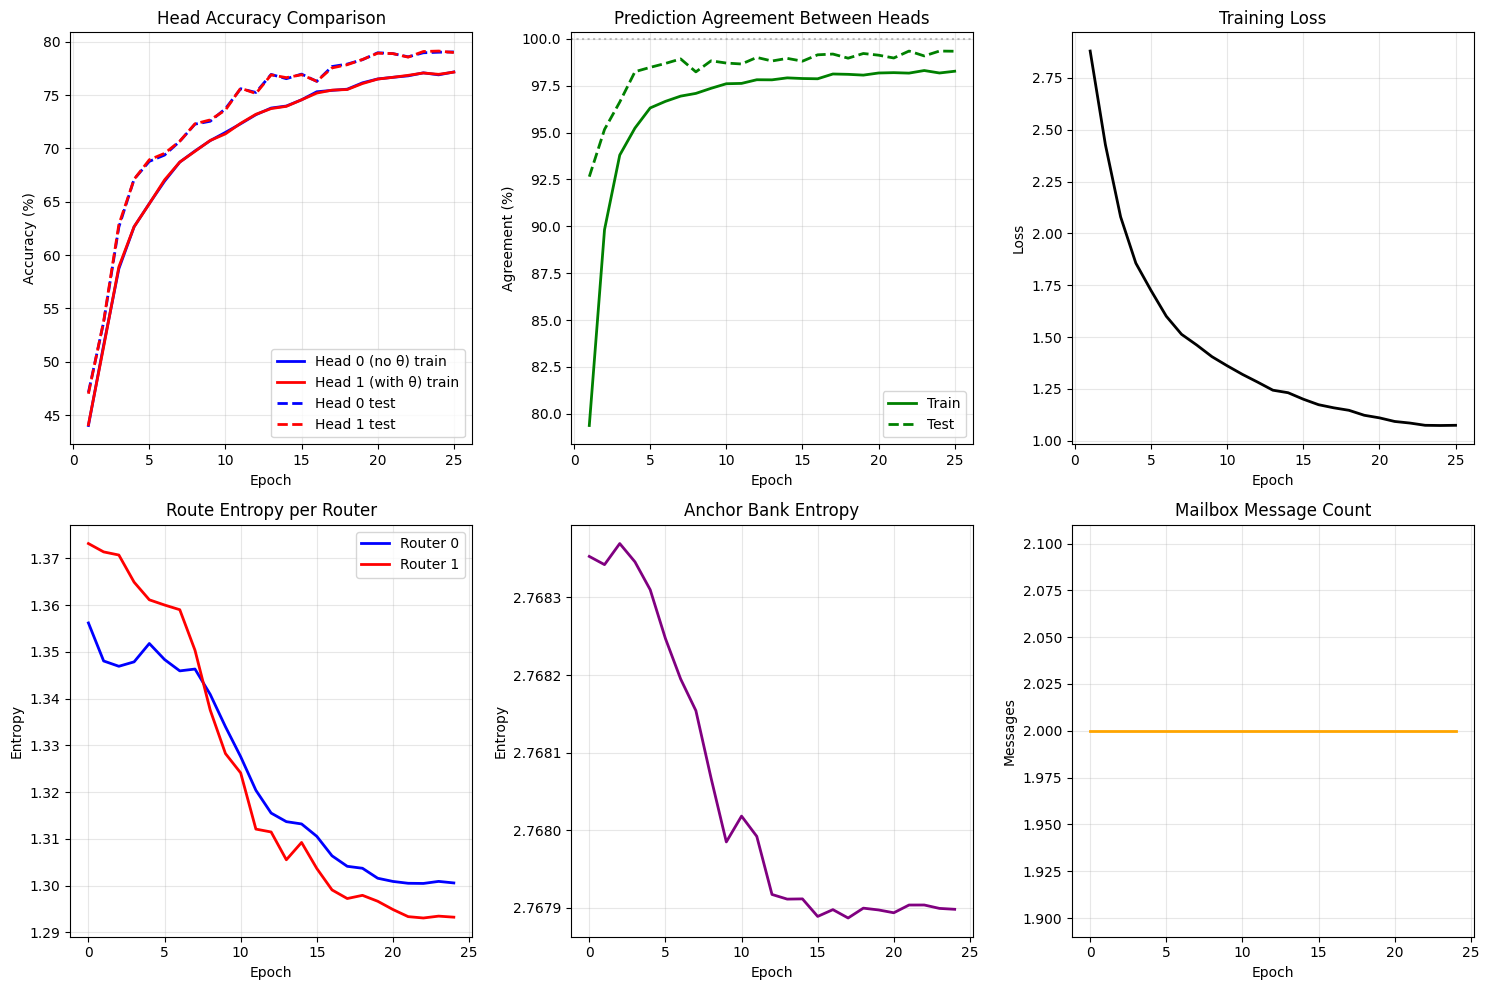

Saved: multi_router_training.png


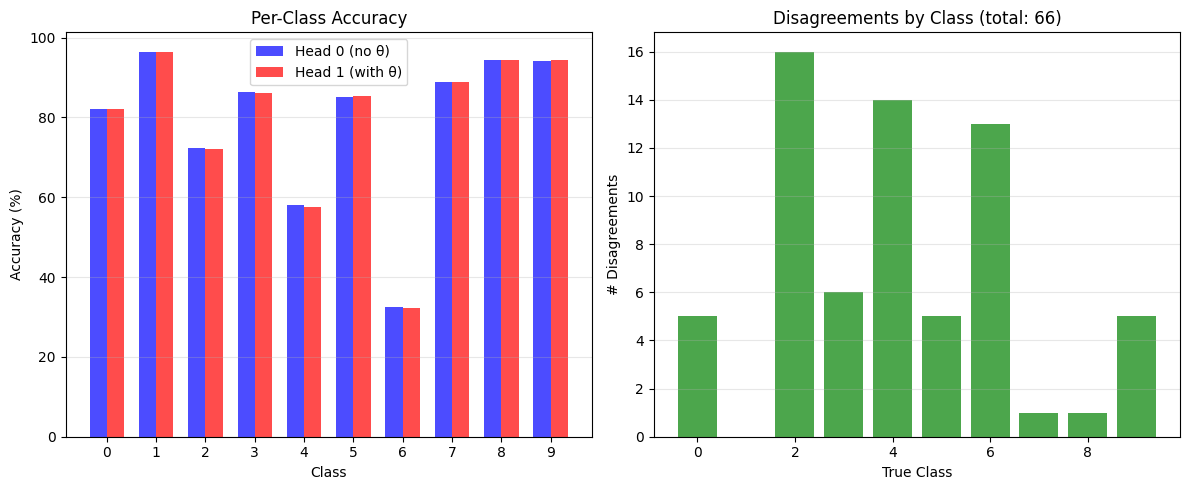

Saved: confusion_comparison.png

  ACTIVATION SUMMARY
  route_entropy_head0: 1.3006 (final), 1.3235 (mean)
  route_entropy_head1: 1.2933 (final), 1.3241 (mean)
  mailbox_count: 2.0000 (final), 2.0000 (mean)
  anchor_entropy: 2.7679 (final), 2.7680 (mean)
  anchor_top: 5.0045 (final), 5.0857 (mean)
  divergence_loss: 0.9993 (final), 0.9981 (mean)
  prediction_agreement: 0.9841 (final), 0.9579 (mean)


In [11]:
"""
Router Experiments 12/2/2025 - Multi-Router Divergent Heads
============================================================
Two classification heads share router backbone but diverge via theta.
Tests whether fingerprint coordination actually helps.

Logs activations of:
- Anchor bank affinities
- Adjacent gate values
- Mailbox message flow
- Route patterns per head
- Fingerprint evolution
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import time
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    FractalRouterNetwork,
    get_registry,
    RouterMailbox,
    AnchorBank,
)

# =============================================================================
# ACTIVATION LOGGER
# =============================================================================

class ActivationLogger:
    """Logs activations from router components across training."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.logs = {
            # Per-step logs (averaged per epoch)
            'anchor_affinities_head0': [],
            'anchor_affinities_head1': [],
            'anchor_entropy_head0': [],
            'anchor_entropy_head1': [],
            'gate_values_head0': [],
            'gate_values_head1': [],
            'route_entropy_head0': [],
            'route_entropy_head1': [],
            'route_overlap': [],  # How similar are routes between heads
            'mailbox_message_count': [],
            'fingerprint_similarities': [],

            # Epoch-level aggregates
            'epoch_anchor_usage_head0': [],
            'epoch_anchor_usage_head1': [],
            'epoch_route_divergence': [],
            'epoch_prediction_agreement': [],
        }
        self._step_buffer = defaultdict(list)

    def log_step(self, key: str, value: float):
        """Log a value for current step."""
        self._step_buffer[key].append(value)

    def log_tensor(self, key: str, tensor: torch.Tensor):
        """Log tensor statistics."""
        if tensor is not None:
            self._step_buffer[f'{key}_mean'].append(tensor.mean().item())
            self._step_buffer[f'{key}_std'].append(tensor.std().item())

    def end_epoch(self):
        """Aggregate step logs into epoch logs."""
        for key, values in self._step_buffer.items():
            if values:
                self.logs.setdefault(key, []).append(sum(values) / len(values))
        self._step_buffer.clear()

    def get_logs(self) -> Dict:
        return self.logs


# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class MultiRouterConfig:
    # Model
    image_size: int = 28
    patch_size: int = 4
    in_channels: int = 1
    embed_dim: int = 128
    num_heads: int = 4
    num_layers: int = 3
    num_classes: int = 10
    num_routes: int = 4

    # Router
    num_routers: int = 2  # Routers in the shared backbone
    fingerprint_dim: int = 64
    num_anchors: int = 16
    use_adjacent_gating: bool = True
    router_topology: str = "chain"  # chain, parallel

    # Theta (divergence parameter)
    theta_dim: int = 32
    theta_injection: str = "additive"  # additive, multiplicative, gating

    # Training
    batch_size: int = 128
    epochs: int = 25
    lr: float = 3e-4
    weight_decay: float = 0.01
    warmup_epochs: int = 3

    # Divergence loss weight
    divergence_weight: float = 0.1  # Encourage different predictions

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# =============================================================================
# THETA-CONDITIONED HEAD
# =============================================================================

class ThetaHead(nn.Module):
    """
    Classification head conditioned on theta parameter.
    Theta creates divergent behavior between heads.
    """

    def __init__(
        self,
        embed_dim: int,
        num_classes: int,
        theta_dim: int,
        injection: str = "additive",
        has_theta: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.has_theta = has_theta
        self.injection = injection

        if has_theta:
            # Learnable theta parameter
            self.theta = nn.Parameter(torch.randn(theta_dim) * 0.02)

            if injection == "additive":
                self.theta_proj = nn.Linear(theta_dim, embed_dim)
            elif injection == "multiplicative":
                self.theta_proj = nn.Linear(theta_dim, embed_dim)
            elif injection == "gating":
                self.theta_gate = nn.Sequential(
                    nn.Linear(theta_dim, embed_dim),
                    nn.Sigmoid(),
                )

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, D] CLS token features
        Returns:
            logits: [B, num_classes]
            info: Dict with theta influence metrics
        """
        info = {}

        if self.has_theta:
            if self.injection == "additive":
                theta_contrib = self.theta_proj(self.theta)
                x = x + theta_contrib
                info['theta_norm'] = theta_contrib.norm().item()

            elif self.injection == "multiplicative":
                theta_scale = self.theta_proj(self.theta).sigmoid()
                x = x * (1 + theta_scale)
                info['theta_scale_mean'] = theta_scale.mean().item()

            elif self.injection == "gating":
                gate = self.theta_gate(self.theta)
                x = x * gate
                info['theta_gate_mean'] = gate.mean().item()

        x = self.norm(x)
        logits = self.head(x)

        return logits, info


# =============================================================================
# MULTI-ROUTER BACKBONE
# =============================================================================

class MultiRouterBackbone(nn.Module):
    """
    Shared backbone with multiple coordinating routers.
    """

    def __init__(self, config: MultiRouterConfig):
        super().__init__()
        self.config = config

        get_registry().reset()

        # Router config
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.embed_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=config.use_adjacent_gating,
            use_cantor_prior=False,  # Based on ablation results
            grid_size=(config.grid_size, config.grid_size),
        )

        # Create routers
        self.routers = nn.ModuleList()
        self.router_ids = []

        for i in range(config.num_routers):
            parent_id = self.router_ids[-1] if i > 0 and config.router_topology == "chain" else None
            router = GlobalFractalRouter(
                config=router_config,
                parent_id=parent_id,
                name=f"backbone_router_{i}",
            )
            self.routers.append(router)
            self.router_ids.append(router.module_id)

        # Shared mailbox
        self.mailbox = RouterMailbox(router_config)

        # Store config for logging
        self.router_config = router_config

    def forward(
        self,
        x: torch.Tensor,
        return_all_features: bool = False,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Forward through all routers with mailbox coordination.

        Returns:
            features: Final features [B, S, D]
            info: Router metrics and activations
        """
        self.mailbox.clear()

        info = {
            'router_metrics': [],
            'anchor_affinities': [],
            'gate_values': [],
            'all_features': [] if return_all_features else None,
        }

        current = x

        for i, router in enumerate(self.routers):
            # Get target fingerprint (next router or None)
            target_fp = None
            if i < len(self.routers) - 1:
                target_fp = self.routers[i + 1].fingerprint

            # Forward with provenance tracking
            routes, weights, features = router(
                current,
                mailbox=self.mailbox,
                target_fingerprint=target_fp,
                skip_first=True,
                return_provenance=False,
            )

            # Log metrics
            route_entropy = -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item()
            info['router_metrics'].append({
                'route_entropy': route_entropy,
                'routes_mean': routes.float().mean().item(),
                'routes_std': routes.float().std().item(),
            })

            # Log anchor affinities if accessible
            if hasattr(router, 'anchor_bank'):
                with torch.no_grad():
                    patches = current[:, 1:, :]
                    aff, _ = router.anchor_bank(patches.mean(dim=1), router.fingerprint)
                    info['anchor_affinities'].append(aff.detach())

            if return_all_features:
                info['all_features'].append(features.detach())

            current = features

        # Log mailbox state
        info['mailbox_count'] = len(self.mailbox.messages)

        # Compute fingerprint similarities between routers
        if len(self.routers) > 1:
            fps = torch.stack([r.fingerprint for r in self.routers])
            sim_matrix = F.cosine_similarity(fps.unsqueeze(0), fps.unsqueeze(1), dim=-1)
            info['fingerprint_sim'] = sim_matrix.detach()

        return current, info


# =============================================================================
# PATCH EMBEDDING & TRANSFORMER
# =============================================================================

class PatchEmbed(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x).flatten(2).transpose(1, 2)


class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


# =============================================================================
# DUAL-HEAD MODEL
# =============================================================================

class DualHeadRouterModel(nn.Module):
    """
    Two classification heads sharing a multi-router backbone.
    Head 0: No theta (baseline)
    Head 1: With theta (divergent)
    """

    def __init__(self, config: MultiRouterConfig):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbed(
            config.image_size, config.patch_size,
            config.in_channels, config.embed_dim
        )

        # Positional embedding
        num_patches = config.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        # Shared multi-router backbone
        self.backbone = MultiRouterBackbone(config)

        # Transformer blocks (after routing)
        self.blocks = nn.ModuleList([
            TransformerBlock(config.embed_dim, config.num_heads)
            for _ in range(config.num_layers)
        ])

        # Dual heads
        self.head0 = ThetaHead(
            config.embed_dim, config.num_classes,
            config.theta_dim, config.theta_injection,
            has_theta=False,  # Baseline head
        )
        self.head1 = ThetaHead(
            config.embed_dim, config.num_classes,
            config.theta_dim, config.theta_injection,
            has_theta=True,  # Theta-conditioned head
        )

        # Init
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        Returns:
            logits0: [B, C] from head without theta
            logits1: [B, C] from head with theta
            info: Activation logs
        """
        B = x.shape[0]

        # Embed
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_drop(x + self.pos_embed)

        # Route through backbone
        x, backbone_info = self.backbone(x)

        # Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Extract CLS token
        cls_features = x[:, 0]

        # Dual heads
        logits0, head0_info = self.head0(cls_features)
        logits1, head1_info = self.head1(cls_features)

        # Aggregate info
        info = {
            'backbone': backbone_info,
            'head0': head0_info,
            'head1': head1_info,
        }

        return logits0, logits1, info


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: MultiRouterConfig):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def divergence_loss(logits0: torch.Tensor, logits1: torch.Tensor) -> torch.Tensor:
    """
    Encourage divergent predictions between heads.
    Uses negative cosine similarity of probability distributions.
    """
    p0 = F.softmax(logits0, dim=-1)
    p1 = F.softmax(logits1, dim=-1)

    # Cosine similarity (we want to minimize this -> maximize divergence)
    sim = F.cosine_similarity(p0, p1, dim=-1).mean()

    return sim  # Positive = similar, we'll subtract this from loss


def train_epoch(
    model: DualHeadRouterModel,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    config: MultiRouterConfig,
    logger: ActivationLogger,
):
    model.train()
    total_loss = 0
    correct0 = correct1 = 0
    total = 0
    agreements = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(config.device), labels.to(config.device)

        optimizer.zero_grad()

        logits0, logits1, info = model(imgs)

        # Classification loss for both heads
        loss0 = F.cross_entropy(logits0, labels)
        loss1 = F.cross_entropy(logits1, labels)

        # Divergence regularization
        div_loss = divergence_loss(logits0, logits1)

        # Total loss (subtract divergence to encourage difference)
        loss = loss0 + loss1 - config.divergence_weight * div_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Metrics
        pred0 = logits0.argmax(dim=1)
        pred1 = logits1.argmax(dim=1)

        total_loss += loss.item() * imgs.size(0)
        correct0 += (pred0 == labels).sum().item()
        correct1 += (pred1 == labels).sum().item()
        agreements += (pred0 == pred1).sum().item()
        total += imgs.size(0)

        # Log activations
        logger.log_step('route_entropy_head0', info['backbone']['router_metrics'][0]['route_entropy'])
        if len(info['backbone']['router_metrics']) > 1:
            logger.log_step('route_entropy_head1', info['backbone']['router_metrics'][1]['route_entropy'])

        logger.log_step('mailbox_count', info['backbone']['mailbox_count'])

        if info['backbone']['anchor_affinities']:
            aff = info['backbone']['anchor_affinities'][0]
            entropy = -(aff * (aff + 1e-8).log()).sum(dim=-1).mean().item()
            logger.log_step('anchor_entropy', entropy)
            logger.log_step('anchor_top', aff.argmax(dim=-1).float().mean().item())

        logger.log_step('divergence_loss', div_loss.item())
        logger.log_step('prediction_agreement', agreements / total)

    scheduler.step()
    logger.end_epoch()

    return {
        'loss': total_loss / total,
        'acc0': correct0 / total,
        'acc1': correct1 / total,
        'agreement': agreements / total,
    }


@torch.no_grad()
def evaluate(model: DualHeadRouterModel, loader: DataLoader, config: MultiRouterConfig):
    model.eval()
    correct0 = correct1 = 0
    total = 0
    agreements = 0

    all_preds0, all_preds1, all_labels = [], [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(config.device), labels.to(config.device)

        logits0, logits1, _ = model(imgs)

        pred0 = logits0.argmax(dim=1)
        pred1 = logits1.argmax(dim=1)

        correct0 += (pred0 == labels).sum().item()
        correct1 += (pred1 == labels).sum().item()
        agreements += (pred0 == pred1).sum().item()
        total += imgs.size(0)

        all_preds0.extend(pred0.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return {
        'acc0': correct0 / total,
        'acc1': correct1 / total,
        'agreement': agreements / total,
        'preds0': np.array(all_preds0),
        'preds1': np.array(all_preds1),
        'labels': np.array(all_labels),
    }


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_training_curves(history: Dict, logger: ActivationLogger, save_path: str = "multi_router_training.png"):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    epochs = range(1, len(history['train_acc0']) + 1)

    # Accuracy comparison
    ax = axes[0, 0]
    ax.plot(epochs, [a*100 for a in history['train_acc0']], 'b-', label='Head 0 (no θ) train', linewidth=2)
    ax.plot(epochs, [a*100 for a in history['train_acc1']], 'r-', label='Head 1 (with θ) train', linewidth=2)
    ax.plot(epochs, [a*100 for a in history['test_acc0']], 'b--', label='Head 0 test', linewidth=2)
    ax.plot(epochs, [a*100 for a in history['test_acc1']], 'r--', label='Head 1 test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Head Accuracy Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Agreement rate
    ax = axes[0, 1]
    ax.plot(epochs, [a*100 for a in history['train_agreement']], 'g-', label='Train', linewidth=2)
    ax.plot(epochs, [a*100 for a in history['test_agreement']], 'g--', label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Agreement (%)')
    ax.set_title('Prediction Agreement Between Heads')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='gray', linestyle=':', alpha=0.5)

    # Loss
    ax = axes[0, 2]
    ax.plot(epochs, history['train_loss'], 'k-', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.grid(True, alpha=0.3)

    # Route entropy
    ax = axes[1, 0]
    logs = logger.get_logs()
    if 'route_entropy_head0' in logs:
        ax.plot(logs['route_entropy_head0'], 'b-', label='Router 0', linewidth=2)
    if 'route_entropy_head1' in logs:
        ax.plot(logs['route_entropy_head1'], 'r-', label='Router 1', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Route Entropy per Router')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Anchor usage
    ax = axes[1, 1]
    if 'anchor_entropy' in logs:
        ax.plot(logs['anchor_entropy'], 'purple', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Anchor Bank Entropy')
    ax.grid(True, alpha=0.3)

    # Mailbox activity
    ax = axes[1, 2]
    if 'mailbox_count' in logs:
        ax.plot(logs['mailbox_count'], 'orange', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Messages')
    ax.set_title('Mailbox Message Count')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


def plot_confusion_comparison(eval_results: Dict, save_path: str = "confusion_comparison.png"):
    """Plot where the two heads disagree."""
    preds0 = eval_results['preds0']
    preds1 = eval_results['preds1']
    labels = eval_results['labels']

    # Disagreement matrix: when heads disagree, what do they predict?
    disagree_mask = preds0 != preds1

    if disagree_mask.sum() == 0:
        print("No disagreements to plot!")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Class-wise accuracy comparison
    ax = axes[0]
    classes = range(10)
    acc0_per_class = [(preds0[labels == c] == c).mean() * 100 for c in classes]
    acc1_per_class = [(preds1[labels == c] == c).mean() * 100 for c in classes]

    x = np.arange(len(classes))
    width = 0.35
    ax.bar(x - width/2, acc0_per_class, width, label='Head 0 (no θ)', color='blue', alpha=0.7)
    ax.bar(x + width/2, acc1_per_class, width, label='Head 1 (with θ)', color='red', alpha=0.7)
    ax.set_xlabel('Class')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-Class Accuracy')
    ax.set_xticks(x)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Disagreement analysis
    ax = axes[1]
    disagree_by_class = [disagree_mask[labels == c].sum() for c in classes]
    ax.bar(classes, disagree_by_class, color='green', alpha=0.7)
    ax.set_xlabel('True Class')
    ax.set_ylabel('# Disagreements')
    ax.set_title(f'Disagreements by Class (total: {disagree_mask.sum()})')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*60)
    print("  Multi-Router Divergent Heads Experiment")
    print("  Fashion-MNIST")
    print("="*60)

    config = MultiRouterConfig(
        num_routers=2,
        theta_dim=32,
        theta_injection="additive",
        divergence_weight=0.1,
        epochs=25,
    )

    print(f"\nConfig:")
    print(f"  Embed: {config.embed_dim}, Layers: {config.num_layers}")
    print(f"  Routers: {config.num_routers} ({config.router_topology})")
    print(f"  Theta dim: {config.theta_dim}, injection: {config.theta_injection}")
    print(f"  Divergence weight: {config.divergence_weight}")
    print(f"  Device: {config.device}")

    # Build model
    model = DualHeadRouterModel(config).to(config.device)
    print(f"\nParameters: {count_params(model):,}")

    # Data
    train_loader, test_loader = get_dataloaders(config)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    def lr_lambda(epoch):
        if epoch < config.warmup_epochs:
            return (epoch + 1) / config.warmup_epochs
        progress = (epoch - config.warmup_epochs) / (config.epochs - config.warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Logger
    logger = ActivationLogger()

    # Training history
    history = {
        'train_loss': [],
        'train_acc0': [],
        'train_acc1': [],
        'train_agreement': [],
        'test_acc0': [],
        'test_acc1': [],
        'test_agreement': [],
    }

    print(f"\n{'='*60}")
    print(f"  Training")
    print(f"{'='*60}")

    for epoch in range(config.epochs):
        train_metrics = train_epoch(model, train_loader, optimizer, scheduler, config, logger)
        test_metrics = evaluate(model, test_loader, config)

        history['train_loss'].append(train_metrics['loss'])
        history['train_acc0'].append(train_metrics['acc0'])
        history['train_acc1'].append(train_metrics['acc1'])
        history['train_agreement'].append(train_metrics['agreement'])
        history['test_acc0'].append(test_metrics['acc0'])
        history['test_acc1'].append(test_metrics['acc1'])
        history['test_agreement'].append(test_metrics['agreement'])

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {train_metrics['loss']:.4f} | "
                  f"Acc0: {test_metrics['acc0']*100:.2f}% | Acc1: {test_metrics['acc1']*100:.2f}% | "
                  f"Agreement: {test_metrics['agreement']*100:.1f}%")

    # Final evaluation
    final_eval = evaluate(model, test_loader, config)

    print(f"\n{'='*60}")
    print(f"  FINAL RESULTS")
    print(f"{'='*60}")
    print(f"  Head 0 (no θ):   {final_eval['acc0']*100:.2f}%")
    print(f"  Head 1 (with θ): {final_eval['acc1']*100:.2f}%")
    print(f"  Agreement:       {final_eval['agreement']*100:.1f}%")
    print(f"  Disagreements:   {(1 - final_eval['agreement']) * 10000:.0f} / 10000")

    # Plots
    plot_training_curves(history, logger)
    plot_confusion_comparison(final_eval)

    # Log summary
    logs = logger.get_logs()
    print(f"\n{'='*60}")
    print(f"  ACTIVATION SUMMARY")
    print(f"{'='*60}")
    for key, values in logs.items():
        if values and not key.startswith('epoch_'):
            print(f"  {key}: {values[-1]:.4f} (final), {sum(values)/len(values):.4f} (mean)")

    return model, history, logger, final_eval


if __name__ == "__main__":
    model, history, logger, final_eval = main()

# experiment 2 - divergent consitutional router

  Constitutive Router Experiment
  Fashion-MNIST

Config:
  Embed: 128, Layers: 3, Routes: 4
  Fingerprint dim: 64, Anchors: 16
  Epochs: 25, LR: 0.0003
  Device: cuda

  Router: WORMHOLE
Parameters: 673,515 (router: 68,449)
Epoch   1 | Loss: 1.2315 | Train: 53.26% | Test: 62.04% | route_entropy: 1.349
Epoch   5 | Loss: 0.6453 | Train: 75.48% | Test: 78.00% | route_entropy: 1.288
Epoch  10 | Loss: 0.5050 | Train: 80.85% | Test: 83.40% | route_entropy: 1.230
Epoch  15 | Loss: 0.4374 | Train: 83.55% | Test: 85.71% | route_entropy: 1.216
Epoch  20 | Loss: 0.3935 | Train: 85.33% | Test: 86.92% | route_entropy: 1.213
Epoch  25 | Loss: 0.3757 | Train: 85.89% | Test: 87.42% | route_entropy: 1.212

Best: 87.42% | Time: 315.3s (12.61s/epoch)

  Router: SPARSE
Parameters: 681,741 (router: 76,675)
Epoch   1 | Loss: 1.2240 | Train: 53.34% | Test: 64.82% | route_entropy: 1.208 | value_gate_mean: 0.500 | cantor_mask_density: 0.288
Epoch   5 | Loss: 0.6519 | Train: 74.89% | Test: 75.00% | route_entro

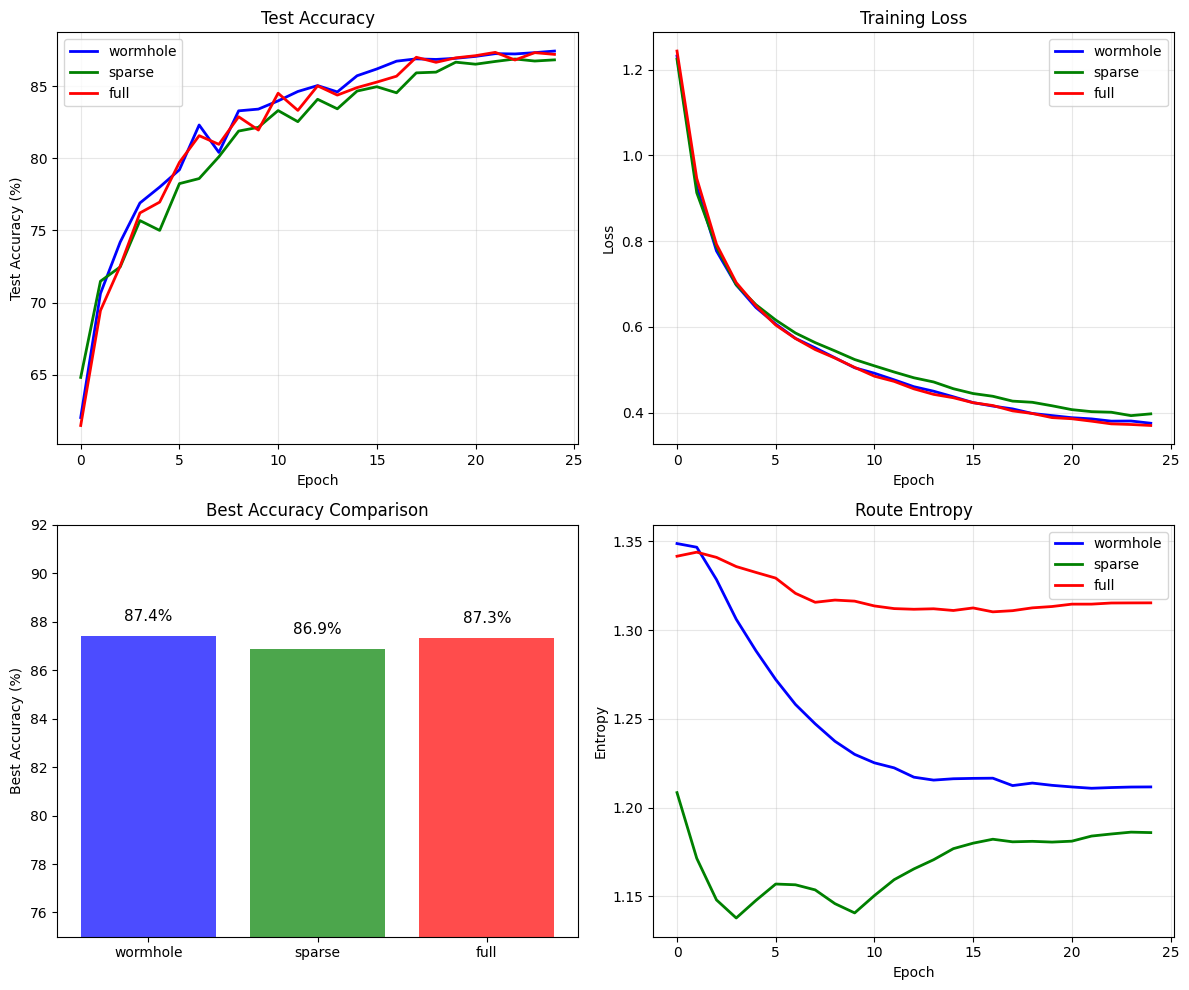


Saved: constitutive_router_results.png


In [2]:
"""
Constitutive Router Experiment - Fashion-MNIST
===============================================
Tests whether making fingerprint CONSTITUTIVE (not additive) fixes the gap.

Sparse: Fingerprint gates values, Cantor masks connectivity
Full: Fingerprint shapes Q/K/V projections, anchors contribute to output

Compares against WormholeRouter baseline (86.93%)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import time
from dataclasses import dataclass
from typing import Dict, Tuple, List
from collections import defaultdict
import matplotlib.pyplot as plt

# =============================================================================
# IMPORTS
# =============================================================================

from geofractal.model.blocks.router.constitutional_router import (
    SparseConstitutiveRouter,
    FullConstitutiveRouter,
    ConstitutiveRouterConfig,
    create_router,
)

from geofractal.model.blocks.router.wormhole_router import (
    WormholeRouter,
    WormholeRouterConfig,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class ExperimentConfig:
    # Model
    image_size: int = 28
    patch_size: int = 4
    in_channels: int = 1
    embed_dim: int = 128
    num_heads: int = 4
    num_layers: int = 3
    num_classes: int = 10
    num_routes: int = 4

    # Fingerprint
    fingerprint_dim: int = 64
    num_anchors: int = 16

    # Training
    batch_size: int = 128
    epochs: int = 25
    lr: float = 3e-4
    weight_decay: float = 0.01
    warmup_epochs: int = 3

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# =============================================================================
# ROUTER WRAPPERS
# =============================================================================

class WormholeWrapper(nn.Module):
    """Wormhole baseline wrapper."""

    def __init__(self, config: ExperimentConfig):
        super().__init__()

        router_config = WormholeRouterConfig(
            dim=config.embed_dim,
            num_positions=config.num_patches,
            num_wormholes=config.num_routes,
            mode='hybrid',
            cantor_weight=0.3,
            learnable_bias=True,
        )

        self.router = WormholeRouter(router_config)
        self.value_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.out_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        cls_token = x[:, :1, :]
        patches = x[:, 1:, :]

        routes, weights, _ = self.router(x, skip_first=True)

        v = self.value_proj(patches)
        v_gathered = self.router.gather(v, routes)
        routed = torch.einsum('bpk,bpkd->bpd', weights, v_gathered)

        patches = patches + self.out_proj(routed)
        output = torch.cat([cls_token, patches], dim=1)

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return output, info


class SparseConstitutiveWrapper(nn.Module):
    """Sparse constitutive router wrapper."""

    def __init__(self, config: ExperimentConfig):
        super().__init__()

        self.router = SparseConstitutiveRouter(
            dim=config.embed_dim,
            num_positions=config.num_patches,
            grid_size=config.grid_size,
            num_routes=config.num_routes,
            fingerprint_dim=config.fingerprint_dim,
            cantor_sparsity=0.3,
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        routes, weights, output, info = self.router(x, skip_first=True)
        return output, info


class FullConstitutiveWrapper(nn.Module):
    """Full constitutive router wrapper."""

    def __init__(self, config: ExperimentConfig):
        super().__init__()

        self.router = FullConstitutiveRouter(
            dim=config.embed_dim,
            num_positions=config.num_patches,
            grid_size=config.grid_size,
            num_routes=config.num_routes,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        routes, weights, output, info = self.router(x, skip_first=True)
        return output, info


# =============================================================================
# VIT MODEL
# =============================================================================

class PatchEmbed(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x).flatten(2).transpose(1, 2)


class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class RouterViT(nn.Module):
    def __init__(self, config: ExperimentConfig, router: nn.Module):
        super().__init__()

        self.patch_embed = PatchEmbed(
            config.image_size, config.patch_size,
            config.in_channels, config.embed_dim
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, config.num_patches + 1, config.embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.router = router

        self.blocks = nn.ModuleList([
            TransformerBlock(config.embed_dim, config.num_heads)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.embed_dim)
        self.head = nn.Linear(config.embed_dim, config.num_classes)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B = x.shape[0]

        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_drop(x + self.pos_embed)

        x, router_info = self.router(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])
        logits = self.head(x)

        return logits, router_info


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: ExperimentConfig):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    metrics_accum = defaultdict(list)

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, info = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

        for k, v in info.items():
            if isinstance(v, (int, float)):
                metrics_accum[k].append(v)

    scheduler.step()

    avg_metrics = {k: sum(v)/len(v) for k, v in metrics_accum.items()}
    return total_loss / total, correct / total, avg_metrics


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits, _ = model(imgs)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

    return correct / total


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def run_experiment(router_type: str, config: ExperimentConfig):
    """Run single experiment."""

    print(f"\n{'='*60}")
    print(f"  Router: {router_type.upper()}")
    print(f"{'='*60}")

    # Create router
    if router_type == "wormhole":
        router = WormholeWrapper(config)
    elif router_type == "sparse":
        router = SparseConstitutiveWrapper(config)
    elif router_type == "full":
        router = FullConstitutiveWrapper(config)
    else:
        raise ValueError(f"Unknown router: {router_type}")

    model = RouterViT(config, router).to(config.device)

    total_params = count_params(model)
    router_params = count_params(router)
    print(f"Parameters: {total_params:,} (router: {router_params:,})")

    train_loader, test_loader = get_dataloaders(config)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    def lr_lambda(epoch):
        if epoch < config.warmup_epochs:
            return (epoch + 1) / config.warmup_epochs
        progress = (epoch - config.warmup_epochs) / (config.epochs - config.warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    history = defaultdict(list)
    best_acc = 0
    start_time = time.time()

    for epoch in range(config.epochs):
        train_loss, train_acc, train_metrics = train_epoch(
            model, train_loader, optimizer, scheduler, config.device
        )
        test_acc = evaluate(model, test_loader, config.device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        for k, v in train_metrics.items():
            history[k].append(v)

        if test_acc > best_acc:
            best_acc = test_acc

        if (epoch + 1) % 5 == 0 or epoch == 0:
            metrics_str = ' | '.join([f"{k}: {v:.3f}" for k, v in train_metrics.items()])
            print(f"Epoch {epoch+1:3d} | Loss: {train_loss:.4f} | "
                  f"Train: {train_acc*100:.2f}% | Test: {test_acc*100:.2f}% | {metrics_str}")

    elapsed = time.time() - start_time

    print(f"\nBest: {best_acc*100:.2f}% | Time: {elapsed:.1f}s ({elapsed/config.epochs:.2f}s/epoch)")

    return {
        'router_type': router_type,
        'best_acc': best_acc,
        'final_acc': history['test_acc'][-1],
        'history': dict(history),
        'params': total_params,
        'router_params': router_params,
        'time': elapsed,
    }


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_results(results: List[Dict], save_path: str = "constitutive_router_results.png"):
    n = len(results)
    colors = {'wormhole': 'blue', 'sparse': 'green', 'full': 'red'}

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Test accuracy
    ax = axes[0, 0]
    for r in results:
        ax.plot([a*100 for a in r['history']['test_acc']],
                label=r['router_type'], color=colors.get(r['router_type'], 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Test Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Training loss
    ax = axes[0, 1]
    for r in results:
        ax.plot(r['history']['train_loss'],
                label=r['router_type'], color=colors.get(r['router_type'], 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Bar chart
    ax = axes[1, 0]
    names = [r['router_type'] for r in results]
    accs = [r['best_acc'] * 100 for r in results]
    bar_colors = [colors.get(n, 'gray') for n in names]
    bars = ax.bar(names, accs, color=bar_colors, alpha=0.7)
    ax.set_ylabel('Best Accuracy (%)')
    ax.set_title('Best Accuracy Comparison')
    for bar, acc in zip(bars, accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)
    ax.set_ylim([75, 92])

    # Route entropy
    ax = axes[1, 1]
    for r in results:
        if 'route_entropy' in r['history']:
            ax.plot(r['history']['route_entropy'],
                    label=r['router_type'], color=colors.get(r['router_type'], 'gray'), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Route Entropy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


def print_summary(results: List[Dict]):
    print("\n" + "="*70)
    print("  SUMMARY")
    print("="*70)
    print(f"{'Router':<15} {'Best Acc':>10} {'Router Params':>15} {'Time':>10}")
    print("-"*70)

    sorted_results = sorted(results, key=lambda x: -x['best_acc'])

    for r in sorted_results:
        print(f"{r['router_type']:<15} {r['best_acc']*100:>9.2f}% {r['router_params']:>15,} {r['time']:>9.1f}s")

    print("="*70)

    # Delta from wormhole
    wormhole_acc = next((r['best_acc'] for r in results if r['router_type'] == 'wormhole'), None)
    if wormhole_acc:
        print("\nDelta from wormhole baseline:")
        for r in sorted_results:
            if r['router_type'] != 'wormhole':
                delta = (r['best_acc'] - wormhole_acc) * 100
                print(f"  {r['router_type']}: {delta:+.2f}%")


# =============================================================================
# MAIN
# =============================================================================

def main(router_types: List[str] = None):
    """
    Run constitutive router experiments.

    Args:
        router_types: List of routers to test.
                     Options: 'wormhole', 'sparse', 'full'
    """
    if router_types is None:
        router_types = ['wormhole', 'sparse', 'full']

    print("="*60)
    print("  Constitutive Router Experiment")
    print("  Fashion-MNIST")
    print("="*60)

    config = ExperimentConfig()

    print(f"\nConfig:")
    print(f"  Embed: {config.embed_dim}, Layers: {config.num_layers}, Routes: {config.num_routes}")
    print(f"  Fingerprint dim: {config.fingerprint_dim}, Anchors: {config.num_anchors}")
    print(f"  Epochs: {config.epochs}, LR: {config.lr}")
    print(f"  Device: {config.device}")

    results = []
    for router_type in router_types:
        result = run_experiment(router_type, config)
        results.append(result)

    print_summary(results)
    plot_results(results)

    return results


if __name__ == "__main__":
    results = main(['wormhole', 'sparse', 'full'])

# math collective experiment - can a series of math models cooperate through the global router?

  Math Collective Experiment
  5 Models Coordinating via GlobalFractalRouter

Config:
  Models: 5
  Feature dim: 128
  Fingerprint dim: 64
  Epochs: 50
  Device: cuda

Generating data...

  Training COLLECTIVE (with GlobalFractalRouter)
Parameters: 2,284,890
Epoch   1 | Loss: 0.1811 | MSE: 0.1900 | Test MSE: 0.0596 | Div: 0.8600
Epoch  10 | Loss: -0.0920 | MSE: 0.0074 | Test MSE: 0.0209 | Div: 0.0025
Epoch  20 | Loss: -0.0944 | MSE: 0.0054 | Test MSE: 0.0173 | Div: 0.0009
Epoch  30 | Loss: -0.0991 | MSE: 0.0008 | Test MSE: 0.0166 | Div: 0.0004
Epoch  40 | Loss: -0.0995 | MSE: 0.0004 | Test MSE: 0.0165 | Div: 0.0002
Epoch  50 | Loss: -0.0996 | MSE: 0.0003 | Test MSE: 0.0170 | Div: 0.0002

  Training BASELINE (Independent Ensemble)
Parameters: 106,905
Epoch   1 | Train MSE: 0.3143 | Test MSE: 0.1284
Epoch  10 | Train MSE: 0.0173 | Test MSE: 0.0307
Epoch  20 | Train MSE: 0.0087 | Test MSE: 0.0228
Epoch  30 | Train MSE: 0.0055 | Test MSE: 0.0201
Epoch  40 | Train MSE: 0.0041 | Test MSE: 0.

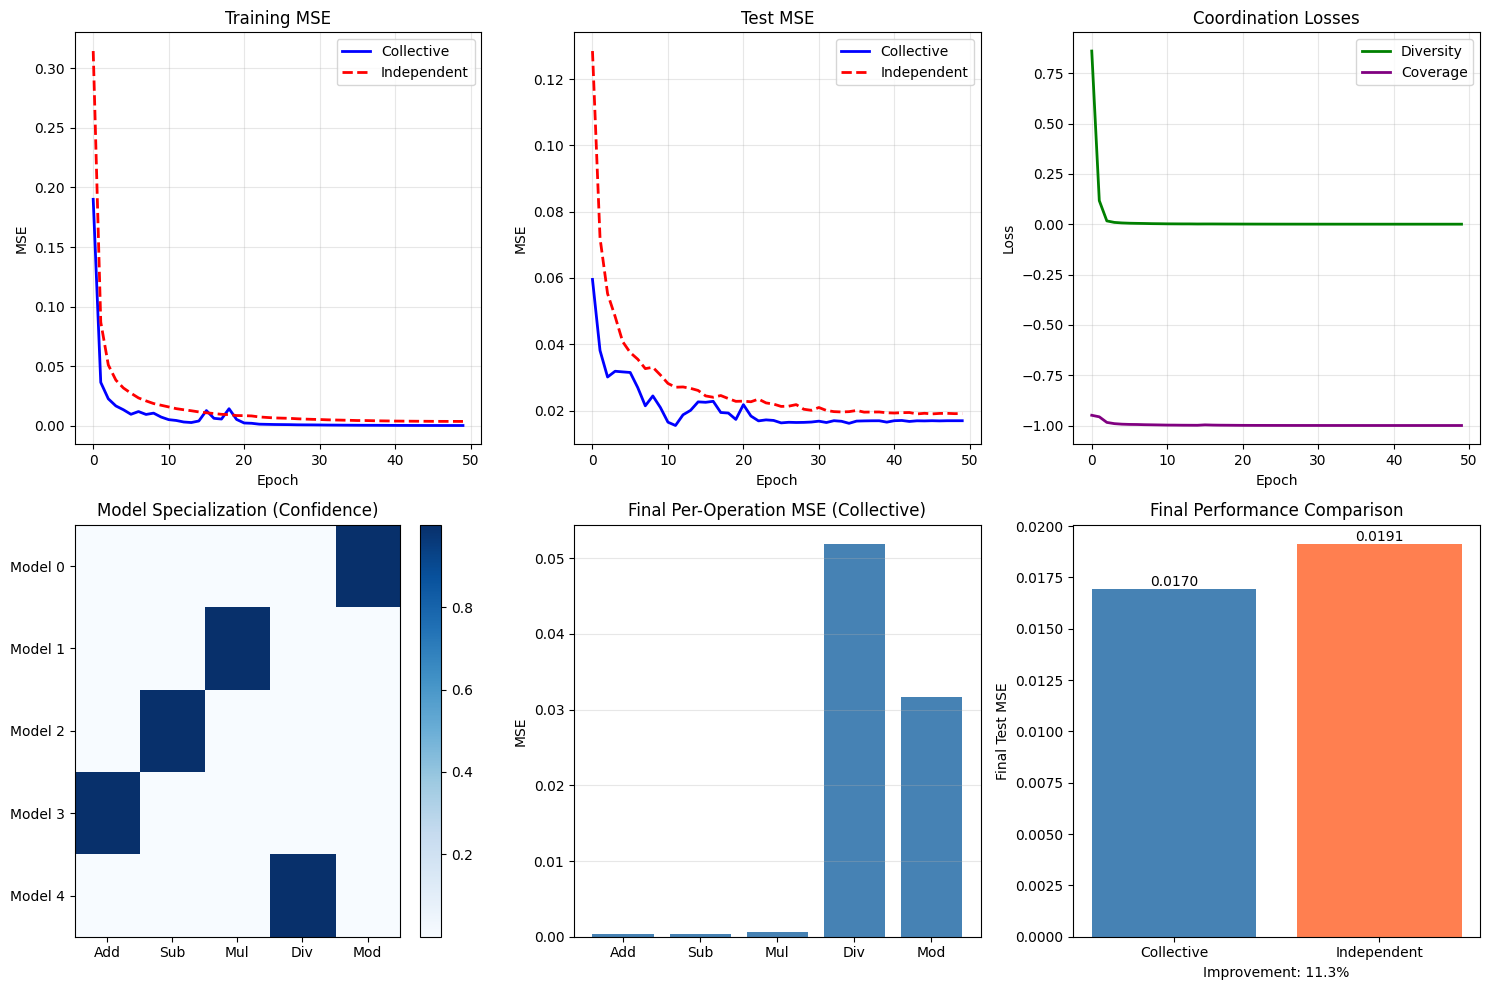


Saved: math_collective_results.png


In [4]:
"""
Math Collective - 5 Models Coordinating via GlobalFractalRouter
================================================================
Tests the GlobalFractalRouter in its intended context: managing a collective.

5 models share the registry and mailbox. Each can attempt any operation,
but through coordination they should specialize and improve collectively.

Operations: add, subtract, multiply, divide, modulo
Input: (a, b) pair
Output: 5 results, one per operation

The collective receives a query and must route it appropriately.
Individual models see what others are doing via mailbox and adjust.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math
import time
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    FingerprintRegistry,
    get_registry,
    RouterMailbox,
    RouterMessage,
    ProvenanceTensor,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class CollectiveConfig:
    """Configuration for the math collective."""

    # Model dimensions
    input_dim: int = 32  # Encoded (a, b) pair
    hidden_dim: int = 128
    output_dim: int = 5  # 5 operations

    # Router config
    feature_dim: int = 128
    fingerprint_dim: int = 64
    num_anchors: int = 8
    num_routes: int = 4

    # Collective
    num_models: int = 5
    cooperation_group: str = "math_collective"

    # Data
    num_range: Tuple[int, int] = (1, 100)
    train_samples: int = 10000
    test_samples: int = 2000

    # Training
    batch_size: int = 64
    epochs: int = 50
    lr: float = 1e-3
    weight_decay: float = 0.01

    # Coordination loss weights
    diversity_weight: float = 0.1  # Encourage different specializations
    coverage_weight: float = 0.1  # Ensure all operations covered

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# =============================================================================
# DATA GENERATION
# =============================================================================

def generate_math_data(num_samples: int, num_range: Tuple[int, int], device: str):
    """
    Generate math operation dataset.

    Returns:
        inputs: [N, 2] - (a, b) pairs
        targets: [N, 5] - results for [add, sub, mul, div, mod]
    """
    low, high = num_range

    a = torch.randint(low, high, (num_samples,), dtype=torch.float32)
    b = torch.randint(low, high, (num_samples,), dtype=torch.float32)

    # Avoid division by zero
    b = torch.where(b == 0, torch.ones_like(b), b)

    # Compute all operations
    add = a + b
    sub = a - b
    mul = a * b
    div = a / b
    mod = a % b

    inputs = torch.stack([a, b], dim=1)
    targets = torch.stack([add, sub, mul, div, mod], dim=1)

    # Normalize targets for easier learning
    target_means = targets.mean(dim=0, keepdim=True)
    target_stds = targets.std(dim=0, keepdim=True).clamp(min=1e-6)
    targets_norm = (targets - target_means) / target_stds

    return inputs.to(device), targets_norm.to(device), target_means.to(device), target_stds.to(device)


def encode_inputs(inputs: torch.Tensor, embed_dim: int) -> torch.Tensor:
    """
    Encode (a, b) pairs into feature vectors.
    Uses simple positional encoding.
    """
    a, b = inputs[:, 0:1], inputs[:, 1:2]

    # Normalize to [0, 1] range approximately
    a_norm = a / 100.0
    b_norm = b / 100.0

    # Positional encoding
    freqs = torch.arange(embed_dim // 4, device=inputs.device).float()
    freqs = (2.0 ** freqs) * math.pi

    a_enc = torch.cat([
        torch.sin(a_norm * freqs),
        torch.cos(a_norm * freqs),
    ], dim=-1)

    b_enc = torch.cat([
        torch.sin(b_norm * freqs),
        torch.cos(b_norm * freqs),
    ], dim=-1)

    return torch.cat([a_enc, b_enc], dim=-1)


# =============================================================================
# INDIVIDUAL MATH MODEL (with GlobalFractalRouter)
# =============================================================================

class MathModel(nn.Module):
    """
    Single model in the collective.
    Has its own GlobalFractalRouter that coordinates with others.

    Creates a sequence of 5 "operation slots" that the router routes between.
    Each slot learns to specialize on one operation.
    """

    NUM_SLOTS = 8  # Sequence length for routing (must be > num_routes)

    def __init__(
        self,
        config: CollectiveConfig,
        model_idx: int,
        parent_id: Optional[str] = None,
    ):
        super().__init__()
        self.config = config
        self.model_idx = model_idx

        # Input encoding - projects to sequence of slots
        self.input_encoder = nn.Sequential(
            nn.Linear(config.input_dim, config.hidden_dim),
            nn.GELU(),
            nn.Linear(config.hidden_dim, config.feature_dim * self.NUM_SLOTS),
        )

        # Learnable slot embeddings (like positional embeddings)
        self.slot_embeddings = nn.Parameter(
            torch.randn(1, self.NUM_SLOTS, config.feature_dim) * 0.02
        )

        # Router (the core of coordination)
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=True,
            use_cantor_prior=True,  # Use Cantor for slot relationships
            grid_size=(self.NUM_SLOTS, 1),  # 1D grid
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            parent_id=parent_id,
            cooperation_group=config.cooperation_group,
            name=f"math_model_{model_idx}",
        )

        # Output heads - one per operation (reads from pooled routed features)
        self.operation_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(config.feature_dim, config.hidden_dim),
                nn.GELU(),
                nn.Linear(config.hidden_dim, 1),
            )
            for _ in range(5)
        ])

        # Confidence head - how confident is this model for each operation
        self.confidence_head = nn.Sequential(
            nn.Linear(config.feature_dim, config.hidden_dim),
            nn.GELU(),
            nn.Linear(config.hidden_dim, 5),
            nn.Softmax(dim=-1),
        )

    @property
    def fingerprint(self) -> torch.Tensor:
        return self.router.fingerprint

    @property
    def module_id(self) -> str:
        return self.router.module_id

    def forward(
        self,
        inputs: torch.Tensor,
        mailbox: RouterMailbox,
        target_fingerprint: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        Args:
            inputs: [B, input_dim] encoded inputs
            mailbox: Shared mailbox for coordination
            target_fingerprint: Optional next model's fingerprint

        Returns:
            predictions: [B, 5] predictions for all operations
            confidences: [B, 5] confidence per operation
            info: Dict with routing metrics
        """
        B = inputs.shape[0]

        # Encode inputs to sequence of slots
        encoded = self.input_encoder(inputs)  # [B, feature_dim * NUM_SLOTS]
        features_seq = encoded.view(B, self.NUM_SLOTS, self.config.feature_dim)

        # Add slot embeddings
        features_seq = features_seq + self.slot_embeddings

        # Route through GlobalFractalRouter
        routes, weights, routed_features = self.router(
            features_seq,
            mailbox=mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=False,  # No CLS token
        )

        # Pool across slots
        pooled = routed_features.mean(dim=1)  # [B, D]

        # Compute predictions for each operation
        predictions = []
        for head in self.operation_heads:
            pred = head(pooled)
            predictions.append(pred)
        predictions = torch.cat(predictions, dim=-1)  # [B, 5]

        # Compute confidence distribution
        confidences = self.confidence_head(pooled)  # [B, 5]

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
            'confidence_entropy': -(confidences * (confidences + 1e-8).log()).sum(dim=-1).mean().item(),
            'top_confidence': confidences.max(dim=-1)[0].mean().item(),
            'specialization': confidences.argmax(dim=-1).float().mean().item(),
        }

        return predictions, confidences, info


# =============================================================================
# MATH COLLECTIVE
# =============================================================================

class MathCollective(nn.Module):
    """
    Ensemble of MathModels coordinating via shared GlobalFractalRouter infrastructure.
    """

    def __init__(self, config: CollectiveConfig):
        super().__init__()
        self.config = config

        # Reset registry for clean start
        get_registry().reset()

        # Create models
        self.models = nn.ModuleList()
        parent_id = None

        for i in range(config.num_models):
            model = MathModel(
                config=config,
                model_idx=i,
                parent_id=parent_id,
            )
            self.models.append(model)
            # Chain topology - each model's parent is the previous
            parent_id = model.module_id

        # Shared mailbox
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
        )
        self.mailbox = RouterMailbox(router_config)

        # Store fingerprints for target passing
        self.register_buffer(
            'fingerprint_matrix',
            torch.stack([m.fingerprint for m in self.models])
        )

    def forward(
        self,
        inputs: torch.Tensor,
        return_individual: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        Forward through collective with coordination.

        Args:
            inputs: [B, 2] raw (a, b) pairs
            return_individual: Return individual model outputs

        Returns:
            predictions: [B, 5] collective predictions
            confidences: [B, num_models, 5] per-model confidences
            info: Collective metrics
        """
        B = inputs.shape[0]
        device = inputs.device

        # Encode inputs
        encoded = encode_inputs(inputs, self.config.input_dim)

        # Clear mailbox for this forward pass
        self.mailbox.clear()

        # Collect outputs from all models
        all_predictions = []
        all_confidences = []
        all_infos = []

        for i, model in enumerate(self.models):
            # Get target fingerprint (next model or None)
            if i < len(self.models) - 1:
                target_fp = self.models[i + 1].fingerprint
            else:
                target_fp = None

            preds, confs, info = model(encoded, self.mailbox, target_fp)

            all_predictions.append(preds)
            all_confidences.append(confs)
            all_infos.append(info)

        # Stack predictions and confidences
        predictions_stack = torch.stack(all_predictions, dim=1)  # [B, num_models, 5]
        confidences_stack = torch.stack(all_confidences, dim=1)  # [B, num_models, 5]

        # Weighted combination using confidences
        # Each model's prediction is weighted by its confidence
        weights = confidences_stack / (confidences_stack.sum(dim=1, keepdim=True) + 1e-8)
        collective_predictions = (predictions_stack * weights).sum(dim=1)  # [B, 5]

        # Aggregate info
        info = {
            'individual_infos': all_infos,
            'mailbox_messages': len(self.mailbox.messages),
            'mean_route_entropy': np.mean([i['route_entropy'] for i in all_infos]),
            'mean_confidence_entropy': np.mean([i['confidence_entropy'] for i in all_infos]),
            'specializations': [i['specialization'] for i in all_infos],
        }

        if return_individual:
            info['individual_predictions'] = predictions_stack
            info['individual_confidences'] = confidences_stack

        return collective_predictions, confidences_stack, info

    def compute_diversity_loss(self, confidences: torch.Tensor) -> torch.Tensor:
        """
        Encourage models to specialize on different operations.
        Penalize when all models have same confidence distribution.
        """
        # confidences: [B, num_models, 5]
        # Want different models to have different confidence peaks

        # Average confidence per model across batch
        mean_conf = confidences.mean(dim=0)  # [num_models, 5]

        # Compute pairwise cosine similarity between models
        mean_conf_norm = F.normalize(mean_conf, dim=-1)
        similarity = torch.mm(mean_conf_norm, mean_conf_norm.T)  # [num_models, num_models]

        # Mask diagonal (self-similarity)
        mask = 1 - torch.eye(self.config.num_models, device=confidences.device)

        # Penalize high similarity (want diversity)
        diversity_loss = (similarity * mask).sum() / (mask.sum() + 1e-8)

        return diversity_loss

    def compute_coverage_loss(self, confidences: torch.Tensor) -> torch.Tensor:
        """
        Ensure all operations are covered by at least one model.
        Penalize if any operation has low total confidence.
        """
        # confidences: [B, num_models, 5]

        # Total confidence per operation across all models
        total_conf = confidences.sum(dim=1)  # [B, 5]

        # Want each operation to have reasonable coverage
        # Penalize low minimum coverage
        min_coverage = total_conf.min(dim=-1)[0]  # [B]

        # Higher min_coverage is better, so loss is negative of it
        coverage_loss = -min_coverage.mean()

        return coverage_loss

    def get_specialization_matrix(self) -> torch.Tensor:
        """
        Compute which model specializes in which operation.
        Returns [num_models, 5] affinity matrix.
        """
        # Use fingerprint similarity to anchors as proxy
        # This is computed from learned representations

        # For now, just return confidence averages from last forward
        # Would need to accumulate during training
        return torch.zeros(self.config.num_models, 5)


# =============================================================================
# BASELINE (Independent Models)
# =============================================================================

class IndependentMathModel(nn.Module):
    """Single model without collective coordination (baseline)."""

    def __init__(self, config: CollectiveConfig, model_idx: int):
        super().__init__()
        self.config = config
        self.model_idx = model_idx

        self.network = nn.Sequential(
            nn.Linear(config.input_dim, config.hidden_dim),
            nn.GELU(),
            nn.Linear(config.hidden_dim, config.hidden_dim),
            nn.GELU(),
            nn.Linear(config.hidden_dim, 5),  # Direct prediction
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        encoded = encode_inputs(inputs, self.config.input_dim)
        return self.network(encoded)


class IndependentEnsemble(nn.Module):
    """Ensemble of independent models (no coordination baseline)."""

    def __init__(self, config: CollectiveConfig):
        super().__init__()
        self.config = config
        self.models = nn.ModuleList([
            IndependentMathModel(config, i) for i in range(config.num_models)
        ])

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        predictions = [m(inputs) for m in self.models]
        stacked = torch.stack(predictions, dim=1)  # [B, num_models, 5]
        mean_pred = stacked.mean(dim=1)  # [B, 5]

        info = {
            'individual_predictions': stacked,
            'std': stacked.std(dim=1).mean().item(),
        }

        return mean_pred, info


# =============================================================================
# TRAINING
# =============================================================================

def train_collective(
    collective: MathCollective,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config: CollectiveConfig,
    target_stats: Tuple[torch.Tensor, torch.Tensor],
):
    """Train the collective with coordination losses."""

    optimizer = torch.optim.AdamW(
        collective.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config.epochs
    )

    history = defaultdict(list)
    target_means, target_stds = target_stats

    for epoch in range(config.epochs):
        collective.train()
        epoch_loss = 0
        epoch_mse = 0
        epoch_diversity = 0
        epoch_coverage = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            predictions, confidences, info = collective(inputs)

            # Main loss: MSE on predictions
            mse_loss = F.mse_loss(predictions, targets)

            # Coordination losses
            diversity_loss = collective.compute_diversity_loss(confidences)
            coverage_loss = collective.compute_coverage_loss(confidences)

            # Total loss
            loss = (
                mse_loss
                + config.diversity_weight * diversity_loss
                + config.coverage_weight * coverage_loss
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(collective.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_mse += mse_loss.item()
            epoch_diversity += diversity_loss.item()
            epoch_coverage += coverage_loss.item()

        scheduler.step()

        # Evaluate
        collective.eval()
        test_mse = 0
        test_per_op_mse = torch.zeros(5, device=config.device)

        with torch.no_grad():
            for inputs, targets in test_loader:
                predictions, _, _ = collective(inputs)
                test_mse += F.mse_loss(predictions, targets).item()

                # Per-operation MSE
                for op in range(5):
                    test_per_op_mse[op] += F.mse_loss(
                        predictions[:, op], targets[:, op]
                    ).item()

        n_batches = len(train_loader)
        n_test = len(test_loader)

        history['train_loss'].append(epoch_loss / n_batches)
        history['train_mse'].append(epoch_mse / n_batches)
        history['diversity_loss'].append(epoch_diversity / n_batches)
        history['coverage_loss'].append(epoch_coverage / n_batches)
        history['test_mse'].append(test_mse / n_test)
        history['test_per_op_mse'].append((test_per_op_mse / n_test).cpu().numpy())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | "
                  f"MSE: {epoch_mse/n_batches:.4f} | Test MSE: {test_mse/n_test:.4f} | "
                  f"Div: {epoch_diversity/n_batches:.4f}")

    return dict(history)


def train_baseline(
    ensemble: IndependentEnsemble,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config: CollectiveConfig,
):
    """Train independent ensemble baseline."""

    optimizer = torch.optim.AdamW(
        ensemble.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config.epochs
    )

    history = defaultdict(list)

    for epoch in range(config.epochs):
        ensemble.train()
        epoch_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            predictions, _ = ensemble(inputs)
            loss = F.mse_loss(predictions, targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()

        # Evaluate
        ensemble.eval()
        test_mse = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                predictions, _ = ensemble(inputs)
                test_mse += F.mse_loss(predictions, targets).item()

        n_batches = len(train_loader)
        n_test = len(test_loader)

        history['train_mse'].append(epoch_loss / n_batches)
        history['test_mse'].append(test_mse / n_test)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train MSE: {epoch_loss/n_batches:.4f} | "
                  f"Test MSE: {test_mse/n_test:.4f}")

    return dict(history)


# =============================================================================
# ANALYSIS
# =============================================================================

def analyze_specialization(collective: MathCollective, test_loader: DataLoader, config: CollectiveConfig):
    """Analyze how models specialized across operations."""

    collective.eval()

    # Accumulate confidences
    all_confidences = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            _, confidences, _ = collective(inputs)
            all_confidences.append(confidences)

    # [total_samples, num_models, 5]
    all_confidences = torch.cat(all_confidences, dim=0)

    # Average confidence per model per operation
    mean_conf = all_confidences.mean(dim=0)  # [num_models, 5]

    op_names = ['Add', 'Sub', 'Mul', 'Div', 'Mod']

    print("\n" + "="*60)
    print("  SPECIALIZATION ANALYSIS")
    print("="*60)
    print(f"\n{'Model':<10}", end="")
    for op in op_names:
        print(f"{op:>10}", end="")
    print(f"{'Primary':>12}")
    print("-"*72)

    for i in range(config.num_models):
        print(f"Model {i:<4}", end="")
        confs = mean_conf[i].cpu().numpy()
        for c in confs:
            print(f"{c:>10.3f}", end="")
        primary = op_names[confs.argmax()]
        print(f"{primary:>12}")

    print("-"*72)
    print(f"{'Coverage':<10}", end="")
    coverage = mean_conf.sum(dim=0).cpu().numpy()
    for c in coverage:
        print(f"{c:>10.3f}", end="")
    print()

    return mean_conf


def plot_results(
    collective_history: Dict,
    baseline_history: Dict,
    specialization: torch.Tensor,
    save_path: str = "math_collective_results.png",
):
    """Plot training curves and specialization."""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Training MSE comparison
    ax = axes[0, 0]
    ax.plot(collective_history['train_mse'], 'b-', label='Collective', linewidth=2)
    ax.plot(baseline_history['train_mse'], 'r--', label='Independent', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Training MSE')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Test MSE comparison
    ax = axes[0, 1]
    ax.plot(collective_history['test_mse'], 'b-', label='Collective', linewidth=2)
    ax.plot(baseline_history['test_mse'], 'r--', label='Independent', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Test MSE')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Coordination losses
    ax = axes[0, 2]
    ax.plot(collective_history['diversity_loss'], 'g-', label='Diversity', linewidth=2)
    ax.plot(collective_history['coverage_loss'], 'purple', label='Coverage', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Coordination Losses')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Specialization heatmap
    ax = axes[1, 0]
    spec = specialization.cpu().numpy()
    im = ax.imshow(spec, cmap='Blues', aspect='auto')
    ax.set_xticks(range(5))
    ax.set_xticklabels(['Add', 'Sub', 'Mul', 'Div', 'Mod'])
    ax.set_yticks(range(spec.shape[0]))
    ax.set_yticklabels([f'Model {i}' for i in range(spec.shape[0])])
    ax.set_title('Model Specialization (Confidence)')
    plt.colorbar(im, ax=ax)

    # Per-operation MSE (final)
    ax = axes[1, 1]
    final_per_op = collective_history['test_per_op_mse'][-1]
    ax.bar(['Add', 'Sub', 'Mul', 'Div', 'Mod'], final_per_op, color='steelblue')
    ax.set_ylabel('MSE')
    ax.set_title('Final Per-Operation MSE (Collective)')
    ax.grid(True, alpha=0.3, axis='y')

    # Final comparison bar
    ax = axes[1, 2]
    final_collective = collective_history['test_mse'][-1]
    final_baseline = baseline_history['test_mse'][-1]
    bars = ax.bar(['Collective', 'Independent'], [final_collective, final_baseline],
                  color=['steelblue', 'coral'])
    ax.set_ylabel('Final Test MSE')
    ax.set_title('Final Performance Comparison')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')

    improvement = (final_baseline - final_collective) / final_baseline * 100
    ax.set_xlabel(f'Improvement: {improvement:.1f}%')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*60)
    print("  Math Collective Experiment")
    print("  5 Models Coordinating via GlobalFractalRouter")
    print("="*60)

    config = CollectiveConfig()

    print(f"\nConfig:")
    print(f"  Models: {config.num_models}")
    print(f"  Feature dim: {config.feature_dim}")
    print(f"  Fingerprint dim: {config.fingerprint_dim}")
    print(f"  Epochs: {config.epochs}")
    print(f"  Device: {config.device}")

    # Generate data
    print("\nGenerating data...")
    train_inputs, train_targets, means, stds = generate_math_data(
        config.train_samples, config.num_range, config.device
    )
    test_inputs, test_targets, _, _ = generate_math_data(
        config.test_samples, config.num_range, config.device
    )

    # Normalize test targets with train stats
    test_targets = (test_targets * stds + means - means) / stds  # Re-normalize

    train_dataset = TensorDataset(train_inputs, train_targets)
    test_dataset = TensorDataset(test_inputs, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size)

    # Train collective
    print("\n" + "="*60)
    print("  Training COLLECTIVE (with GlobalFractalRouter)")
    print("="*60)

    collective = MathCollective(config).to(config.device)
    print(f"Parameters: {sum(p.numel() for p in collective.parameters()):,}")

    collective_history = train_collective(
        collective, train_loader, test_loader, config, (means, stds)
    )

    # Train baseline
    print("\n" + "="*60)
    print("  Training BASELINE (Independent Ensemble)")
    print("="*60)

    baseline = IndependentEnsemble(config).to(config.device)
    print(f"Parameters: {sum(p.numel() for p in baseline.parameters()):,}")

    baseline_history = train_baseline(
        baseline, train_loader, test_loader, config
    )

    # Analyze specialization
    specialization = analyze_specialization(collective, test_loader, config)

    # Final results
    print("\n" + "="*60)
    print("  FINAL RESULTS")
    print("="*60)

    final_collective = collective_history['test_mse'][-1]
    final_baseline = baseline_history['test_mse'][-1]
    improvement = (final_baseline - final_collective) / final_baseline * 100

    print(f"\n  Collective Test MSE:   {final_collective:.6f}")
    print(f"  Independent Test MSE:  {final_baseline:.6f}")
    print(f"  Improvement:           {improvement:+.2f}%")

    # Plot
    plot_results(collective_history, baseline_history, specialization)

    return collective, baseline, collective_history, baseline_history


if __name__ == "__main__":
    collective, baseline, c_hist, b_hist = main()

# frozen clip + conv + conv experts

  CLIP + Conv Collective Experiment
  Frozen CLIP + Learnable Conv Models via GlobalFractalRouter

Config:
  Feature dim: 128
  Fingerprint dim: 64
  Epochs: 10
  Device: cuda
  Train samples: 60000
  Test samples: 10000

  Training WITH CLIP (frozen expertise)
  CLIP ViT-B/32 loaded from HuggingFace
  Trainable: 7,719,360 / Total: 95,175,360


With CLIP:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch   1 | Loss: 0.3537 | Test: 90.91% | S0: 17.2% | S1: 10.0% | S2: 11.1%


Epoch 2:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch   5 | Loss: 0.1356 | Test: 92.26% | S0: 14.6% | S1: 10.0% | S2: 10.4%


Epoch 6:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7:   0%|          | 0/469 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 8:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch  10 | Loss: 0.0399 | Test: 93.40% | S0: 12.3% | S1: 10.0% | S2: 10.6%

  Training WITHOUT CLIP (ablation)
  Trainable: 7,005,998


Without CLIP:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
           ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Epoch   1 | Loss: 0.3910 | Test: 89.34% | S0: 20.0% | S1: 9.9%


Epoch 2:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch   5 | Loss: 0.1414 | Test: 91.95% | S0: 19.9% | S1: 11.1%


Epoch 6:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7:   0%|          | 0/469 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b863ff4e200> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():
^ ^ ^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^ ^ ^ ^Exception ignored in: 

Epoch 8:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10:   0%|          | 0/469 [00:00<?, ?batch/s]

Eval:   0%|          | 0/79 [00:00<?, ?batch/s]

Epoch  10 | Loss: 0.0361 | Test: 92.66% | S0: 19.0% | S1: 10.6%

  FINAL RESULTS

  With CLIP:    93.40%
  Without CLIP: 92.66%
  Improvement:  +0.80%

  Per-stream final accuracy:
    With CLIP:
      Conv 0: 12.33%
      Conv 1: 10.00%
      CLIP: 10.57%
    Without CLIP:
      Conv 0: 19.04%
      Conv 1: 10.56%


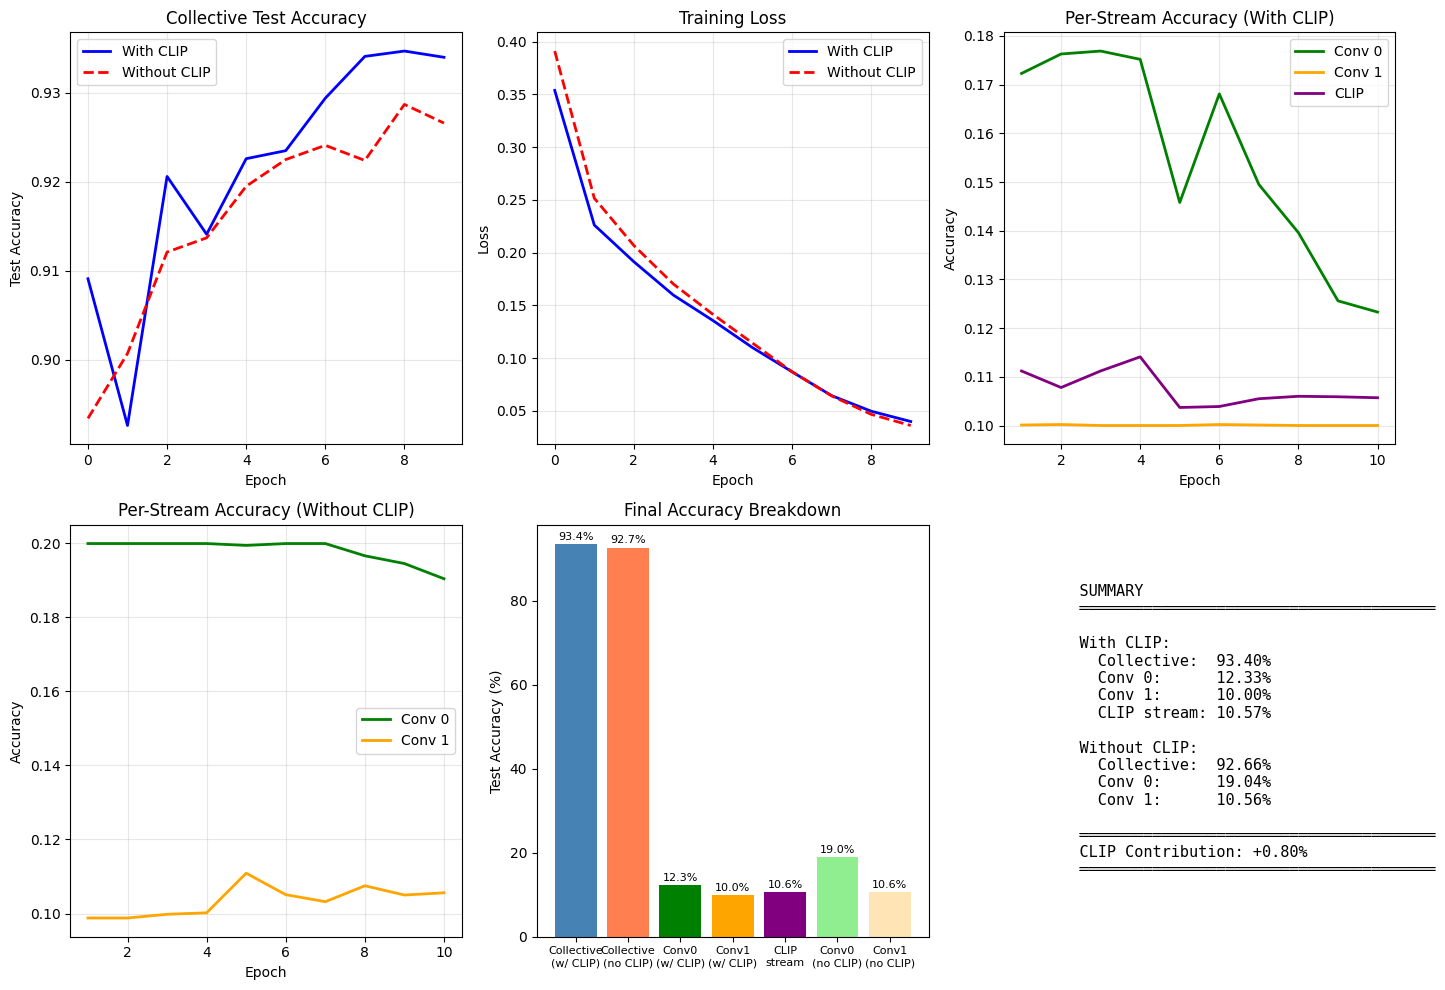


Saved: clip_collective_results.png


In [1]:
"""
CLIP + Conv Collective - Routing Frozen Expertise with Learnable Specialists
=============================================================================
Tests GlobalFractalRouter's capacity to coordinate:
- Frozen CLIP visual encoder (overwhelming expertise, no gradients)
- Two lightweight conv models (learnable, divergent fingerprints)

The router must learn to:
1. Route CLIP's completed information appropriately
2. Let conv models specialize on complementary features
3. Combine all streams for classification

Ablation: Same setup without CLIP - just the conv pair.

Author: AbstractPhil
Date: December 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import time
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    get_registry,
    RouterMailbox,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class CLIPCollectiveConfig:
    """Configuration for CLIP + Conv collective."""

    # Image
    image_size: int = 28
    in_channels: int = 1  # MNIST grayscale
    num_classes: int = 10

    # Feature dimensions
    feature_dim: int = 128  # Our internal dimension
    clip_dim: int = 512  # CLIP ViT-B/32 output dim
    fingerprint_dim: int = 64

    # Router
    num_anchors: int = 8
    num_routes: int = 4
    num_slots: int = 8  # Sequence length for routing

    # Conv models
    conv_channels: List[int] = None  # Set in __post_init__

    # Training
    batch_size: int = 128
    epochs: int = 10
    lr: float = 3e-4
    weight_decay: float = 0.01

    # Coordination
    diversity_weight: float = 0.05

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    def __post_init__(self):
        if self.conv_channels is None:
            self.conv_channels = [32, 64]  # Lightweight


# =============================================================================
# CLIP WRAPPER (Frozen)
# =============================================================================

class FrozenCLIPEncoder(nn.Module):
    """
    Frozen CLIP visual encoder with translation head.
    CLIP sees the image but doesn't learn - pure expertise injection.
    """

    def __init__(self, config: CLIPCollectiveConfig):
        super().__init__()
        self.config = config

        # Load CLIP from HuggingFace
        try:
            from transformers import CLIPVisionModel, CLIPImageProcessor

            self.clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_available = True
            print("  CLIP ViT-B/32 loaded from HuggingFace")
        except Exception as e:
            print(f"  WARNING: CLIP not available ({e}), using mock encoder")
            self.clip_available = False
            self.clip_model = None
            self.clip_processor = None

        # Freeze CLIP entirely
        if self.clip_available:
            for param in self.clip_model.parameters():
                param.requires_grad = False
            self.clip_model.eval()

        # CLIP ViT-B/32 outputs 768-dim, not 512
        clip_output_dim = 768 if self.clip_available else config.clip_dim

        # Translation head: CLIP dim → our feature dim × num_slots
        # This IS learnable - learns how to present CLIP info to router
        self.translation = nn.Sequential(
            nn.Linear(clip_output_dim, config.feature_dim * 2),
            nn.GELU(),
            nn.Linear(config.feature_dim * 2, config.feature_dim * config.num_slots),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [B, 1, 28, 28] MNIST images (normalized)

        Returns:
            features: [B, num_slots, feature_dim] translated CLIP features
        """
        B = x.shape[0]
        device = x.device

        if self.clip_available:
            # Prepare for CLIP: resize and convert to RGB
            # MNIST is [B, 1, 28, 28], need [B, 3, 224, 224]
            x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            x_rgb = x_resized.expand(-1, 3, -1, -1)  # Grayscale → RGB

            # Normalize for CLIP (processor expects [0, 1] range, we have normalized MNIST)
            # Undo MNIST normalization first
            x_rgb = x_rgb * 0.3081 + 0.1307  # Approximate denorm
            x_rgb = x_rgb.clamp(0, 1)

            # Apply CLIP normalization
            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1, 3, 1, 1)
            std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1, 3, 1, 1)
            x_clip = (x_rgb - mean) / std

            # Get CLIP features (no grad)
            with torch.no_grad():
                outputs = self.clip_model(pixel_values=x_clip)
                clip_features = outputs.pooler_output  # [B, 768]
        else:
            # Mock: random features (for testing without CLIP)
            clip_features = torch.randn(B, 768, device=device)

        # Translate to our format
        translated = self.translation(clip_features)  # [B, feature_dim * num_slots]
        features = translated.view(B, self.config.num_slots, self.config.feature_dim)

        return features


# =============================================================================
# LIGHTWEIGHT CONV MODEL
# =============================================================================

class LightweightConvModel(nn.Module):
    """
    Small conv model with unique fingerprint.
    Learns to specialize on aspects the collective needs.
    """

    def __init__(
        self,
        config: CLIPCollectiveConfig,
        model_idx: int,
        parent_id: Optional[str] = None,
    ):
        super().__init__()
        self.config = config
        self.model_idx = model_idx

        # Simple conv backbone
        self.conv = nn.Sequential(
            # 28x28 → 14x14
            nn.Conv2d(config.in_channels, config.conv_channels[0], 3, padding=1),
            nn.BatchNorm2d(config.conv_channels[0]),
            nn.GELU(),
            nn.MaxPool2d(2),

            # 14x14 → 7x7
            nn.Conv2d(config.conv_channels[0], config.conv_channels[1], 3, padding=1),
            nn.BatchNorm2d(config.conv_channels[1]),
            nn.GELU(),
            nn.MaxPool2d(2),
        )

        # Project to sequence of slots
        # 7x7x64 = 3136 → feature_dim * num_slots
        conv_out_dim = 7 * 7 * config.conv_channels[1]
        self.to_slots = nn.Linear(conv_out_dim, config.feature_dim * config.num_slots)

        # Learnable slot embeddings (different per model via fingerprint)
        self.slot_embed = nn.Parameter(torch.randn(1, config.num_slots, config.feature_dim) * 0.02)

        # Router with unique fingerprint
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=True,
            use_cantor_prior=True,
            grid_size=(config.num_slots, 1),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            parent_id=parent_id,
            cooperation_group="clip_conv_collective",
            name=f"conv_model_{model_idx}",
        )

    @property
    def fingerprint(self) -> torch.Tensor:
        return self.router.fingerprint

    @property
    def module_id(self) -> str:
        return self.router.module_id

    def forward(
        self,
        x: torch.Tensor,
        mailbox: RouterMailbox,
        target_fingerprint: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, 1, 28, 28] input images
            mailbox: Shared mailbox
            target_fingerprint: Next model's fingerprint

        Returns:
            features: [B, num_slots, feature_dim] routed features
            info: Dict with metrics
        """
        B = x.shape[0]

        # Conv features
        conv_out = self.conv(x)  # [B, 64, 7, 7]
        conv_flat = conv_out.view(B, -1)  # [B, 3136]

        # Project to slots
        slots = self.to_slots(conv_flat)  # [B, feature_dim * num_slots]
        slots = slots.view(B, self.config.num_slots, self.config.feature_dim)

        # Add slot embeddings
        slots = slots + self.slot_embed

        # Route
        routes, weights, routed = self.router(
            slots,
            mailbox=mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=False,
        )

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return routed, info


# =============================================================================
# CLIP STREAM (Router wrapper for frozen CLIP)
# =============================================================================

class CLIPStream(nn.Module):
    """
    Wraps frozen CLIP encoder with a router for coordination.
    The router learns how to present CLIP's expertise to the collective.
    """

    def __init__(
        self,
        config: CLIPCollectiveConfig,
        clip_encoder: FrozenCLIPEncoder,
        parent_id: Optional[str] = None,
    ):
        super().__init__()
        self.config = config
        self.clip_encoder = clip_encoder

        # Router for CLIP's translated features
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=True,
            use_cantor_prior=True,
            grid_size=(config.num_slots, 1),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            parent_id=parent_id,
            cooperation_group="clip_conv_collective",
            name="clip_stream",
        )

    @property
    def fingerprint(self) -> torch.Tensor:
        return self.router.fingerprint

    @property
    def module_id(self) -> str:
        return self.router.module_id

    def forward(
        self,
        x: torch.Tensor,
        mailbox: RouterMailbox,
        target_fingerprint: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, 1, 28, 28] input images

        Returns:
            features: [B, num_slots, feature_dim] routed CLIP features
            info: Dict with metrics
        """
        # Get translated CLIP features
        clip_features = self.clip_encoder(x)  # [B, num_slots, feature_dim]

        # Route (learns how to present CLIP to collective)
        routes, weights, routed = self.router(
            clip_features,
            mailbox=mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=False,
        )

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return routed, info


# =============================================================================
# FULL COLLECTIVE
# =============================================================================

class CLIPConvCollective(nn.Module):
    """
    Collective with:
    - Frozen CLIP encoder (optional)
    - Two lightweight conv models with divergent fingerprints
    - Shared router coordination via mailbox
    """

    def __init__(self, config: CLIPCollectiveConfig, use_clip: bool = True):
        super().__init__()
        self.config = config
        self.use_clip = use_clip

        # Reset registry
        get_registry().reset()

        # Build components
        self.streams = nn.ModuleList()
        parent_id = None

        # Conv model 0 (first in chain)
        conv0 = LightweightConvModel(config, model_idx=0, parent_id=parent_id)
        self.streams.append(conv0)
        parent_id = conv0.module_id

        # Conv model 1 (child of conv0)
        conv1 = LightweightConvModel(config, model_idx=1, parent_id=parent_id)
        self.streams.append(conv1)
        parent_id = conv1.module_id

        # CLIP stream (optional, child of conv1)
        if use_clip:
            clip_encoder = FrozenCLIPEncoder(config)
            self.clip_stream = CLIPStream(config, clip_encoder, parent_id=parent_id)
            self.streams.append(self.clip_stream)
        else:
            self.clip_stream = None

        # Shared mailbox
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
        )
        self.mailbox = RouterMailbox(router_config)

        # Fusion layer (combines all streams)
        num_streams = 3 if use_clip else 2
        self.fusion = nn.Sequential(
            nn.Linear(config.feature_dim * num_streams, config.feature_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim * 2, config.feature_dim),
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.feature_dim),
            nn.Linear(config.feature_dim, config.num_classes),
        )

        # Per-stream classifiers (for measuring individual contribution)
        self.stream_classifiers = nn.ModuleList([
            nn.Linear(config.feature_dim, config.num_classes)
            for _ in range(num_streams)
        ])

    def forward(
        self,
        x: torch.Tensor,
        return_individual: bool = False,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, 1, 28, 28] input images
            return_individual: Also return per-stream predictions

        Returns:
            logits: [B, num_classes] collective prediction
            info: Dict with metrics and optional individual predictions
        """
        B = x.shape[0]

        # Clear mailbox
        self.mailbox.clear()

        # Process each stream
        stream_features = []
        stream_infos = []

        for i, stream in enumerate(self.streams):
            # Get target fingerprint (next stream or None)
            if i < len(self.streams) - 1:
                target_fp = self.streams[i + 1].fingerprint
            else:
                target_fp = None

            features, info = stream(x, self.mailbox, target_fp)

            # Pool across slots
            pooled = features.mean(dim=1)  # [B, feature_dim]
            stream_features.append(pooled)
            stream_infos.append(info)

        # Fuse all streams
        fused = torch.cat(stream_features, dim=-1)  # [B, feature_dim * num_streams]
        fused = self.fusion(fused)  # [B, feature_dim]

        # Classify
        logits = self.classifier(fused)  # [B, num_classes]

        # Build info
        info = {
            'stream_infos': stream_infos,
            'mailbox_messages': len(self.mailbox.messages),
            'mean_route_entropy': np.mean([i['route_entropy'] for i in stream_infos]),
        }

        # Individual stream predictions
        if return_individual:
            individual_logits = []
            for i, (feat, clf) in enumerate(zip(stream_features, self.stream_classifiers)):
                ind_logits = clf(feat)
                individual_logits.append(ind_logits)
            info['individual_logits'] = individual_logits

        return logits, info

    def compute_diversity_loss(self, stream_features: List[torch.Tensor]) -> torch.Tensor:
        """Encourage streams to learn different representations."""
        if len(stream_features) < 2:
            return torch.tensor(0.0, device=stream_features[0].device)

        # Compute pairwise cosine similarity
        total_sim = 0
        count = 0

        for i in range(len(stream_features)):
            for j in range(i + 1, len(stream_features)):
                fi = F.normalize(stream_features[i], dim=-1)
                fj = F.normalize(stream_features[j], dim=-1)
                sim = (fi * fj).sum(dim=-1).mean()
                total_sim += sim
                count += 1

        return total_sim / count if count > 0 else torch.tensor(0.0)


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: CLIPCollectiveConfig):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def train_collective(
    model: CLIPConvCollective,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config: CLIPCollectiveConfig,
    name: str = "Collective",
):
    """Train collective and track per-stream accuracy."""

    # Only optimize non-frozen parameters
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    history = defaultdict(list)

    epoch_pbar = tqdm(range(config.epochs), desc=f"{name}", unit="epoch")

    for epoch in epoch_pbar:
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False, unit="batch")

        for imgs, labels in batch_pbar:
            imgs, labels = imgs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()

            logits, info = model(imgs, return_individual=True)

            # Main loss
            ce_loss = F.cross_entropy(logits, labels)

            # Diversity loss on stream features (approximate via individual logits)
            # We want streams to predict differently before fusion
            div_loss = torch.tensor(0.0, device=config.device)
            if len(info['individual_logits']) > 1:
                probs = [F.softmax(l, dim=-1) for l in info['individual_logits']]
                for i in range(len(probs)):
                    for j in range(i + 1, len(probs)):
                        sim = F.cosine_similarity(probs[i], probs[j], dim=-1).mean()
                        div_loss += sim
                div_loss /= (len(probs) * (len(probs) - 1) / 2)

            loss = ce_loss + config.diversity_weight * div_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            optimizer.step()

            epoch_loss += ce_loss.item() * imgs.size(0)
            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += imgs.size(0)

            # Update batch progress bar
            batch_pbar.set_postfix({
                'loss': f"{ce_loss.item():.4f}",
                'acc': f"{correct/total*100:.1f}%"
            })

        scheduler.step()

        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0
        stream_correct = defaultdict(int)

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc="Eval", leave=False, unit="batch"):
                imgs, labels = imgs.to(config.device), labels.to(config.device)

                logits, info = model(imgs, return_individual=True)

                test_correct += (logits.argmax(dim=1) == labels).sum().item()
                test_total += imgs.size(0)

                # Per-stream accuracy
                for i, ind_logits in enumerate(info['individual_logits']):
                    stream_correct[i] += (ind_logits.argmax(dim=1) == labels).sum().item()

        train_acc = correct / total
        test_acc = test_correct / test_total
        stream_accs = {i: c / test_total for i, c in stream_correct.items()}

        history['train_loss'].append(epoch_loss / total)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['stream_accs'].append(stream_accs)

        # Update epoch progress bar
        stream_str = ' | '.join([f"S{i}: {a*100:.1f}%" for i, a in stream_accs.items()])
        epoch_pbar.set_postfix({
            'test': f"{test_acc*100:.2f}%",
            'loss': f"{epoch_loss/total:.4f}"
        })

        if (epoch + 1) % 5 == 0 or epoch == 0:
            tqdm.write(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/total:.4f} | "
                      f"Test: {test_acc*100:.2f}% | {stream_str}")

    return dict(history)


# =============================================================================
# ANALYSIS
# =============================================================================

def analyze_results(
    with_clip_history: Dict,
    without_clip_history: Dict,
    config: CLIPCollectiveConfig,
    save_path: str = "clip_collective_results.png",
):
    """Analyze and visualize results."""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Test accuracy comparison
    ax = axes[0, 0]
    ax.plot(with_clip_history['test_acc'], 'b-', label='With CLIP', linewidth=2)
    ax.plot(without_clip_history['test_acc'], 'r--', label='Without CLIP', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Collective Test Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Training loss
    ax = axes[0, 1]
    ax.plot(with_clip_history['train_loss'], 'b-', label='With CLIP', linewidth=2)
    ax.plot(without_clip_history['train_loss'], 'r--', label='Without CLIP', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Per-stream accuracy (with CLIP)
    ax = axes[0, 2]
    epochs = range(1, len(with_clip_history['stream_accs']) + 1)
    stream_names = ['Conv 0', 'Conv 1', 'CLIP']
    colors = ['green', 'orange', 'purple']

    for i in range(3):
        accs = [sa.get(i, 0) for sa in with_clip_history['stream_accs']]
        ax.plot(epochs, accs, color=colors[i], label=stream_names[i], linewidth=2)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Per-Stream Accuracy (With CLIP)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Per-stream accuracy (without CLIP)
    ax = axes[1, 0]
    stream_names_no_clip = ['Conv 0', 'Conv 1']

    for i in range(2):
        accs = [sa.get(i, 0) for sa in without_clip_history['stream_accs']]
        ax.plot(epochs, accs, color=colors[i], label=stream_names_no_clip[i], linewidth=2)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Per-Stream Accuracy (Without CLIP)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Final comparison bar
    ax = axes[1, 1]

    final_with = with_clip_history['test_acc'][-1]
    final_without = without_clip_history['test_acc'][-1]

    # Individual stream final accuracies
    with_stream_final = with_clip_history['stream_accs'][-1]
    without_stream_final = without_clip_history['stream_accs'][-1]

    labels = ['Collective\n(w/ CLIP)', 'Collective\n(no CLIP)',
              'Conv0\n(w/ CLIP)', 'Conv1\n(w/ CLIP)', 'CLIP\nstream',
              'Conv0\n(no CLIP)', 'Conv1\n(no CLIP)']
    values = [
        final_with, final_without,
        with_stream_final.get(0, 0), with_stream_final.get(1, 0), with_stream_final.get(2, 0),
        without_stream_final.get(0, 0), without_stream_final.get(1, 0),
    ]
    colors_bar = ['steelblue', 'coral', 'green', 'orange', 'purple', 'lightgreen', 'moccasin']

    bars = ax.bar(range(len(labels)), [v * 100 for v in values], color=colors_bar)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Final Accuracy Breakdown')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val*100:.1f}%', ha='center', va='bottom', fontsize=8)

    # Summary text
    ax = axes[1, 2]
    ax.axis('off')

    improvement = (final_with - final_without) / final_without * 100

    summary = f"""
    SUMMARY
    ═══════════════════════════════════════

    With CLIP:
      Collective:  {final_with*100:.2f}%
      Conv 0:      {with_stream_final.get(0, 0)*100:.2f}%
      Conv 1:      {with_stream_final.get(1, 0)*100:.2f}%
      CLIP stream: {with_stream_final.get(2, 0)*100:.2f}%

    Without CLIP:
      Collective:  {final_without*100:.2f}%
      Conv 0:      {without_stream_final.get(0, 0)*100:.2f}%
      Conv 1:      {without_stream_final.get(1, 0)*100:.2f}%

    ═══════════════════════════════════════
    CLIP Contribution: {improvement:+.2f}%
    ═══════════════════════════════════════
    """

    ax.text(0.1, 0.5, summary, fontsize=11, family='monospace',
            verticalalignment='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*60)
    print("  CLIP + Conv Collective Experiment")
    print("  Frozen CLIP + Learnable Conv Models via GlobalFractalRouter")
    print("="*60)

    config = CLIPCollectiveConfig()

    print(f"\nConfig:")
    print(f"  Feature dim: {config.feature_dim}")
    print(f"  Fingerprint dim: {config.fingerprint_dim}")
    print(f"  Epochs: {config.epochs}")
    print(f"  Device: {config.device}")

    # Data
    train_loader, test_loader = get_dataloaders(config)
    print(f"  Train samples: {len(train_loader.dataset)}")
    print(f"  Test samples: {len(test_loader.dataset)}")

    # =================================================================
    # WITH CLIP
    # =================================================================
    print("\n" + "="*60)
    print("  Training WITH CLIP (frozen expertise)")
    print("="*60)

    model_with_clip = CLIPConvCollective(config, use_clip=True).to(config.device)

    trainable_params = sum(p.numel() for p in model_with_clip.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model_with_clip.parameters())
    print(f"  Trainable: {trainable_params:,} / Total: {total_params:,}")

    with_clip_history = train_collective(
        model_with_clip, train_loader, test_loader, config, "With CLIP"
    )

    # =================================================================
    # WITHOUT CLIP (ablation)
    # =================================================================
    print("\n" + "="*60)
    print("  Training WITHOUT CLIP (ablation)")
    print("="*60)

    model_without_clip = CLIPConvCollective(config, use_clip=False).to(config.device)

    trainable_params = sum(p.numel() for p in model_without_clip.parameters() if p.requires_grad)
    print(f"  Trainable: {trainable_params:,}")

    without_clip_history = train_collective(
        model_without_clip, train_loader, test_loader, config, "Without CLIP"
    )

    # =================================================================
    # ANALYSIS
    # =================================================================
    print("\n" + "="*60)
    print("  FINAL RESULTS")
    print("="*60)

    final_with = with_clip_history['test_acc'][-1]
    final_without = without_clip_history['test_acc'][-1]
    improvement = (final_with - final_without) / final_without * 100

    print(f"\n  With CLIP:    {final_with*100:.2f}%")
    print(f"  Without CLIP: {final_without*100:.2f}%")
    print(f"  Improvement:  {improvement:+.2f}%")

    # Per-stream
    print("\n  Per-stream final accuracy:")
    print("    With CLIP:")
    for i, acc in with_clip_history['stream_accs'][-1].items():
        name = ['Conv 0', 'Conv 1', 'CLIP'][i]
        print(f"      {name}: {acc*100:.2f}%")

    print("    Without CLIP:")
    for i, acc in without_clip_history['stream_accs'][-1].items():
        name = ['Conv 0', 'Conv 1'][i]
        print(f"      {name}: {acc*100:.2f}%")

    analyze_results(with_clip_history, without_clip_history, config)

    return model_with_clip, model_without_clip, with_clip_history, without_clip_history


if __name__ == "__main__":
    results = main()

# lesion experment - clip l + clip b only, no conv sections

`torch_dtype` is deprecated! Use `dtype` instead!


  Dual Frozen CLIP Lesion Test
  CLIP-Base + CLIP-Large via GlobalFractalRouter

Config:
  Feature dim: 256
  Epochs: 20
  Device: cuda
  Train samples: 60000
  Test samples: 10000

  Training COLLECTIVE (Base + Large routed)
  Loading openai/clip-vit-base-patch32...
  Loading openai/clip-vit-large-patch14...
  Trainable: 5,549,102 / Total: 396,184,878
  Frozen: 390,635,776 (98.6%)


Collective:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   1 | Loss: 0.3600 | Test: 89.98% | Base: 12.1% | Large: 10.2%


Epoch 2:   0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
    ^ ^ ^^ ^  ^^^^^^^^^^^^^^^^^^^^

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   2 | Loss: 0.2736 | Test: 90.25% | Base: 11.9% | Large: 2.1%


Epoch 3:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   3 | Loss: 0.2443 | Test: 90.01% | Base: 14.4% | Large: 3.4%


Epoch 4:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   4 | Loss: 0.2239 | Test: 90.80% | Base: 19.8% | Large: 4.0%


Epoch 5:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   5 | Loss: 0.2077 | Test: 91.36% | Base: 18.1% | Large: 3.8%


Epoch 6:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   6 | Loss: 0.1938 | Test: 91.85% | Base: 13.4% | Large: 4.5%


Epoch 7:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   7 | Loss: 0.1793 | Test: 92.13% | Base: 11.3% | Large: 4.0%


Epoch 8:   0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():



Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   8 | Loss: 0.1662 | Test: 92.16% | Base: 14.1% | Large: 2.4%


Epoch 9:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch   9 | Loss: 0.1532 | Test: 91.65% | Base: 12.3% | Large: 3.4%


Epoch 10:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  10 | Loss: 0.1388 | Test: 92.29% | Base: 16.3% | Large: 6.9%


Epoch 11:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  11 | Loss: 0.1264 | Test: 92.11% | Base: 11.5% | Large: 6.0%


Epoch 12:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  12 | Loss: 0.1143 | Test: 92.55% | Base: 13.5% | Large: 6.0%


Epoch 13:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  13 | Loss: 0.0995 | Test: 92.47% | Base: 14.1% | Large: 6.0%


Epoch 14:   0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
             ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  14 | Loss: 0.0850 | Test: 92.69% | Base: 15.4% | Large: 5.6%


Epoch 15:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  15 | Loss: 0.0726 | Test: 92.67% | Base: 21.4% | Large: 8.6%


Epoch 16:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  16 | Loss: 0.0620 | Test: 92.54% | Base: 18.0% | Large: 6.2%


Epoch 17:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  17 | Loss: 0.0523 | Test: 92.52% | Base: 17.1% | Large: 7.5%


Epoch 18:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  18 | Loss: 0.0454 | Test: 92.57% | Base: 18.2% | Large: 6.9%


Epoch 19:   0%|          | 0/938 [00:00<?, ?batch/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  19 | Loss: 0.0405 | Test: 92.57% | Base: 19.0% | Large: 7.1%


Epoch 20:   0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  20 | Loss: 0.0370 | Test: 92.60% | Base: 18.8% | Large: 7.1%

  Training BASELINE: CLIP-Base alone
  Loading openai/clip-vit-base-patch32 (baseline)...
  Trainable: 199,946


CLIP-Base:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

CLIP-Base Epoch   1 | Test: 88.91%


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Base Epoch   5 | Test: 90.10%


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Base Epoch  10 | Test: 90.98%


Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Base Epoch  15 | Test: 92.03%


Epoch 16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Base Epoch  20 | Test: 92.02%

  Training BASELINE: CLIP-Large alone
  Loading openai/clip-vit-large-patch14 (baseline)...
  Trainable: 265,482


CLIP-Large:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Large Epoch   1 | Test: 88.74%


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Large Epoch   5 | Test: 91.33%


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Large Epoch  10 | Test: 91.99%


Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab46c47a480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Large Epoch  15 | Test: 92.17%


Epoch 16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/938 [00:00<?, ?it/s]

CLIP-Large Epoch  20 | Test: 92.45%

  FINAL RESULTS

  Collective:   92.60%
  CLIP-Base:    92.02%
  CLIP-Large:   92.45%

  Improvement over best individual: +0.15%

  Per-stream in collective:
    Base stream:  18.84%
    Large stream: 7.07%


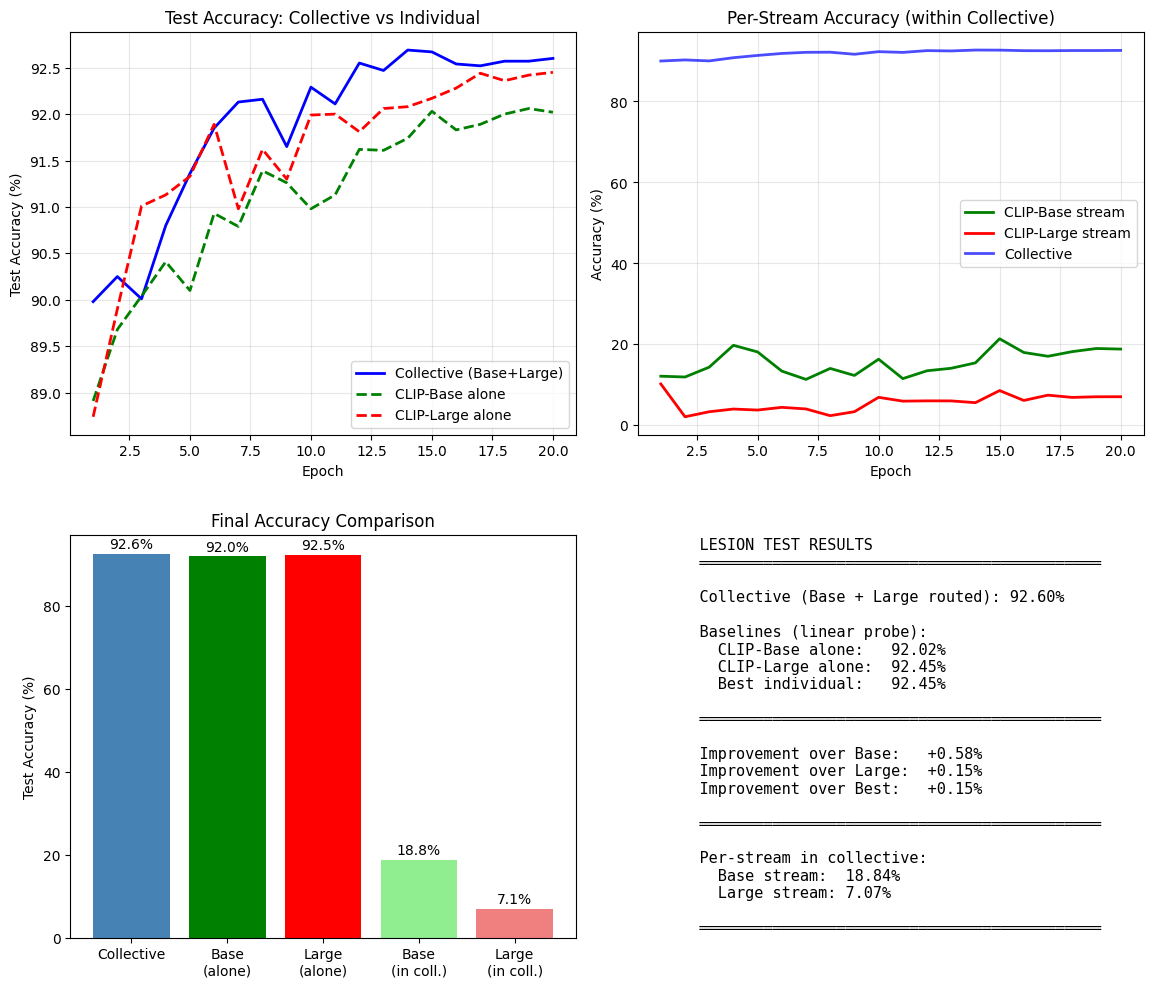


Saved: dual_clip_results.png


In [3]:
"""
Dual Frozen CLIP Lesion Test
============================
CLIP-Base + CLIP-Large, both frozen.
Only the router and translation heads learn.

Hypothesis: Two frozen models with different architectures (different "lenses")
coordinated through the router will outperform either individually.

This is the purest test of the router's coordination capacity.
No vision encoder learning. Just routing frozen expertise.

Author: AbstractPhil
Date: December 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPVisionModel
import math
import time
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    get_registry,
    RouterMailbox,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class DualCLIPConfig:
    """Configuration for dual frozen CLIP experiment."""

    # Image
    image_size: int = 28
    num_classes: int = 10

    # Feature dimensions
    feature_dim: int = 256  # Our internal routing dimension
    clip_base_dim: int = 768  # ViT-B/32 output
    clip_large_dim: int = 1024  # ViT-L/14 output (not 768!)
    fingerprint_dim: int = 64

    # Router
    num_anchors: int = 12
    num_routes: int = 6
    num_slots: int = 12  # Sequence length for routing

    # Training
    batch_size: int = 64  # Smaller batch for dual CLIP memory
    epochs: int = 20
    lr: float = 3e-4
    weight_decay: float = 0.01

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# =============================================================================
# FROZEN CLIP STREAMS
# =============================================================================

class FrozenCLIPStream(nn.Module):
    """
    Frozen CLIP encoder with learnable translation and router.
    The CLIP model is completely frozen - only translation + router learn.
    """

    def __init__(
        self,
        config: DualCLIPConfig,
        model_name: str,
        clip_dim: int,
        stream_name: str,
        parent_id: Optional[str] = None,
    ):
        super().__init__()
        self.config = config
        self.stream_name = stream_name

        # Load frozen CLIP directly to GPU
        print(f"  Loading {model_name}...")
        self.clip = CLIPVisionModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16,  # Use FP16 for speed
        ).to(config.device)
        self.clip.eval()
        for param in self.clip.parameters():
            param.requires_grad = False

        # Register normalization constants as buffers (stay on device)
        self.register_buffer('clip_mean',
            torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1))
        self.register_buffer('clip_std',
            torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1))

        # Learnable translation head
        self.translation = nn.Sequential(
            nn.Linear(clip_dim, config.feature_dim * 2),
            nn.LayerNorm(config.feature_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim * 2, config.feature_dim * config.num_slots),
        )

        # Learnable slot embeddings
        self.slot_embed = nn.Parameter(
            torch.randn(1, config.num_slots, config.feature_dim) * 0.02
        )

        # Router with unique fingerprint
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=True,
            use_cantor_prior=True,
            grid_size=(config.num_slots, 1),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            parent_id=parent_id,
            cooperation_group="dual_clip_collective",
            name=stream_name,
        )

    @property
    def fingerprint(self) -> torch.Tensor:
        return self.router.fingerprint

    @property
    def module_id(self) -> str:
        return self.router.module_id

    def forward(
        self,
        pixel_values: torch.Tensor,
        mailbox: RouterMailbox,
        target_fingerprint: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            pixel_values: [B, 3, 224, 224] preprocessed for CLIP
            mailbox: Shared mailbox
            target_fingerprint: Next stream's fingerprint

        Returns:
            features: [B, num_slots, feature_dim]
            info: Dict with metrics
        """
        B = pixel_values.shape[0]

        # Frozen CLIP forward (FP16)
        with torch.no_grad():
            clip_out = self.clip(pixel_values=pixel_values.half())
            clip_features = clip_out.pooler_output.float()  # [B, clip_dim]

        # Translate to our space (this IS learnable)
        translated = self.translation(clip_features)  # [B, feature_dim * num_slots]
        slots = translated.view(B, self.config.num_slots, self.config.feature_dim)

        # Add learnable slot embeddings
        slots = slots + self.slot_embed

        # Route through GlobalFractalRouter
        routes, weights, routed = self.router(
            slots,
            mailbox=mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=False,
        )

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return routed, info


# =============================================================================
# DUAL CLIP COLLECTIVE
# =============================================================================

class DualCLIPCollective(nn.Module):
    """
    Two frozen CLIP models coordinated via GlobalFractalRouter.
    Only translation heads and router parameters learn.
    """

    def __init__(self, config: DualCLIPConfig):
        super().__init__()
        self.config = config

        # Reset registry
        get_registry().reset()

        # CLIP-Base stream (first in chain)
        self.clip_base = FrozenCLIPStream(
            config=config,
            model_name="openai/clip-vit-base-patch32",
            clip_dim=config.clip_base_dim,
            stream_name="clip_base",
            parent_id=None,
        )

        # CLIP-Large stream (child of base)
        self.clip_large = FrozenCLIPStream(
            config=config,
            model_name="openai/clip-vit-large-patch14",
            clip_dim=config.clip_large_dim,
            stream_name="clip_large",
            parent_id=self.clip_base.module_id,
        )

        self.streams = nn.ModuleList([self.clip_base, self.clip_large])

        # Shared mailbox
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
        )
        self.mailbox = RouterMailbox(router_config)

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(config.feature_dim * 2, config.feature_dim * 2),
            nn.LayerNorm(config.feature_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim * 2, config.feature_dim),
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.feature_dim),
            nn.Linear(config.feature_dim, config.num_classes),
        )

        # Per-stream classifiers (for measuring individual contribution)
        self.stream_classifiers = nn.ModuleList([
            nn.Linear(config.feature_dim, config.num_classes)
            for _ in range(2)
        ])

    def preprocess_for_clip(self, x: torch.Tensor) -> torch.Tensor:
        """Convert MNIST/FashionMNIST to CLIP input format."""
        # x: [B, 1, 28, 28] normalized MNIST

        # Undo normalization (approximate)
        x = x * 0.3530 + 0.2860  # FashionMNIST stats
        x = x.clamp(0, 1)

        # Convert to RGB and resize
        x_rgb = x.expand(-1, 3, -1, -1)  # [B, 3, 28, 28]
        x_resized = F.interpolate(x_rgb, size=(224, 224), mode='bilinear', align_corners=False)

        # CLIP normalization (use registered buffers)
        x_clip = (x_resized - self.clip_base.clip_mean) / self.clip_base.clip_std

        return x_clip

    def forward(
        self,
        x: torch.Tensor,
        return_individual: bool = False,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, 1, 28, 28] input images

        Returns:
            logits: [B, num_classes]
            info: Dict with metrics
        """
        # Preprocess once for both CLIPs
        x_clip = self.preprocess_for_clip(x)

        # Clear mailbox
        self.mailbox.clear()

        # Process streams
        stream_features = []
        stream_infos = []

        for i, stream in enumerate(self.streams):
            target_fp = self.streams[i + 1].fingerprint if i < len(self.streams) - 1 else None

            features, info = stream(x_clip, self.mailbox, target_fp)

            # Pool across slots
            pooled = features.mean(dim=1)  # [B, feature_dim]
            stream_features.append(pooled)
            stream_infos.append(info)

        # Fuse
        fused = torch.cat(stream_features, dim=-1)
        fused = self.fusion(fused)

        # Classify
        logits = self.classifier(fused)

        info = {
            'stream_infos': stream_infos,
            'mailbox_messages': len(self.mailbox.messages),
        }

        if return_individual:
            individual_logits = []
            for feat, clf in zip(stream_features, self.stream_classifiers):
                individual_logits.append(clf(feat))
            info['individual_logits'] = individual_logits

        return logits, info


# =============================================================================
# SINGLE CLIP BASELINE
# =============================================================================

class SingleCLIPBaseline(nn.Module):
    """Single frozen CLIP with linear probe (no routing)."""

    def __init__(self, config: DualCLIPConfig, model_name: str, clip_dim: int, name: str):
        super().__init__()
        self.config = config
        self.name = name

        print(f"  Loading {model_name} (baseline)...")
        self.clip = CLIPVisionModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
        ).to(config.device)
        self.clip.eval()
        for param in self.clip.parameters():
            param.requires_grad = False

        # Register normalization constants as buffers
        self.register_buffer('clip_mean',
            torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1))
        self.register_buffer('clip_std',
            torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(clip_dim, config.feature_dim),
            nn.LayerNorm(config.feature_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim, config.num_classes),
        )

    def preprocess_for_clip(self, x: torch.Tensor) -> torch.Tensor:
        x = x * 0.3530 + 0.2860  # FashionMNIST stats
        x = x.clamp(0, 1)
        x_rgb = x.expand(-1, 3, -1, -1)
        x_resized = F.interpolate(x_rgb, size=(224, 224), mode='bilinear', align_corners=False)
        return (x_resized - self.clip_mean) / self.clip_std

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_clip = self.preprocess_for_clip(x)
        with torch.no_grad():
            clip_out = self.clip(pixel_values=x_clip.half())
            features = clip_out.pooler_output.float()
        return self.classifier(features)


# =============================================================================
# TRAINING
# =============================================================================

def get_dataloaders(config: DualCLIPConfig):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),  # FashionMNIST stats
    ])

    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


def train_collective(
    model: DualCLIPCollective,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config: DualCLIPConfig,
):
    """Train dual CLIP collective."""

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    history = defaultdict(list)

    epoch_pbar = tqdm(range(config.epochs), desc="Collective", unit="epoch")

    for epoch in epoch_pbar:
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False, unit="batch")

        for imgs, labels in batch_pbar:
            imgs, labels = imgs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            logits, info = model(imgs, return_individual=True)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            optimizer.step()

            epoch_loss += loss.item() * imgs.size(0)
            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += imgs.size(0)

            batch_pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{correct/total*100:.1f}%"})

        scheduler.step()

        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0
        stream_correct = defaultdict(int)

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc="Eval", leave=False):
                imgs, labels = imgs.to(config.device), labels.to(config.device)
                logits, info = model(imgs, return_individual=True)

                test_correct += (logits.argmax(dim=1) == labels).sum().item()
                test_total += imgs.size(0)

                for i, ind_logits in enumerate(info['individual_logits']):
                    stream_correct[i] += (ind_logits.argmax(dim=1) == labels).sum().item()

        test_acc = test_correct / test_total
        stream_accs = {i: c / test_total for i, c in stream_correct.items()}

        history['test_acc'].append(test_acc)
        history['stream_accs'].append(stream_accs)
        history['train_loss'].append(epoch_loss / total)

        epoch_pbar.set_postfix({'test': f"{test_acc*100:.2f}%"})

        tqdm.write(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/total:.4f} | "
                  f"Test: {test_acc*100:.2f}% | Base: {stream_accs[0]*100:.1f}% | Large: {stream_accs[1]*100:.1f}%")

    return dict(history)


def train_baseline(
    model: SingleCLIPBaseline,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config: DualCLIPConfig,
):
    """Train single CLIP baseline."""

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    history = defaultdict(list)

    epoch_pbar = tqdm(range(config.epochs), desc=model.name, unit="epoch")

    for epoch in epoch_pbar:
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            imgs, labels = imgs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * imgs.size(0)
            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += imgs.size(0)

        scheduler.step()

        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(config.device), labels.to(config.device)
                logits = model(imgs)
                test_correct += (logits.argmax(dim=1) == labels).sum().item()
                test_total += imgs.size(0)

        test_acc = test_correct / test_total
        history['test_acc'].append(test_acc)
        history['train_loss'].append(epoch_loss / total)

        epoch_pbar.set_postfix({'test': f"{test_acc*100:.2f}%"})

        if (epoch + 1) % 5 == 0 or epoch == 0:
            tqdm.write(f"{model.name} Epoch {epoch+1:3d} | Test: {test_acc*100:.2f}%")

    return dict(history)


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_results(
    collective_history: Dict,
    base_history: Dict,
    large_history: Dict,
    config: DualCLIPConfig,
    save_path: str = "dual_clip_results.png",
):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    epochs = range(1, config.epochs + 1)

    # Test accuracy comparison
    ax = axes[0, 0]
    ax.plot(epochs, [a*100 for a in collective_history['test_acc']], 'b-',
            label='Collective (Base+Large)', linewidth=2)
    ax.plot(epochs, [a*100 for a in base_history['test_acc']], 'g--',
            label='CLIP-Base alone', linewidth=2)
    ax.plot(epochs, [a*100 for a in large_history['test_acc']], 'r--',
            label='CLIP-Large alone', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Test Accuracy: Collective vs Individual')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Per-stream accuracy in collective
    ax = axes[0, 1]
    base_in_collective = [sa[0]*100 for sa in collective_history['stream_accs']]
    large_in_collective = [sa[1]*100 for sa in collective_history['stream_accs']]
    ax.plot(epochs, base_in_collective, 'g-', label='CLIP-Base stream', linewidth=2)
    ax.plot(epochs, large_in_collective, 'r-', label='CLIP-Large stream', linewidth=2)
    ax.plot(epochs, [a*100 for a in collective_history['test_acc']], 'b-',
            label='Collective', linewidth=2, alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-Stream Accuracy (within Collective)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Final comparison bar
    ax = axes[1, 0]
    final_collective = collective_history['test_acc'][-1] * 100
    final_base = base_history['test_acc'][-1] * 100
    final_large = large_history['test_acc'][-1] * 100
    final_base_stream = collective_history['stream_accs'][-1][0] * 100
    final_large_stream = collective_history['stream_accs'][-1][1] * 100

    labels = ['Collective', 'Base\n(alone)', 'Large\n(alone)', 'Base\n(in coll.)', 'Large\n(in coll.)']
    values = [final_collective, final_base, final_large, final_base_stream, final_large_stream]
    colors = ['steelblue', 'green', 'red', 'lightgreen', 'lightcoral']

    bars = ax.bar(labels, values, color=colors)
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Final Accuracy Comparison')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

    # Summary
    ax = axes[1, 1]
    ax.axis('off')

    improvement_vs_base = final_collective - final_base
    improvement_vs_large = final_collective - final_large
    improvement_vs_best = final_collective - max(final_base, final_large)

    summary = f"""
    LESION TEST RESULTS
    ════════════════════════════════════════════

    Collective (Base + Large routed): {final_collective:.2f}%

    Baselines (linear probe):
      CLIP-Base alone:   {final_base:.2f}%
      CLIP-Large alone:  {final_large:.2f}%
      Best individual:   {max(final_base, final_large):.2f}%

    ════════════════════════════════════════════

    Improvement over Base:   {improvement_vs_base:+.2f}%
    Improvement over Large:  {improvement_vs_large:+.2f}%
    Improvement over Best:   {improvement_vs_best:+.2f}%

    ════════════════════════════════════════════

    Per-stream in collective:
      Base stream:  {final_base_stream:.2f}%
      Large stream: {final_large_stream:.2f}%

    ════════════════════════════════════════════
    """

    ax.text(0.05, 0.5, summary, fontsize=11, family='monospace',
            verticalalignment='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*60)
    print("  Dual Frozen CLIP Lesion Test")
    print("  CLIP-Base + CLIP-Large via GlobalFractalRouter")
    print("="*60)

    config = DualCLIPConfig()

    print(f"\nConfig:")
    print(f"  Feature dim: {config.feature_dim}")
    print(f"  Epochs: {config.epochs}")
    print(f"  Device: {config.device}")

    # Data
    train_loader, test_loader = get_dataloaders(config)
    print(f"  Train samples: {len(train_loader.dataset)}")
    print(f"  Test samples: {len(test_loader.dataset)}")

    # =================================================================
    # COLLECTIVE (CLIP-Base + CLIP-Large routed)
    # =================================================================
    print("\n" + "="*60)
    print("  Training COLLECTIVE (Base + Large routed)")
    print("="*60)

    collective = DualCLIPCollective(config).to(config.device)

    trainable = sum(p.numel() for p in collective.parameters() if p.requires_grad)
    total = sum(p.numel() for p in collective.parameters())
    print(f"  Trainable: {trainable:,} / Total: {total:,}")
    print(f"  Frozen: {total - trainable:,} ({(total-trainable)/total*100:.1f}%)")

    collective_history = train_collective(collective, train_loader, test_loader, config)

    # =================================================================
    # BASELINE: CLIP-Base alone
    # =================================================================
    print("\n" + "="*60)
    print("  Training BASELINE: CLIP-Base alone")
    print("="*60)

    base_model = SingleCLIPBaseline(
        config, "openai/clip-vit-base-patch32", config.clip_base_dim, "CLIP-Base"
    ).to(config.device)

    trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    print(f"  Trainable: {trainable:,}")

    base_history = train_baseline(base_model, train_loader, test_loader, config)

    # =================================================================
    # BASELINE: CLIP-Large alone
    # =================================================================
    print("\n" + "="*60)
    print("  Training BASELINE: CLIP-Large alone")
    print("="*60)

    large_model = SingleCLIPBaseline(
        config, "openai/clip-vit-large-patch14", config.clip_large_dim, "CLIP-Large"
    ).to(config.device)

    trainable = sum(p.numel() for p in large_model.parameters() if p.requires_grad)
    print(f"  Trainable: {trainable:,}")

    large_history = train_baseline(large_model, train_loader, test_loader, config)

    # =================================================================
    # RESULTS
    # =================================================================
    print("\n" + "="*60)
    print("  FINAL RESULTS")
    print("="*60)

    final_collective = collective_history['test_acc'][-1]
    final_base = base_history['test_acc'][-1]
    final_large = large_history['test_acc'][-1]

    print(f"\n  Collective:   {final_collective*100:.2f}%")
    print(f"  CLIP-Base:    {final_base*100:.2f}%")
    print(f"  CLIP-Large:   {final_large*100:.2f}%")

    improvement = final_collective - max(final_base, final_large)
    print(f"\n  Improvement over best individual: {improvement*100:+.2f}%")

    print(f"\n  Per-stream in collective:")
    print(f"    Base stream:  {collective_history['stream_accs'][-1][0]*100:.2f}%")
    print(f"    Large stream: {collective_history['stream_accs'][-1][1]*100:.2f}%")

    plot_results(collective_history, base_history, large_history, config)

    return collective, base_model, large_model, collective_history, base_history, large_history


if __name__ == "__main__":
    results = main()

# imagenet experiment - the big five clips

In [4]:
"""
ImageNet Multi-CLIP Collective Experiment
==========================================
Uses pre-extracted CLIP features from multiple model variants.
No image processing - pure feature routing at A100 speeds.

Dataset: AbstractPhil/clip-imagenet-features
Streams: b32, b16, l14, laion_b32, laion_bigg14, laion_h14

Each CLIP variant becomes an expert stream with:
- Learnable translation head
- Own router with unique fingerprint
- Hierarchical coordination via mailbox

Training:
- AMP mixed precision
- 8 workers total, pinned, persistent
- Hierarchical chain topology

Author: AbstractPhil
Date: December 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from datasets import load_dataset
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# =============================================================================
# IMPORTS FROM GEOFRACTAL
# =============================================================================

from geofractal.model.blocks.router.global_fractal_router import (
    GlobalFractalRouter,
    GlobalFractalRouterConfig,
    get_registry,
    RouterMailbox,
)

# =============================================================================
# CONFIG
# =============================================================================

@dataclass
class ImageNetCollectiveConfig:
    """Configuration for ImageNet multi-CLIP collective."""

    # Dataset
    dataset_name: str = "AbstractPhil/imagenet-clip-features"
    num_classes: int = 1000

    # CLIP variants and their dimensions
    clip_variants: Dict[str, int] = field(default_factory=lambda: {
        'clip_vit_b32': 512,
        'clip_vit_b16': 512,
        'clip_vit_l14': 768,
        'clip_vit_laion_b32': 512,
        'clip_vit_laion_bigg14': 1280,
        # 'clip_vit_laion_h14': 1024,  # Can add if memory permits
    })

    # Feature dimensions
    feature_dim: int = 512  # Internal routing dimension
    fingerprint_dim: int = 64

    # Router
    num_anchors: int = 16
    num_routes: int = 8
    num_slots: int = 16  # Sequence length for routing

    # Training
    batch_size: int = 256
    epochs: int = 20
    lr: float = 3e-4
    weight_decay: float = 0.01
    warmup_epochs: int = 2

    # DataLoader - A100 optimized
    num_workers: int = 8  # Total across all loaders
    pin_memory: bool = True
    persistent_workers: bool = True
    prefetch_factor: int = 4

    # AMP
    use_amp: bool = True

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    def workers_per_loader(self) -> int:
        """Distribute workers across loaders."""
        n_loaders = len(self.clip_variants)
        return max(1, self.num_workers // n_loaders)


# =============================================================================
# DATASET
# =============================================================================

class CLIPFeatureDataset(Dataset):
    """
    Wraps HuggingFace dataset for a single CLIP variant.
    Returns pre-extracted features and labels.
    """

    def __init__(
        self,
        hf_dataset,
        feature_column: str = 'clip_features',
        label_column: str = 'label',
    ):
        self.dataset = hf_dataset
        self.feature_column = feature_column
        self.label_column = label_column

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        features = torch.tensor(item[self.feature_column], dtype=torch.float32)
        label = item[self.label_column]
        return features, label


class MultiCLIPDataset(Dataset):
    """
    Loads features from multiple CLIP variants simultaneously.
    Returns dict of features + label.
    """

    def __init__(
        self,
        dataset_name: str,
        split_prefix: str,  # e.g., 'train' or 'validation'
        clip_variants: Dict[str, int],
    ):
        self.variants = list(clip_variants.keys())
        self.datasets = {}

        print(f"Loading {split_prefix} splits...")
        for variant in tqdm(self.variants, desc="Loading variants"):
            split_name = f"{variant}_{split_prefix}"
            try:
                ds = load_dataset(dataset_name, split=split_name)
                self.datasets[variant] = ds
                print(f"  {variant}: {len(ds):,} samples")
            except Exception as e:
                print(f"  WARNING: Could not load {split_name}: {e}")

        # Use first dataset for length (all should be same)
        self.length = len(next(iter(self.datasets.values())))

        # Verify all same length
        for name, ds in self.datasets.items():
            assert len(ds) == self.length, f"{name} has {len(ds)} != {self.length}"

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        features = {}
        label = None

        for variant, ds in self.datasets.items():
            item = ds[idx]
            features[variant] = torch.tensor(item['clip_features'], dtype=torch.float32)
            if label is None:
                label = item['label']

        return features, label


def get_dataloaders(config: ImageNetCollectiveConfig):
    """Create train and validation dataloaders."""

    train_dataset = MultiCLIPDataset(
        config.dataset_name,
        'train',
        config.clip_variants,
    )

    val_dataset = MultiCLIPDataset(
        config.dataset_name,
        'validation',
        config.clip_variants,
    )

    # Collate function for dict of features
    def collate_fn(batch):
        features = {k: [] for k in config.clip_variants.keys()}
        labels = []

        for feat_dict, label in batch:
            for k, v in feat_dict.items():
                features[k].append(v)
            labels.append(label)

        features = {k: torch.stack(v) for k, v in features.items()}
        labels = torch.tensor(labels, dtype=torch.long)

        return features, labels

    workers_per = config.workers_per_loader()

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None,
        collate_fn=collate_fn,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None,
        collate_fn=collate_fn,
    )

    return train_loader, val_loader


# =============================================================================
# FEATURE STREAM (No CLIP model - just translation + routing)
# =============================================================================

class FeatureStream(nn.Module):
    """
    Stream for pre-extracted CLIP features.
    No CLIP model - just translation head + router.
    """

    def __init__(
        self,
        config: ImageNetCollectiveConfig,
        variant_name: str,
        input_dim: int,
        parent_id: Optional[str] = None,
    ):
        super().__init__()
        self.config = config
        self.variant_name = variant_name
        self.input_dim = input_dim

        # Translation head: CLIP dim → routing space
        self.translation = nn.Sequential(
            nn.Linear(input_dim, config.feature_dim * 2),
            nn.LayerNorm(config.feature_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim * 2, config.feature_dim * config.num_slots),
        )

        # Learnable slot embeddings (unique per stream)
        self.slot_embed = nn.Parameter(
            torch.randn(1, config.num_slots, config.feature_dim) * 0.02
        )

        # Router with unique fingerprint
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
            num_anchors=config.num_anchors,
            num_routes=config.num_routes,
            use_adjacent_gating=True,
            use_cantor_prior=True,
            grid_size=(config.num_slots, 1),
        )

        self.router = GlobalFractalRouter(
            config=router_config,
            parent_id=parent_id,
            cooperation_group="imagenet_collective",
            name=variant_name,
        )

    @property
    def fingerprint(self) -> torch.Tensor:
        return self.router.fingerprint

    @property
    def module_id(self) -> str:
        return self.router.module_id

    def forward(
        self,
        features: torch.Tensor,
        mailbox: RouterMailbox,
        target_fingerprint: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            features: [B, input_dim] pre-extracted CLIP features
            mailbox: Shared mailbox
            target_fingerprint: Next stream's fingerprint

        Returns:
            routed: [B, num_slots, feature_dim]
            info: Dict with metrics
        """
        B = features.shape[0]

        # Translate to routing space
        translated = self.translation(features)  # [B, feature_dim * num_slots]
        slots = translated.view(B, self.config.num_slots, self.config.feature_dim)

        # Add slot embeddings
        slots = slots + self.slot_embed

        # Route
        routes, weights, routed = self.router(
            slots,
            mailbox=mailbox,
            target_fingerprint=target_fingerprint,
            skip_first=False,
        )

        info = {
            'route_entropy': -(weights * (weights + 1e-8).log()).sum(dim=-1).mean().item(),
        }

        return routed, info


# =============================================================================
# MULTI-CLIP COLLECTIVE
# =============================================================================

class ImageNetCollective(nn.Module):
    """
    Collective of pre-extracted CLIP features from multiple variants.
    Hierarchical chain topology with shared mailbox coordination.
    """

    def __init__(self, config: ImageNetCollectiveConfig):
        super().__init__()
        self.config = config

        # Reset registry for fresh start
        get_registry().reset()

        # Build streams in hierarchical chain
        self.streams = nn.ModuleDict()
        self.stream_order = list(config.clip_variants.keys())

        parent_id = None
        for variant_name, input_dim in config.clip_variants.items():
            stream = FeatureStream(
                config=config,
                variant_name=variant_name,
                input_dim=input_dim,
                parent_id=parent_id,
            )
            self.streams[variant_name] = stream
            parent_id = stream.module_id
            print(f"  Stream: {variant_name} ({input_dim}D) -> parent: {parent_id[:8] if parent_id else 'root'}...")

        # Shared mailbox
        router_config = GlobalFractalRouterConfig(
            feature_dim=config.feature_dim,
            fingerprint_dim=config.fingerprint_dim,
        )
        self.mailbox = RouterMailbox(router_config)

        # Fusion layer
        num_streams = len(config.clip_variants)
        self.fusion = nn.Sequential(
            nn.Linear(config.feature_dim * num_streams, config.feature_dim * 2),
            nn.LayerNorm(config.feature_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim * 2, config.feature_dim),
            nn.LayerNorm(config.feature_dim),
        )

        # Classification head
        self.classifier = nn.Linear(config.feature_dim, config.num_classes)

        # Per-stream classifiers (for measuring individual contribution)
        self.stream_classifiers = nn.ModuleDict({
            name: nn.Linear(config.feature_dim, config.num_classes)
            for name in config.clip_variants.keys()
        })

    def forward(
        self,
        features: Dict[str, torch.Tensor],
        return_individual: bool = False,
    ) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            features: Dict mapping variant name to [B, clip_dim] features
            return_individual: Also return per-stream predictions

        Returns:
            logits: [B, num_classes]
            info: Dict with metrics
        """
        # Clear mailbox
        self.mailbox.clear()

        # Process streams in order
        stream_features = {}
        stream_infos = {}

        for i, name in enumerate(self.stream_order):
            stream = self.streams[name]

            # Get target fingerprint (next stream or None)
            if i < len(self.stream_order) - 1:
                next_name = self.stream_order[i + 1]
                target_fp = self.streams[next_name].fingerprint
            else:
                target_fp = None

            # Forward
            routed, info = stream(features[name], self.mailbox, target_fp)

            # Pool across slots
            pooled = routed.mean(dim=1)  # [B, feature_dim]
            stream_features[name] = pooled
            stream_infos[name] = info

        # Fuse all streams
        fused = torch.cat([stream_features[n] for n in self.stream_order], dim=-1)
        fused = self.fusion(fused)

        # Classify
        logits = self.classifier(fused)

        info = {
            'stream_infos': stream_infos,
            'mailbox_messages': len(self.mailbox.messages),
            'mean_route_entropy': np.mean([i['route_entropy'] for i in stream_infos.values()]),
        }

        if return_individual:
            individual_logits = {
                name: self.stream_classifiers[name](stream_features[name])
                for name in self.stream_order
            }
            info['individual_logits'] = individual_logits

        return logits, info


# =============================================================================
# SINGLE STREAM BASELINE
# =============================================================================

class SingleStreamBaseline(nn.Module):
    """Single CLIP variant with linear probe (no routing)."""

    def __init__(self, config: ImageNetCollectiveConfig, variant_name: str, input_dim: int):
        super().__init__()
        self.variant_name = variant_name

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, config.feature_dim),
            nn.LayerNorm(config.feature_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.feature_dim, config.num_classes),
        )

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        return self.classifier(features)


# =============================================================================
# TRAINING
# =============================================================================

def train_collective(
    model: ImageNetCollective,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: ImageNetCollectiveConfig,
):
    """Train collective with AMP."""

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    # Warmup + cosine schedule
    total_steps = len(train_loader) * config.epochs
    warmup_steps = len(train_loader) * config.warmup_epochs

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    scaler = GradScaler() if config.use_amp else None

    history = defaultdict(list)
    best_acc = 0

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs}")

        for features, labels in pbar:
            # Move to device
            features = {k: v.to(config.device, non_blocking=True) for k, v in features.items()}
            labels = labels.to(config.device, non_blocking=True)

            optimizer.zero_grad()

            if config.use_amp:
                with autocast():
                    logits, info = model(features)
                    loss = F.cross_entropy(logits, labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                logits, info = model(features)
                loss = F.cross_entropy(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            scheduler.step()

            epoch_loss += loss.item() * labels.size(0)
            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{correct/total*100:.1f}%",
                'lr': f"{scheduler.get_last_lr()[0]:.2e}",
            })

        # Validate
        val_acc, val_stream_accs = evaluate_collective(model, val_loader, config)

        history['train_loss'].append(epoch_loss / total)
        history['train_acc'].append(correct / total)
        history['val_acc'].append(val_acc)
        history['stream_accs'].append(val_stream_accs)

        # Log
        stream_str = ' | '.join([f"{k[:4]}: {v*100:.1f}%" for k, v in val_stream_accs.items()])
        tqdm.write(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/total:.4f} | "
                  f"Val: {val_acc*100:.2f}% | {stream_str}")

        if val_acc > best_acc:
            best_acc = val_acc
            tqdm.write(f"  ★ New best: {best_acc*100:.2f}%")

    return dict(history), best_acc


def evaluate_collective(
    model: ImageNetCollective,
    loader: DataLoader,
    config: ImageNetCollectiveConfig,
) -> Tuple[float, Dict[str, float]]:
    """Evaluate collective and per-stream accuracy."""

    model.eval()
    correct = 0
    total = 0
    stream_correct = defaultdict(int)

    with torch.no_grad():
        for features, labels in tqdm(loader, desc="Eval", leave=False):
            features = {k: v.to(config.device, non_blocking=True) for k, v in features.items()}
            labels = labels.to(config.device, non_blocking=True)

            if config.use_amp:
                with autocast():
                    logits, info = model(features, return_individual=True)
            else:
                logits, info = model(features, return_individual=True)

            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

            for name, ind_logits in info['individual_logits'].items():
                stream_correct[name] += (ind_logits.argmax(dim=1) == labels).sum().item()

    acc = correct / total
    stream_accs = {k: v / total for k, v in stream_correct.items()}

    return acc, stream_accs


def train_baseline(
    variant_name: str,
    input_dim: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: ImageNetCollectiveConfig,
):
    """Train single stream baseline."""

    model = SingleStreamBaseline(config, variant_name, input_dim).to(config.device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
    scaler = GradScaler() if config.use_amp else None

    history = defaultdict(list)
    best_acc = 0

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for features, labels in tqdm(train_loader, desc=f"{variant_name} E{epoch+1}", leave=False):
            feat = features[variant_name].to(config.device, non_blocking=True)
            labels = labels.to(config.device, non_blocking=True)

            optimizer.zero_grad()

            if config.use_amp:
                with autocast():
                    logits = model(feat)
                    loss = F.cross_entropy(logits, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(feat)
                loss = F.cross_entropy(logits, labels)
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            correct += (logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        # Validate
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for features, labels in val_loader:
                feat = features[variant_name].to(config.device, non_blocking=True)
                labels = labels.to(config.device, non_blocking=True)

                if config.use_amp:
                    with autocast():
                        logits = model(feat)
                else:
                    logits = model(feat)

                val_correct += (logits.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc

        if (epoch + 1) % 5 == 0 or epoch == 0:
            tqdm.write(f"{variant_name} Epoch {epoch+1:3d} | Val: {val_acc*100:.2f}%")

    return dict(history), best_acc


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_results(
    collective_history: Dict,
    baseline_results: Dict[str, float],
    config: ImageNetCollectiveConfig,
    save_path: str = "imagenet_collective_results.png",
):
    """Plot training results."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs = range(1, len(collective_history['val_acc']) + 1)

    # Validation accuracy over time
    ax = axes[0, 0]
    ax.plot(epochs, [a*100 for a in collective_history['val_acc']], 'b-',
            label='Collective', linewidth=2)
    for name in config.clip_variants.keys():
        accs = [sa[name]*100 for sa in collective_history['stream_accs']]
        ax.plot(epochs, accs, '--', label=f'{name} (in coll.)', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy (%)')
    ax.set_title('Training Progress')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Final comparison bar
    ax = axes[0, 1]

    final_collective = collective_history['val_acc'][-1] * 100
    final_streams = {k: v*100 for k, v in collective_history['stream_accs'][-1].items()}

    names = ['Collective'] + list(baseline_results.keys())
    values = [final_collective] + [v*100 for v in baseline_results.values()]
    colors = ['steelblue'] + ['coral'] * len(baseline_results)

    bars = ax.bar(range(len(names)), values, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels([n.replace('clip_vit_', '').replace('_', '\n') for n in names], fontsize=8)
    ax.set_ylabel('Validation Accuracy (%)')
    ax.set_title('Final Accuracy: Collective vs Individual Baselines')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

    # Per-stream accuracy in collective vs baseline
    ax = axes[1, 0]

    stream_names = list(config.clip_variants.keys())
    x = np.arange(len(stream_names))
    width = 0.35

    in_collective = [final_streams[n] for n in stream_names]
    standalone = [baseline_results[n]*100 for n in stream_names]

    bars1 = ax.bar(x - width/2, in_collective, width, label='In Collective', color='steelblue')
    bars2 = ax.bar(x + width/2, standalone, width, label='Standalone', color='coral')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-Stream: Collective vs Standalone')
    ax.set_xticks(x)
    ax.set_xticklabels([n.replace('clip_vit_', '') for n in stream_names], fontsize=8, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Summary
    ax = axes[1, 1]
    ax.axis('off')

    best_baseline = max(baseline_results.values()) * 100
    improvement = final_collective - best_baseline

    summary = f"""
    IMAGENET COLLECTIVE RESULTS
    ════════════════════════════════════════════════════════

    Collective:           {final_collective:.2f}%
    Best Individual:      {best_baseline:.2f}%

    Improvement:          {improvement:+.2f}%

    ════════════════════════════════════════════════════════

    Per-stream in collective:
    """

    for name, acc in final_streams.items():
        short_name = name.replace('clip_vit_', '')
        summary += f"\n      {short_name:<15}: {acc:.2f}%"

    summary += """

    ════════════════════════════════════════════════════════

    Individual baselines:
    """

    for name, acc in baseline_results.items():
        short_name = name.replace('clip_vit_', '')
        summary += f"\n      {short_name:<15}: {acc*100:.2f}%"

    ax.text(0.05, 0.95, summary, fontsize=10, family='monospace',
            verticalalignment='top', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {save_path}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*70)
    print("  ImageNet Multi-CLIP Collective Experiment")
    print("  Pre-extracted Features via GlobalFractalRouter")
    print("="*70)

    config = ImageNetCollectiveConfig()

    print(f"\nConfig:")
    print(f"  Dataset: {config.dataset_name}")
    print(f"  Variants: {len(config.clip_variants)}")
    for name, dim in config.clip_variants.items():
        print(f"    - {name}: {dim}D")
    print(f"  Feature dim: {config.feature_dim}")
    print(f"  Epochs: {config.epochs}")
    print(f"  Batch size: {config.batch_size}")
    print(f"  AMP: {config.use_amp}")
    print(f"  Device: {config.device}")

    # Data
    print("\n" + "="*70)
    print("  Loading Data")
    print("="*70)

    train_loader, val_loader = get_dataloaders(config)
    print(f"\n  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")

    # =================================================================
    # COLLECTIVE
    # =================================================================
    print("\n" + "="*70)
    print("  Training COLLECTIVE")
    print("="*70)

    collective = ImageNetCollective(config).to(config.device)

    params = sum(p.numel() for p in collective.parameters())
    print(f"\n  Parameters: {params:,}")

    collective_history, collective_best = train_collective(
        collective, train_loader, val_loader, config
    )

    # =================================================================
    # BASELINES
    # =================================================================
    print("\n" + "="*70)
    print("  Training BASELINES (Individual Streams)")
    print("="*70)

    baseline_results = {}

    for variant_name, input_dim in config.clip_variants.items():
        print(f"\n  Training: {variant_name}")
        _, best_acc = train_baseline(
            variant_name, input_dim, train_loader, val_loader, config
        )
        baseline_results[variant_name] = best_acc
        print(f"  {variant_name} best: {best_acc*100:.2f}%")

    # =================================================================
    # RESULTS
    # =================================================================
    print("\n" + "="*70)
    print("  FINAL RESULTS")
    print("="*70)

    print(f"\n  Collective:      {collective_best*100:.2f}%")
    print(f"  Best individual: {max(baseline_results.values())*100:.2f}%")
    print(f"  Improvement:     {(collective_best - max(baseline_results.values()))*100:+.2f}%")

    print("\n  Per-stream final (in collective):")
    for name, acc in collective_history['stream_accs'][-1].items():
        print(f"    {name}: {acc*100:.2f}%")

    print("\n  Individual baselines:")
    for name, acc in baseline_results.items():
        print(f"    {name}: {acc*100:.2f}%")

    plot_results(collective_history, baseline_results, config)

    return collective, collective_history, baseline_results


if __name__ == "__main__":
    results = main()

  ImageNet Multi-CLIP Collective Experiment
  Pre-extracted Features via GlobalFractalRouter

Config:
  Dataset: AbstractPhil/imagenet-clip-features
  Variants: 5
    - clip_vit_b32: 512D
    - clip_vit_b16: 512D
    - clip_vit_l14: 768D
    - clip_vit_laion_b32: 512D
    - clip_vit_laion_bigg14: 1280D
  Feature dim: 512
  Epochs: 20
  Batch size: 256
  AMP: True
  Device: cuda

  Loading Data
Loading train splits...


Loading variants:   0%|          | 0/5 [00:00<?, ?it/s]

  clip_vit_b32: 1,281,167 samples
  clip_vit_b16: 1,281,167 samples
  clip_vit_l14: 1,281,167 samples
  clip_vit_laion_b32: 1,281,167 samples
  clip_vit_laion_bigg14: 1,281,167 samples
Loading validation splits...


Loading variants:   0%|          | 0/5 [00:00<?, ?it/s]

  clip_vit_b32: 50,000 samples
  clip_vit_b16: 50,000 samples
  clip_vit_l14: 50,000 samples
  clip_vit_laion_b32: 50,000 samples
  clip_vit_laion_bigg14: 50,000 samples

  Train batches: 5004
  Val batches: 196

  Training COLLECTIVE
  Stream: clip_vit_b32 (512D) -> parent: clip_vit...
  Stream: clip_vit_b16 (512D) -> parent: clip_vit...
  Stream: clip_vit_l14 (768D) -> parent: clip_vit...
  Stream: clip_vit_laion_b32 (512D) -> parent: clip_vit...
  Stream: clip_vit_laion_bigg14 (1280D) -> parent: clip_vit...

  Parameters: 59,721,752


/tmp/ipython-input-3118631052.py:515: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if config.use_amp else None


Epoch 1/20:   0%|          | 0/5004 [00:00<?, ?it/s]

/tmp/ipython-input-3118631052.py:536: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Eval:   0%|          | 0/196 [00:00<?, ?it/s]

/tmp/ipython-input-3118631052.py:602: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1 | Loss: 1.6028 | Val: 82.52% | clip: 0.1% | clip: 0.1% | clip: 0.0% | clip: 0.1% | clip: 0.1%
  ★ New best: 82.52%


Epoch 2/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   2 | Loss: 0.5487 | Val: 82.72% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%
  ★ New best: 82.72%


Epoch 3/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   3 | Loss: 0.4926 | Val: 83.39% | clip: 0.2% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%
  ★ New best: 83.39%


Epoch 4/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   4 | Loss: 0.4179 | Val: 84.20% | clip: 0.1% | clip: 0.1% | clip: 0.2% | clip: 0.1% | clip: 0.1%
  ★ New best: 84.20%


Epoch 5/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   5 | Loss: 0.3554 | Val: 84.68% | clip: 0.2% | clip: 0.2% | clip: 0.1% | clip: 0.1% | clip: 0.1%
  ★ New best: 84.68%


Epoch 6/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   6 | Loss: 0.2970 | Val: 84.64% | clip: 0.2% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 7/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   7 | Loss: 0.2440 | Val: 84.49% | clip: 0.2% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 8/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   8 | Loss: 0.1988 | Val: 84.55% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.2%


Epoch 9/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch   9 | Loss: 0.1608 | Val: 84.37% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.2%


Epoch 10/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  10 | Loss: 0.1287 | Val: 84.41% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 11/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  11 | Loss: 0.1019 | Val: 84.25% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 12/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  12 | Loss: 0.0799 | Val: 84.41% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 13/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  13 | Loss: 0.0624 | Val: 84.41% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 14/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  14 | Loss: 0.0482 | Val: 84.35% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 15/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  15 | Loss: 0.0376 | Val: 84.42% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 16/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  16 | Loss: 0.0293 | Val: 84.54% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 17/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  17 | Loss: 0.0229 | Val: 84.65% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 18/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  18 | Loss: 0.0183 | Val: 84.67% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 19/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  19 | Loss: 0.0151 | Val: 84.64% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%


Epoch 20/20:   0%|          | 0/5004 [00:00<?, ?it/s]

Eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  20 | Loss: 0.0136 | Val: 84.64% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1% | clip: 0.1%

  Training BASELINES (Individual Streams)

  Training: clip_vit_b32


/tmp/ipython-input-3118631052.py:632: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if config.use_amp else None


clip_vit_b32 E1:   0%|          | 0/5004 [00:00<?, ?it/s]

/tmp/ipython-input-3118631052.py:650: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-3118631052.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


clip_vit_b32 Epoch   1 | Val: 72.46%


clip_vit_b32 E2:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E3:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E4:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E5:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 Epoch   5 | Val: 74.07%


clip_vit_b32 E6:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E7:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E8:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E9:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E10:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 Epoch  10 | Val: 74.56%


clip_vit_b32 E11:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E12:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E13:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E14:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E15:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 Epoch  15 | Val: 74.71%


clip_vit_b32 E16:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E17:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E18:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E19:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 E20:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b32 Epoch  20 | Val: 74.89%
  clip_vit_b32 best: 74.91%

  Training: clip_vit_b16


clip_vit_b16 E1:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 Epoch   1 | Val: 76.75%


clip_vit_b16 E2:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E3:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E4:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E5:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 Epoch   5 | Val: 78.39%


clip_vit_b16 E6:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E7:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E8:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E9:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E10:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 Epoch  10 | Val: 78.43%


clip_vit_b16 E11:   0%|          | 0/5004 [00:00<?, ?it/s]

clip_vit_b16 E12:   0%|          | 0/5004 [00:00<?, ?it/s]

Exception in thread Thread-5 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_s

KeyboardInterrupt: 

# lesion test on the imagenet pretrained router